In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('./data/ICLR-2017-18-19-21.csv')
data.info()
abstract = list(data.ABSTRACT)
title = list(data.TITLE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YEAR          1497 non-null   int64  
 1   TITLE         1497 non-null   object 
 2   Authors       1497 non-null   object 
 3   Paper Link    1497 non-null   object 
 4   ABSTRACT      1497 non-null   object 
 5   Affiliations  1497 non-null   object 
 6   Citations     1497 non-null   object 
 7   Unnamed: 7    1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 93.7+ KB


In [3]:
data.head(4)

YEAR                                              TITLE  \
0  2017  Making Neural Programming Architectures Genera...   
1  2017             End-to-end Optimized Image Compression   
2  2017      Optimization as a Model for Few-Shot Learning   
3  2017           Learning End-to-End Goal-Oriented Dialog   

                                             Authors  \
0              Jonathon Cai, Richard Shin, Dawn Song   
1  Johannes Ballé, Valero Laparra, Eero P. Simonc...   
2                       Sachin Ravi, Hugo Larochelle   
3        Antoine Bordes, Y-Lan Boureau, Jason Weston   

                                          Paper Link  \
0  https://openreview.net/forum?id=BkbY4psgg&note...   
1  https://openreview.net/forum?id=rJxdQ3jeg&note...   
2  https://openreview.net/forum?id=rJY0-Kcll&note...   
3  https://openreview.net/forum?id=S1Bb3D5gg&note...   

                                            ABSTRACT  \
0  Empirically, neural networks that attempt to l...   
1  We describe an image compression method, consi...   
2  Though deep neural networks have shown great s...   
3  Traditional dialog systems used in goal-orient...   

                                        Affiliations Citations  Unnamed: 7  
0             ['University of California, Berkeley']       113         NaN  
1      ['New York University', 'RWTH Aachen', uv.es]       706         NaN  
2  ['Princeton University', 'Twitter', 'Universit...      1838         NaN  
3  ['Google', 'Centre national de la recherche sc...       699         NaN

In [4]:
samples = data.sample(4)
for _, s in samples.iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR})")
    print(f"Abstract: {s.ABSTRACT}\n")

FedMix: Approximation of Mixup under Mean Augmented Federated Learning (ICLR2021)
Abstract: Federated learning (FL) allows edge devices to collectively learn a model without directly sharing data within each device, thus preserving privacy and eliminating the need to store data globally. While there are promising results under the assumption of independent and identically distributed (iid) local data, current state-of-the-art algorithms suffer a performance degradation as the heterogeneity of local data across clients increases. To resolve this issue, we propose a simple framework, \emph{Mean Augmented Federated Learning (MAFL)}, where clients send and receive \emph{averaged} local data, subject to the privacy requirements of target applications. Under our framework, we propose a new augmentation algorithm, named \emph{FedMix}, which is inspired by a phenomenal yet simple data augmentation method, Mixup, but does not require local raw data to be directly shared among devices. Our metho

In [5]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", \
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [6]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

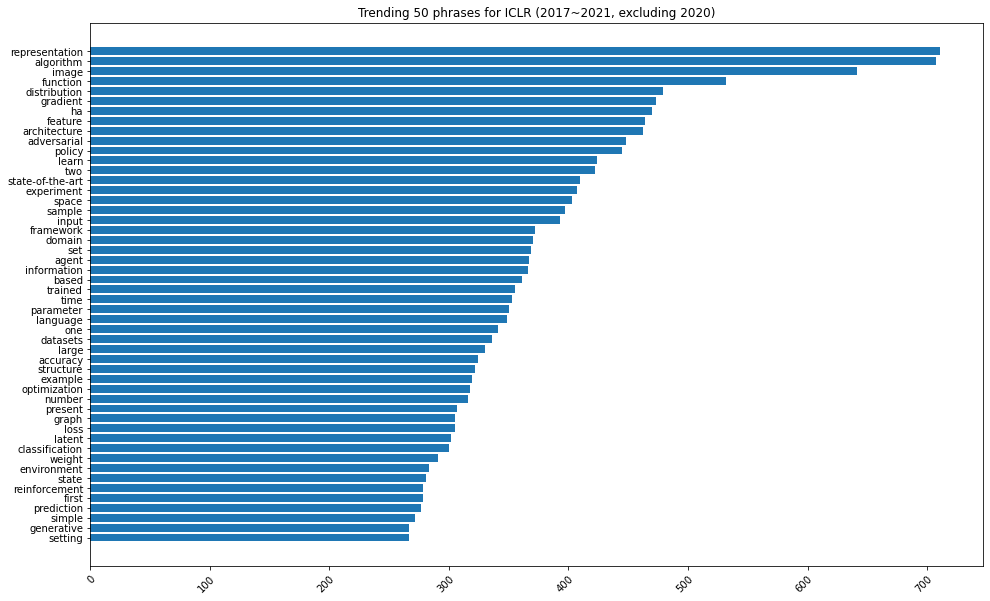

In [7]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 10))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for ICLR (2017~2021, excluding 2020)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [8]:
diversity_papers = data.loc[:, ("TITLE", "YEAR")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

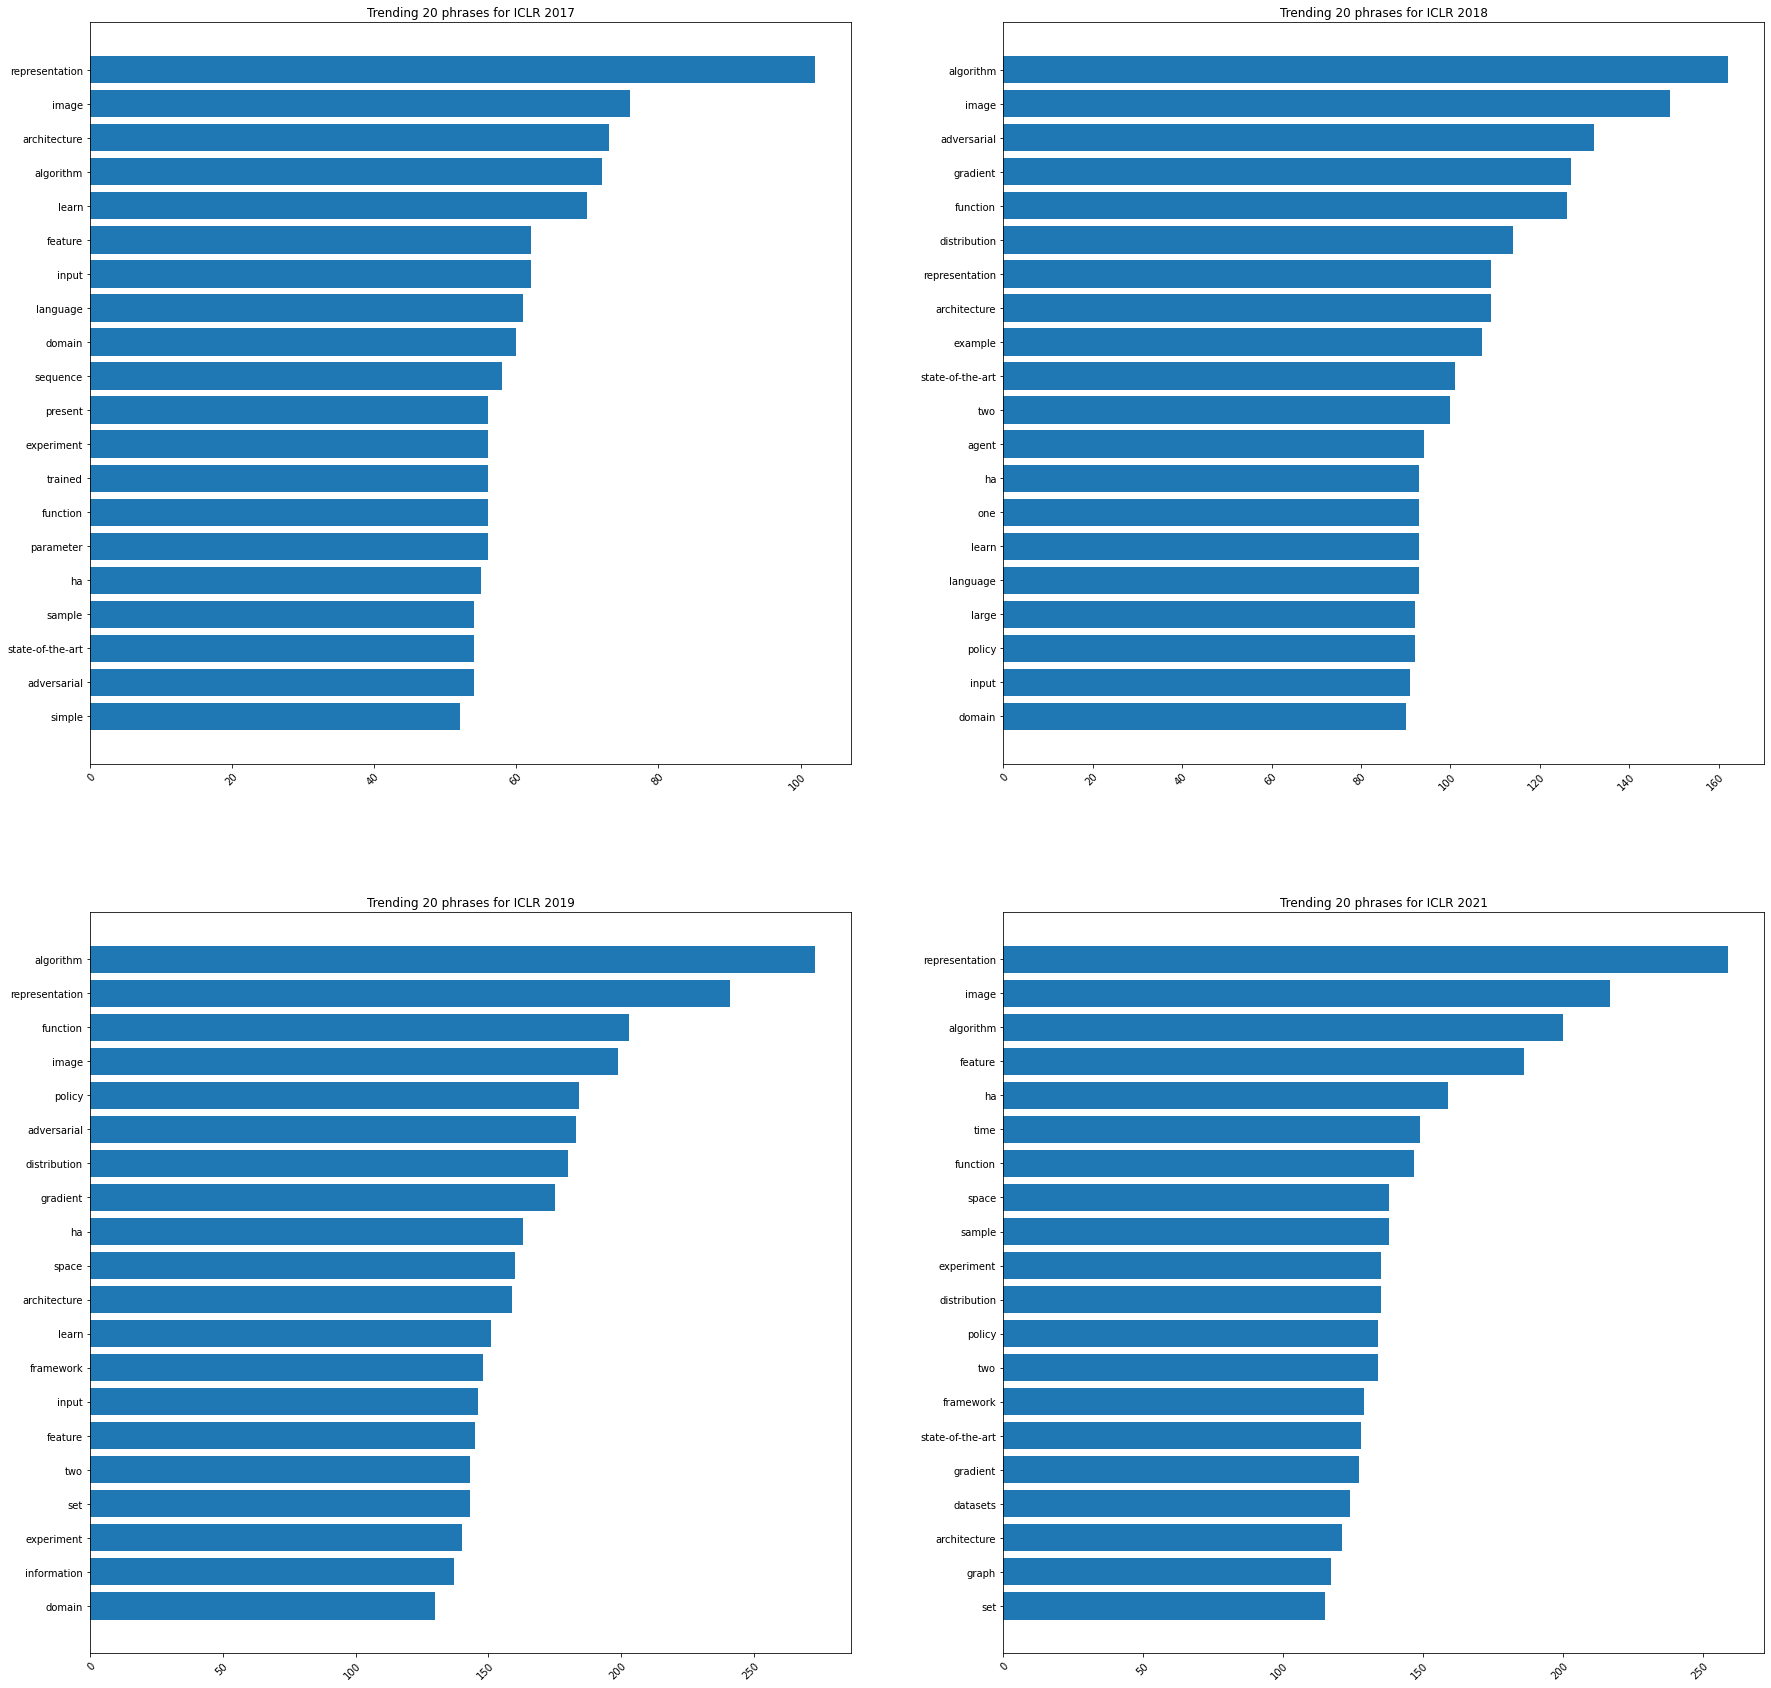

In [9]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.YEAR)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 20
fig, axes = plt.subplots(2, 2, figsize=(30, 30))
ax_count = 0
for year in range(2017, 2022):
    ax = axes.reshape(-1)[ax_count]
    if year == 2020:
        continue
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} phrases for ICLR {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax_count += 1

plt.show()

In [10]:
#number of topics
n_topics=6

from sklearn.decomposition import LatentDirichletAllocation
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=444, verbose=0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [11]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [12]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if isinstance(temp_vector_sum, int):
            print(topic)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(" ".join(topic_words))         
    return top_words

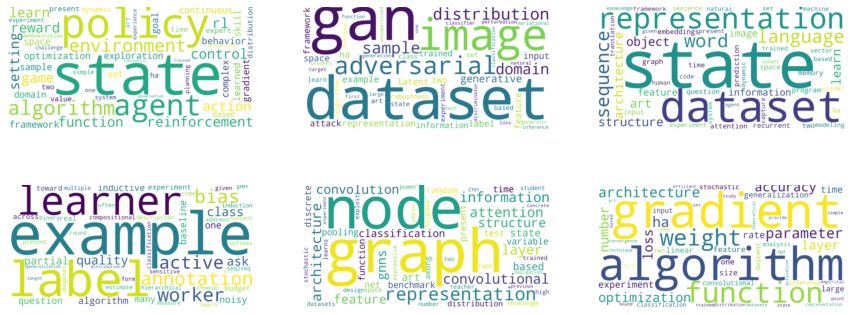

In [13]:
# Printing words from each topic
top_n_words = get_top_n_words(50, lda_keys, tf, tf_vectorizer)

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for tw, ax in zip(top_n_words, axes.reshape(-1)):
    wc = WordCloud(background_color="white", width=1600, height=800)
    wc.generate(tw)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
plt.show()

In [14]:
from sklearn.manifold import TSNE
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1497 samples in 0.001s...
[t-SNE] Computed neighbors for 1497 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1497
[t-SNE] Computed conditional probabilities for sample 1497 / 1497
[t-SNE] Mean sigma: 0.004764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.146999
[t-SNE] KL divergence after 2000 iterations: 0.385889


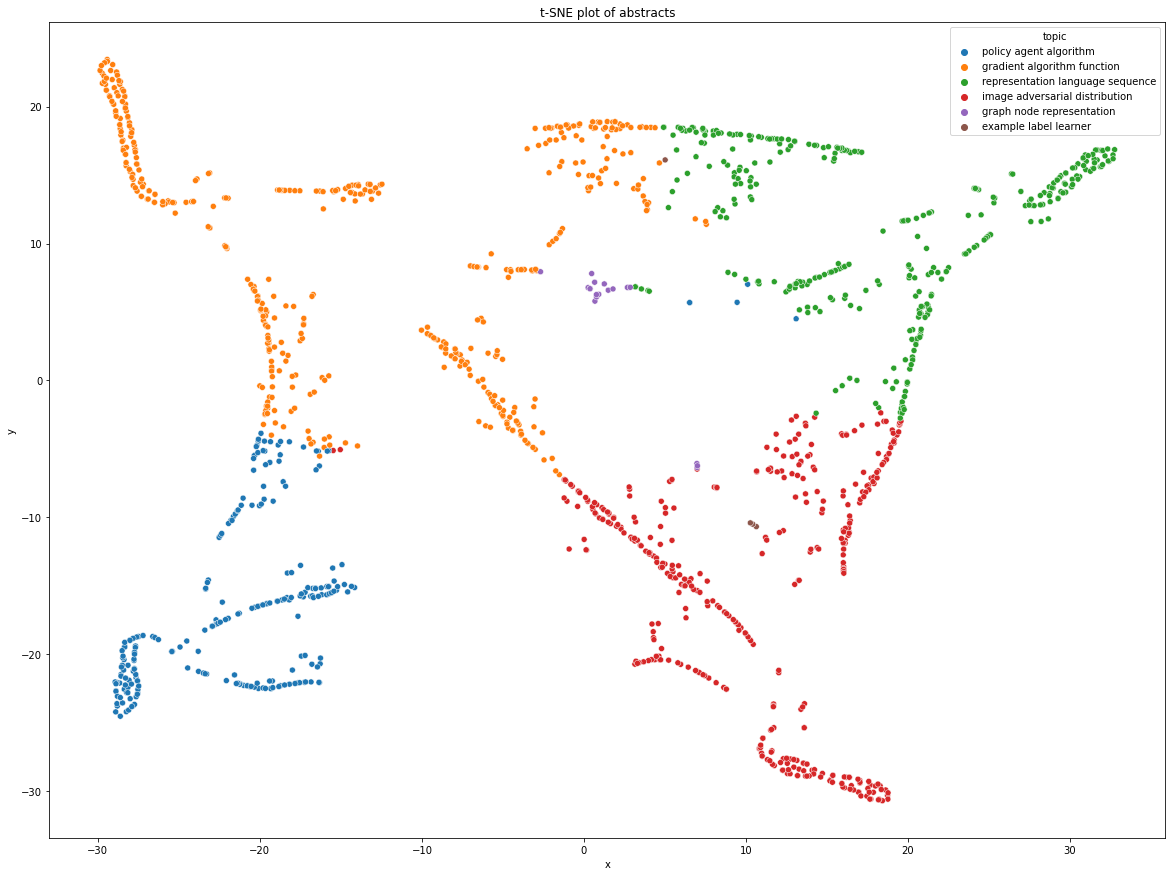

In [15]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

hue = []
for k in lda_keys:
    hue.append(top_3_words_lda[k])

disp_data = pd.DataFrame({'x': pd.Series(tsne_lda_vectors[:,0]), 'y': pd.Series(tsne_lda_vectors[:,1]), 'topic': pd.Series(hue)})
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(data=disp_data, x='x', y='y', hue='topic', ax=ax)
ax.set_title("t-SNE plot of abstracts")
plt.show()

In [16]:
for n in range(5):
    topic_most_pr = lda_topic_matrix[n].argsort()[-2:]
    print("Paper #{}: {}\n - top 2 topic: ({})+({})\n".format(n,title[n], top_3_words_lda[topic_most_pr[0]], top_3_words_lda[topic_most_pr[1]]))

Paper #0: Making Neural Programming Architectures Generalize via Recursion
 - top 2 topic: (representation language sequence)+(policy agent algorithm)

Paper #1: End-to-end Optimized Image Compression
 - top 2 topic: (image adversarial distribution)+(gradient algorithm function)

Paper #2: Optimization as a Model for Few-Shot Learning
 - top 2 topic: (policy agent algorithm)+(gradient algorithm function)

Paper #3: Learning End-to-End Goal-Oriented Dialog
 - top 2 topic: (image adversarial distribution)+(representation language sequence)

Paper #4: Towards Principled Methods for Training Generative Adversarial Networks
 - top 2 topic: (image adversarial distribution)+(gradient algorithm function)



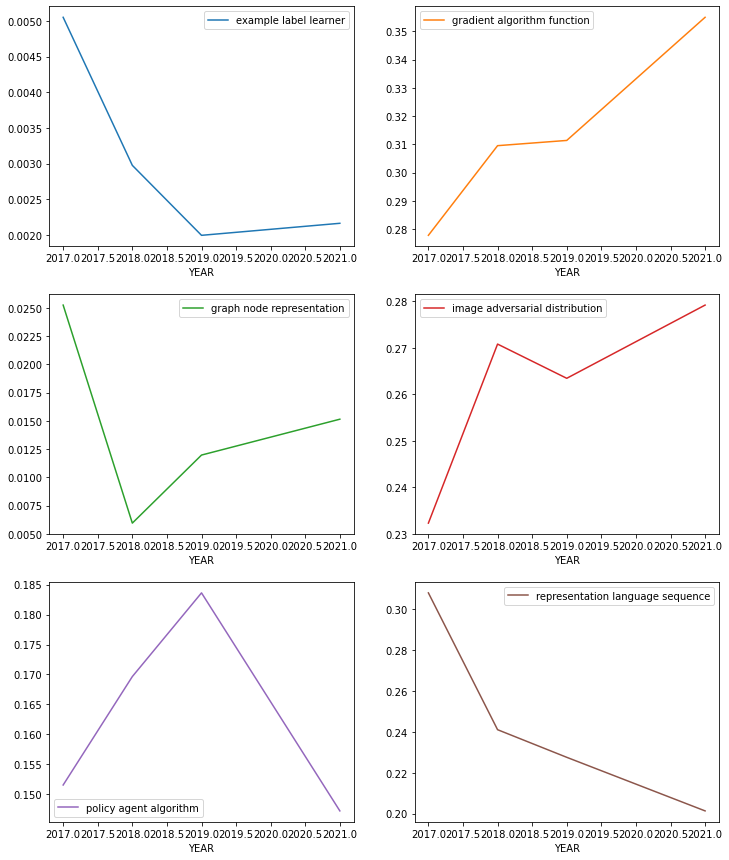

In [17]:
plt.rcParams['figure.figsize'] = (12,15)
lda_topics = [top_3_words_lda[k] for k in lda_keys]
# pd.crosstab(df_new['YEAR'], df_new['Dominant_Topic'], normalize='index').plot.bar(stacked=True)
pd.crosstab(data['YEAR'].astype(int), pd.Series(lda_topics).astype('category'), normalize='index').plot(kind='line', subplots=True, sharex=False, layout=(3, 2))
plt.show()

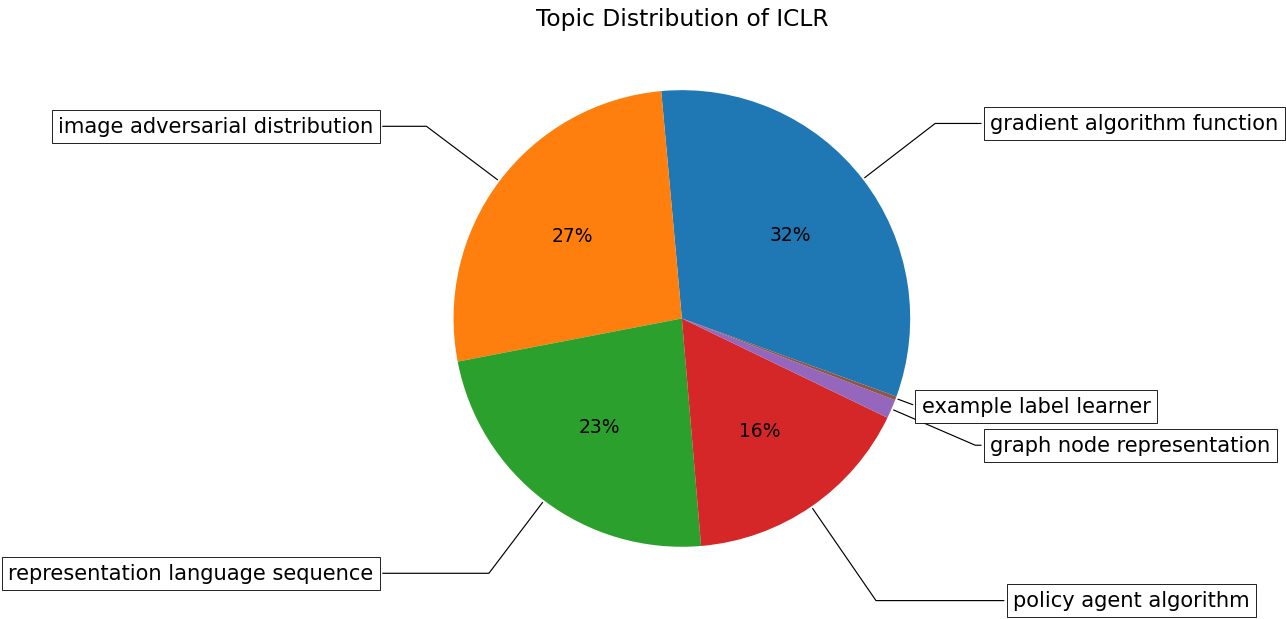

In [18]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

inds = np.flip(np.argsort(lda_counts))

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi=84)

values = np.array(lda_counts)[inds]
labels = np.array(top_3_words_lda)[lda_categories][inds]

# wedges, texts = ax.pie(np.array(lda_counts)[inds], wedgeprops=dict(width=1.0), startangle=-20)
wedges, texts, _ = ax.pie(values, wedgeprops=dict(width=1.0), startangle=-20, autopct=make_autopct(values), textprops={'fontsize': 16})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0, -0.3][i-3] if i > 2 else 0.0
    ax.annotate(labels[i], xy=(x, y), xytext=((1.35+offset)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title("Topic Distribution of ICLR", fontsize=20)

plt.show()

In [101]:
title_proc = []
for i in range(len(title)):
    t = title[i].strip().lower().translate(table).split()
    title_proc.append([lemm.lemmatize(w) for w in t])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tv = tfidf_vectorizer.fit_transform(title_proc)
tv_norm = normalize(tv, axis=1)

In [102]:
from scipy.spatial.distance import jensenshannon as js
def find_n_related(inp_t, inp_ab, n, alpha=0.5):
    assert isinstance(inp_t, str)
    assert isinstance(inp_ab, str)
    # preprocess
    t_proc = inp_t.strip().lower().translate(table).split()
    ab_proc = inp_ab.strip().lower().translate(table).split()
    t_proc = [lemm.lemmatize(w) for w in t_proc]
    ab_proc = [lemm.lemmatize(w) for w in ab_proc]

    t_vec = tfidf_vectorizer.transform([t_proc]).toarray()
    t_vec = normalize(t_vec, axis=1)
    # print(t_vec.shape)
    t_scores = np.matmul(tv_norm.toarray(), t_vec.T).squeeze()

    ab_vec = tf_vectorizer.transform([ab_proc]).toarray()
    logits = lda.transform(ab_vec)
    # ab_scores = np.matmul(lda_topic_matrix, logits.T).squeeze()
    ab_scores = 1 - np.array([js(v.squeeze(), logits.squeeze(), 2) for v in lda_topic_matrix])

    scores = alpha * t_scores + (1-alpha) * ab_scores
    inds = np.flip(np.argsort(scores))[:n]
    retrieved = data.loc[inds, :]
    retrieved["Score"] = scores[inds]

    return retrieved

In [103]:
# Temporal Localization of Moments in Video Collections with Natural Language (ICCV2019)
# https://arxiv.org/abs/1907.12763
test_t = "Temporal Localization of Moments in Video Collections with Natural Language"
test_abs = """In this paper, we introduce the task of retrieving relevant video moments from a large corpus of untrimmed, unsegmented videos given a natural language query.
Our task poses unique challenges as a system must efficiently identify both the relevant videos and localize the relevant moments in the videos.
This task is in contrast to prior work that localizes relevant moments in a single video or searches a large collection of already-segmented videos.
For our task, we introduce Clip Alignment with Language (CAL), a model that aligns features for a natural language query to a sequence of short video clips that compose a candidate moment in a video.
Our approach goes beyond prior work that aggregates video features over a candidate moment by allowing for finer clip alignment.
Moreover, our approach is amenable to efficient indexing of the resulting clip-level representations, which makes it suitable for moment localization in large video collections.
We evaluate our approach on three recently proposed datasets for temporal localization of moments in video with natural language extended to our video corpus moment retrieval setting: DiDeMo, Charades-STA, and ActivityNet-captions.
We show that our CAL model outperforms the recently proposed Moment Context Network (MCN) on all criteria across all datasets on our proposed task, obtaining an 8%-85% and 11%-47% boost for average recall and median rank, respectively,
and achieves 5x faster retrieval and 8x smaller index size with a 500K video corpus."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR}): {s.Score:.3f}")

Structured Prediction as Translation between Augmented Natural Languages (ICLR2021): 0.596
Decomposing Motion and Content for Natural Video Sequence Prediction (ICLR2017): 0.594
On Learning Universal Representations Across Languages (ICLR2021): 0.583
Learning to Count Objects in Natural Images for Visual Question Answering (ICLR2018): 0.582
Unsupervised Representation Learning for Time Series with Temporal Neighborhood Coding (ICLR2021): 0.574
GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding (ICLR2019): 0.558
Learning a Natural Language Interface with Neural Programmer (ICLR2017): 0.552
LeMoNADe: Learned Motif and Neuronal Assembly Detection in calcium imaging videos (ICLR2019): 0.551
Representation Degeneration Problem in Training Natural Language Generation Models (ICLR2019): 0.506
Representation learning for improved interpretability and classification accuracy of clinical factors from EEG (ICLR2021): 0.498


In [104]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16955 (AAAI2021)
test_t = "Adversarial Defence by Diversified Simultaneous Training of Deep Ensembles"
test_abs = """Learning-based classifiers are susceptible to adversarial examples. Existing defence methods are mostly devised on individual classifiers.
Recent studies showed that it is viable to increase adversarial robustness by promoting diversity over an ensemble of models.
In this paper, we propose adversarial defence by encouraging ensemble diversity on learning high-level feature representations and gradient dispersion in simultaneous training of deep ensemble networks.
We perform extensive evaluations under white-box and black-box attacks including transferred examples and adaptive attacks.
Our approach achieves a significant gain of up to 52% in adversarial robustness, compared with the baseline and the state-of-the-art method on image benchmarks with complex data scenes.
The proposed approach complements the defence paradigm of adversarial training, and can further boost the performance. The source code is available at https://github.com/ALIS-Lab/AAAI2021-PDD."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR}): {s.Score:.3f}")

Ensemble Adversarial Training: Attacks and Defenses (ICLR2018): 0.701
Multi-Domain Adversarial Learning (ICLR2019): 0.627
Mitigating Adversarial Effects Through Randomization (ICLR2018): 0.604
The Limitations of Adversarial Training and the Blind-Spot Attack (ICLR2019): 0.603
Adversarial Reprogramming of Neural Networks (ICLR2019): 0.572
Certifying Some Distributional Robustness with Principled Adversarial Training (ICLR2018): 0.568
SPIGAN: Privileged Adversarial Learning from Simulation (ICLR2019): 0.567
Shape-Texture Debiased Neural Network Training (ICLR2021): 0.557
Neural Photo Editing with Introspective Adversarial Networks (ICLR2017): 0.551
A Direct Approach to Robust Deep Learning Using Adversarial Networks (ICLR2019): 0.551


In [105]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16815 (AAAI2021)
test_t = "Learning Invariant Representations using Inverse Contrastive Loss"
test_abs = """Learning invariant representations is a critical first step in a number of machine learning tasks.
A common approach is given by the so-called information bottleneck principle in which an application dependent function of mutual information is carefully chosen and optimized.
Unfortunately, in practice, these functions are not suitable for optimization purposes since these losses are agnostic of the metric structure of the parameters of the model.
In our paper, we introduce a class of losses for learning representations that are invariant to some extraneous variable of interest by inverting the class of contrastive losses, i.e., inverse contrastive loss (ICL).
We show that if the extraneous variable is binary, then optimizing ICL is equivalent to optimizing a regularized MMD divergence.
More generally, we also show that if we are provided a metric on the sample space, our formulation of ICL can be decomposed into a sum of convex functions of the given distance metric.
Our experimental results indicate that models obtained by optimizing ICL achieve significantly better invariance to the extraneous variable for a fixed desired level of accuracy.
In a variety of experimental settings, we show applicability of ICL for learning invariant representations for both continuous and discrete protected/extraneous variables.
The project page with code is available at https://github.com/adityakumarakash/ICL"""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR}): {s.Score:.3f}")

Active Contrastive Learning of Audio-Visual Video Representations (ICLR2021): 0.653
Central Moment Discrepancy (CMD) for Domain-Invariant Representation Learning (ICLR2017): 0.608
Analyzing Inverse Problems with Invertible Neural Networks (ICLR2019): 0.530
Conditional Negative Sampling for Contrastive Learning of Visual Representations (ICLR2021): 0.529
Meta-Learning Update Rules for Unsupervised Representation Learning (ICLR2019): 0.519
Representation Learning via Invariant Causal Mechanisms (ICLR2021): 0.516
Prototypical Contrastive Learning of Unsupervised Representations (ICLR2021): 0.513
What Should Not Be Contrastive in Contrastive Learning (ICLR2021): 0.503
Improving MMD-GAN Training with Repulsive Loss Function (ICLR2019): 0.502
Deep Decoder: Concise Image Representations from Untrained Non-convolutional Networks (ICLR2019): 0.501


In [106]:
import pickle
with open("./saved_models/lda_iclr.pickle", 'wb') as f:
    pickle.dump(lda, f)

In [107]:
np.save("./saved_models/matrix_iclr.npy", lda_topic_matrix)

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('./data/cvpr_16-21.csv')
data.info()
abstract = list(data.Abstract)
title = list(data.TITLE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6869 entries, 0 to 6868
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    6869 non-null   int64  
 1   YEAR          6869 non-null   int64  
 2   TITLE         6869 non-null   object 
 3   Authors       6869 non-null   object 
 4   Abstract      6869 non-null   object 
 5   Affiliations  6865 non-null   object 
 6   Citations     5018 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 375.8+ KB


In [3]:
data.head(4)

Unnamed: 0  YEAR                                              TITLE  \
0           0  2016  Estimating Sparse Signals with Smooth Support ...   
1           1  2016                 Parametric Object Motion from Blur   
2           2  2016  Unsupervised Learning of Discriminative Attrib...   
3           4  2016                                 Symmetry reCAPTCHA   

                            Authors  \
0  S. Shah; T. Goldstein; C. Studer   
1      J. Gast; A. Sellent; S. Roth   
2      C. Huang; C. C. Loy; X. Tang   
3                   C. Funk; Y. Liu   

                                            Abstract  \
0  Conventional algorithms for sparse signal reco...   
1  Motion blur can adversely affect a number of v...   
2  Attributes offer useful mid-level features to ...   
3  This paper is a reaction to the poor performan...   

                                        Affiliations  Citations  
0  ['Univ. of Maryland, College Park, MD, USA', '...        NaN  
1                                 ['NA', 'NA', 'NA']        8.0  
2  ['Dept. of Inf. Eng., Chinese Univ. of Hong Ko...       30.0  
3  ['Sch. of Electr. Eng. & Comput. Sci., Pennsyl...       12.0

In [4]:
samples = data.sample(4)
for _, s in samples.iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR})")
    print(f"Abstract: {s.Abstract}\n")

STCT: Sequentially Training Convolutional Networks for Visual Tracking (CVPR2016)
Abstract: Due to the limited amount of training samples, finetuning pre-trained deep models online is prone to overfitting. In this paper, we propose a sequential training method for convolutional neural networks (CNNs) to effectively transfer pre-trained deep features for online applications. We regard a CNN as an ensemble with each channel of the output feature map as an individual base learner. Each base learner is trained using different loss criterions to reduce correlation and avoid over-training. To achieve the best ensemble online, all the base learners are sequentially sampled into the ensemble via important sampling. To further improve the robustness of each base learner, we propose to train the convolutional layers with random binary masks, which serves as a regularization to enforce each base learner to focus on different input features. The proposed online training method is applied to visual

In [5]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", \
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [6]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

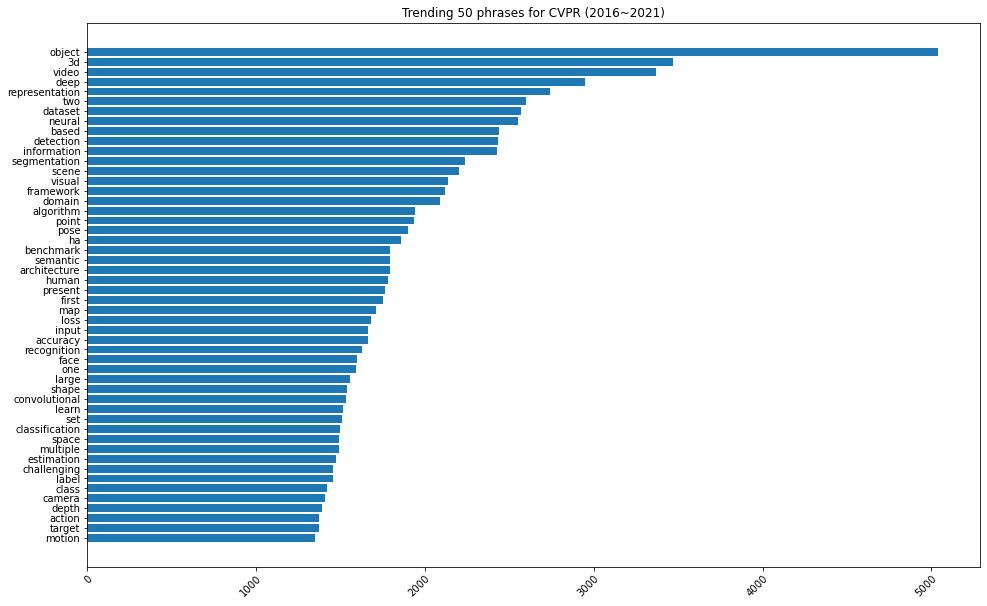

In [7]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 10))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for CVPR (2016~2021)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [8]:
diversity_papers = data.loc[:, ("TITLE", "YEAR")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

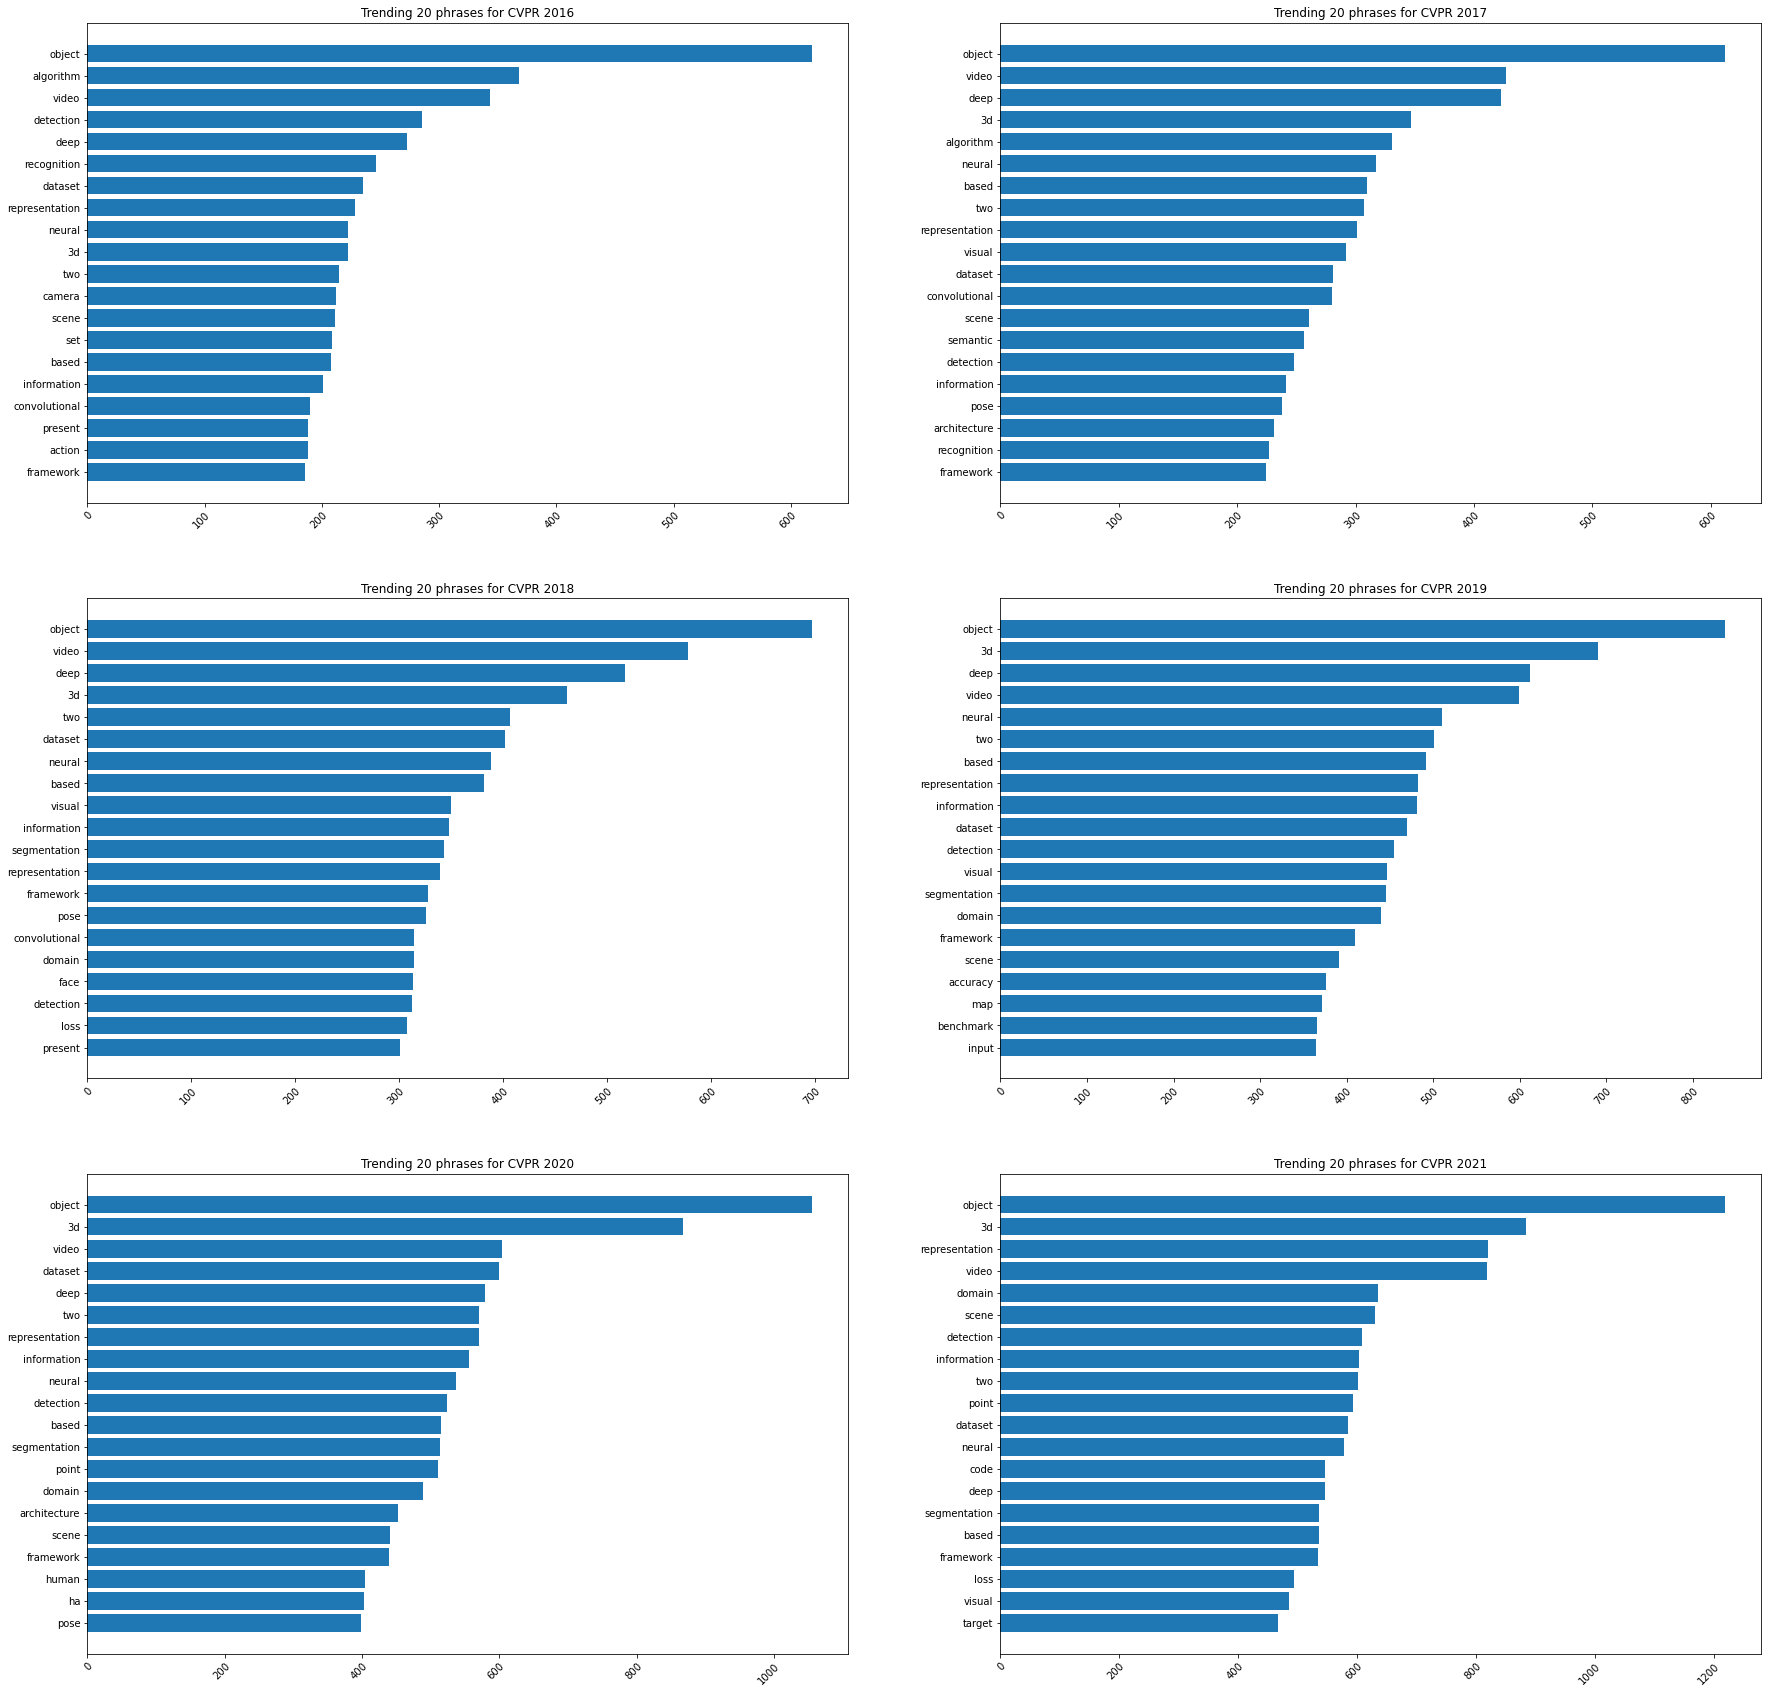

In [9]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.YEAR)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 20
fig, axes = plt.subplots(3, 2, figsize=(30, 30))
for year, ax in zip(range(2016, 2022), axes.reshape(-1)):
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} phrases for CVPR {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

plt.show()

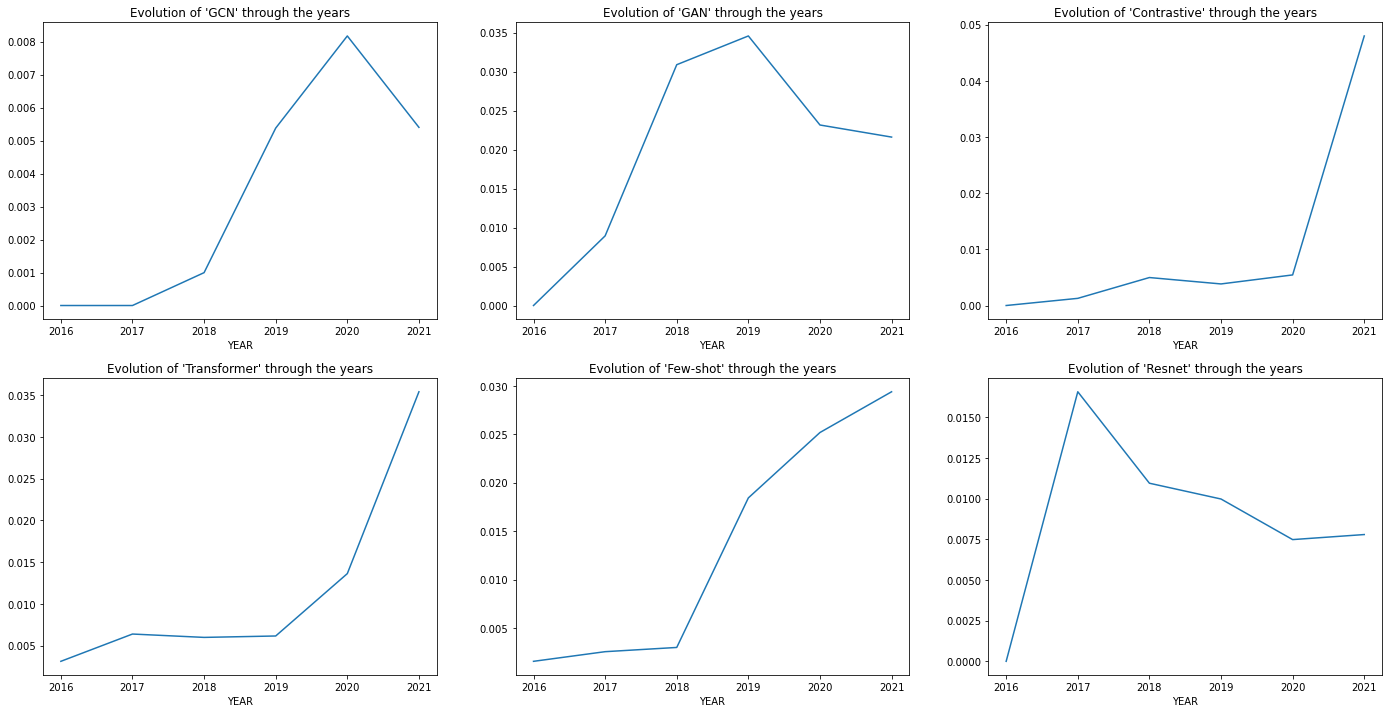

In [10]:
def trace_word_popularity(word):
    assert isinstance(word, str)
    word = word.strip().lower().translate(table)
    assert isinstance(diversity_papers, pd.DataFrame)
    is_word_in_list = np.array([feat==word for feat in tf_vectorizer.get_feature_names_out()])
    if not is_word_in_list.any():
        raise Exception("Couldn't find the word you were looking for.")
        
    if len(word.split()) > 1:
        raise Exception("Must be a 1 word long token separated by spaces.")
    
    total = diversity_papers.groupby('YEAR').count()

    word_idx = np.argwhere(is_word_in_list).item()
    count_df = (diversity_papers.groupby('YEAR').sum().n_themes
                .apply(lambda row: np.array(row))
                .apply(lambda row: row[row == word_idx].size).div(total.n_themes))
    return count_df

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
test_words = ["GCN", "GAN", "Contrastive", "Transformer", "Few-shot", "Resnet"]
for w, ax in zip(test_words, axes.reshape(-1)):
    counts = trace_word_popularity(w)
    counts.plot(ax=ax)
    ax.set_xticks(range(2016, 2022))
    ax.set_title(f"Evolution of '{w}' through the years")

In [11]:
#number of topics
n_topics=8

from sklearn.decomposition import LatentDirichletAllocation
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=321, verbose=0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [12]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [13]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if isinstance(temp_vector_sum, int):
            print(topic)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

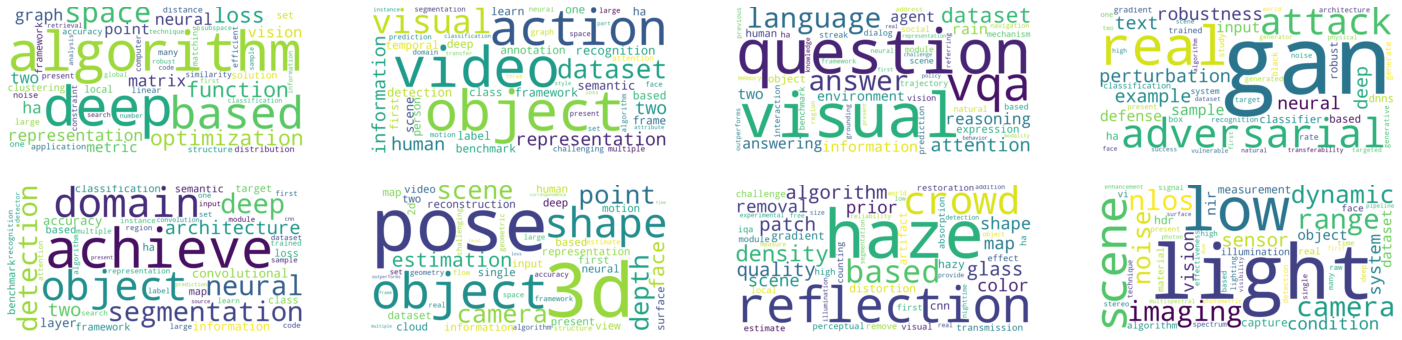

In [14]:
# Printing words from each topic
top_n_words = get_top_n_words(50, lda_keys, tf, tf_vectorizer)

fig, axes = plt.subplots(2, 4, figsize=(25, 6))
for tw, ax in zip(top_n_words, axes.reshape(-1)):
    wc = WordCloud(background_color="white", width=1600, height=800)
    wc.generate(tw)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
plt.show()

In [15]:
from sklearn.manifold import TSNE
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6869 samples in 0.004s...
[t-SNE] Computed neighbors for 6869 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6869
[t-SNE] Computed conditional probabilities for sample 2000 / 6869
[t-SNE] Computed conditional probabilities for sample 3000 / 6869
[t-SNE] Computed conditional probabilities for sample 4000 / 6869
[t-SNE] Computed conditional probabilities for sample 5000 / 6869
[t-SNE] Computed conditional probabilities for sample 6000 / 6869
[t-SNE] Computed conditional probabilities for sample 6869 / 6869
[t-SNE] Mean sigma: 0.011380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.892059
[t-SNE] KL divergence after 2000 iterations: 0.969708


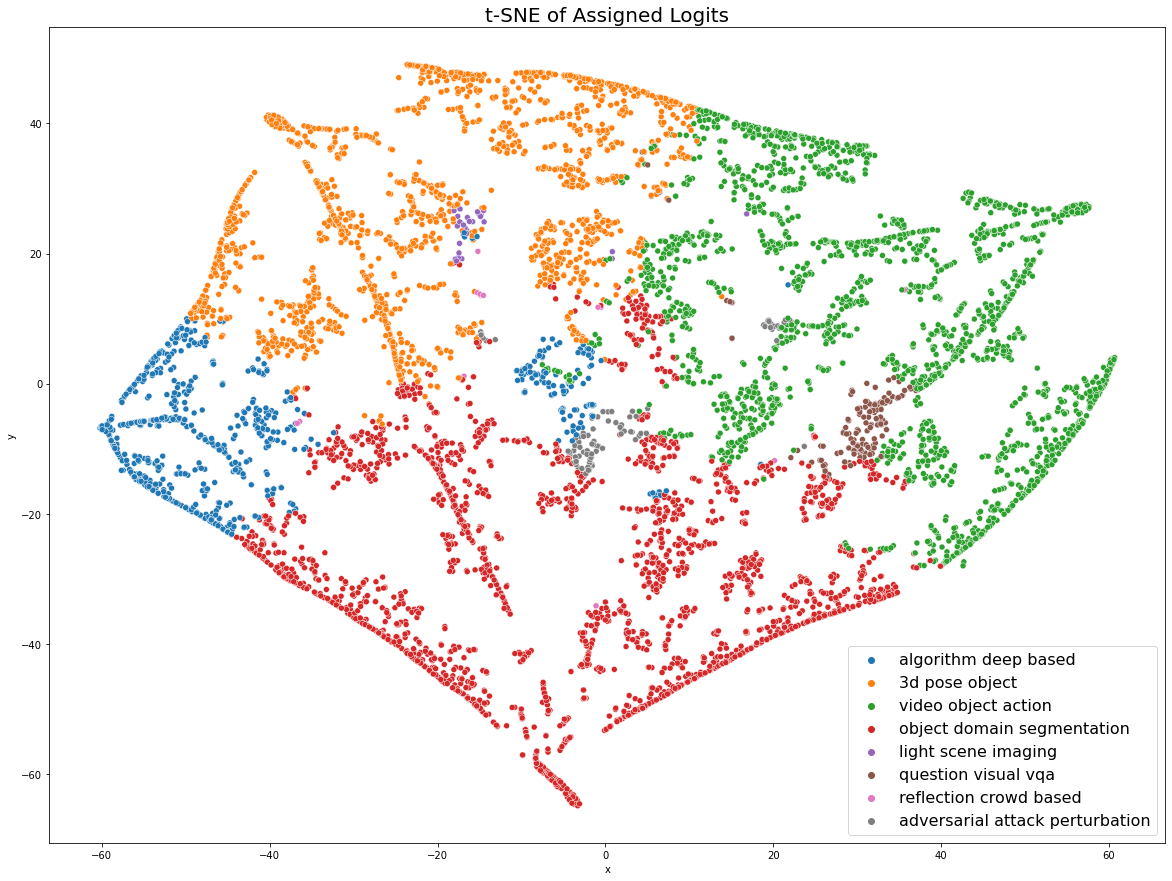

In [16]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

hue = []
for k in lda_keys:
    hue.append(top_3_words_lda[k])

disp_data = pd.DataFrame({'x': pd.Series(tsne_lda_vectors[:,0]), 'y': pd.Series(tsne_lda_vectors[:,1]), 'topic': pd.Series(hue)})
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(data=disp_data, x='x', y='y', hue='topic', ax=ax)
ax.set_title("t-SNE of Assigned Logits", fontsize=20)
ax.legend(loc="lower right", prop={'size':16})
plt.show()

In [17]:
for n in range(5):
    topic_most_pr = lda_topic_matrix[n].argsort()[-2:]
    print("Paper #{}: {}\n - top 2 topic: ({})+({})\n".format(n,title[n], top_3_words_lda[topic_most_pr[0]], top_3_words_lda[topic_most_pr[1]]))

Paper #0: Estimating Sparse Signals with Smooth Support via Convex Programming and Block Sparsity
 - top 2 topic: (object domain segmentation)+(algorithm deep based)

Paper #1: Parametric Object Motion from Blur
 - top 2 topic: (object domain segmentation)+(3d pose object)

Paper #2: Unsupervised Learning of Discriminative Attributes and Visual Representations
 - top 2 topic: (object domain segmentation)+(video object action)

Paper #3: Symmetry reCAPTCHA
 - top 2 topic: (reflection crowd based)+(video object action)

Paper #4: Predicting Motivations of Actions by Leveraging Text
 - top 2 topic: (question visual vqa)+(video object action)



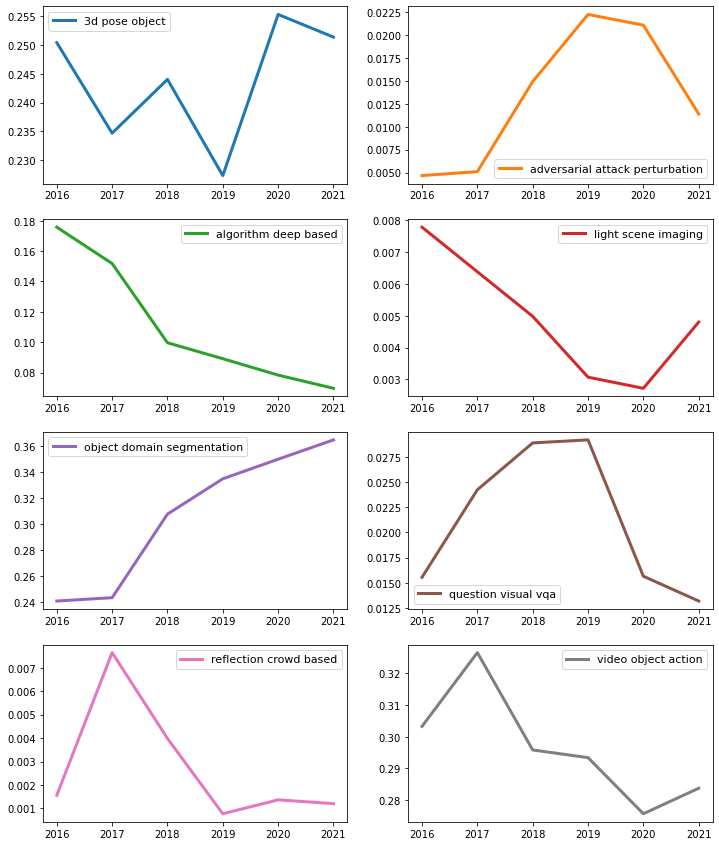

In [18]:
plt.rcParams['figure.figsize'] = (12,15)
lda_topics = [top_3_words_lda[k] for k in lda_keys]
# pd.crosstab(df_new['YEAR'], df_new['Dominant_Topic'], normalize='index').plot.bar(stacked=True)
axes = pd.crosstab(data['YEAR'].astype(int), pd.Series(lda_topics).astype('category'), normalize='index').plot(kind='line', subplots=True, sharex=False, linewidth=3, layout=(4, 2))
for ax in axes.reshape(-1):
    ax.set_xlabel("")
    ax.legend(prop={"size":11})
plt.show()

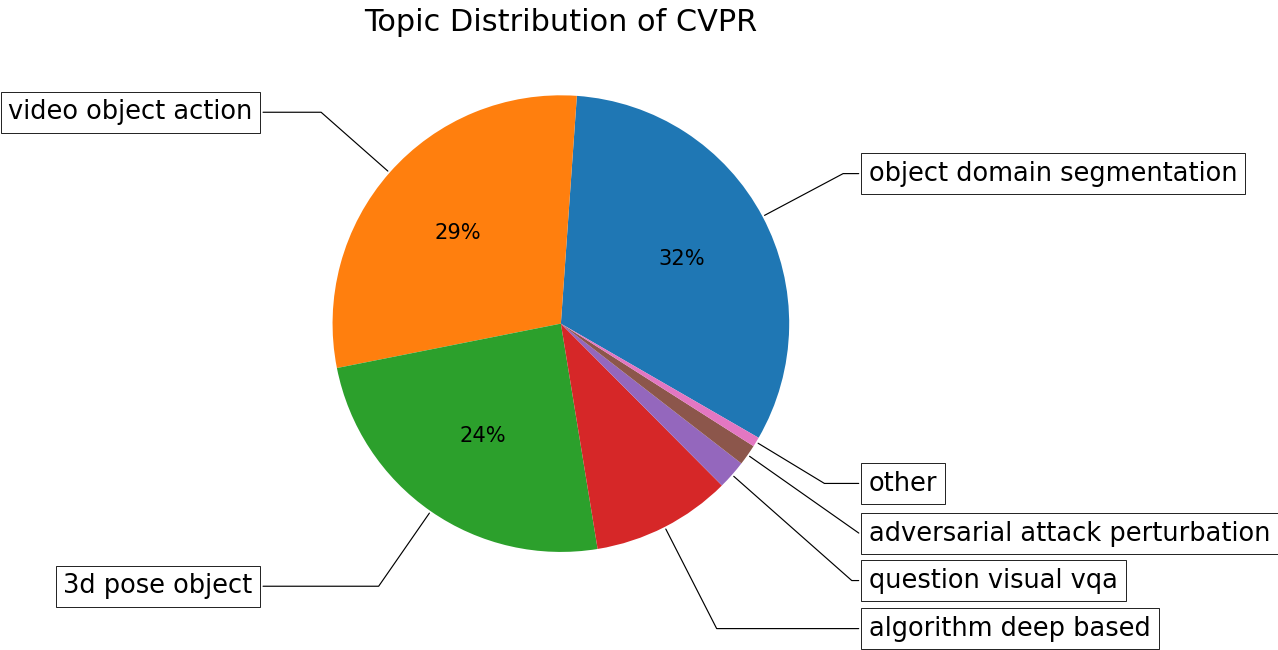

In [30]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=round(pct))
        else:
            return ''
    return my_autopct

inds = np.flip(np.argsort(lda_counts))

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi=84)

labels = np.array(top_3_words_lda)[lda_categories][inds]
labels = labels[:-1]
labels[-1] = "other"

values = np.array(lda_counts)[inds]
last = values[-2] + values[-1]
values = values[:-1]
values[-1] = last

wedges, texts, _ = ax.pie(values, wedgeprops=dict(width=1.0), startangle=-30, autopct=make_autopct(values), textprops={'fontsize': 18})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    if i > 6:
        break
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0.3, 0.2, -0.05, -0.32][i-3] if i > 2 else 0.0
    ax.annotate(labels[i], xy=(x, y), xytext=((1.35)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=22, **kw)

ax.set_title("Topic Distribution of CVPR", fontsize=26)

plt.show()

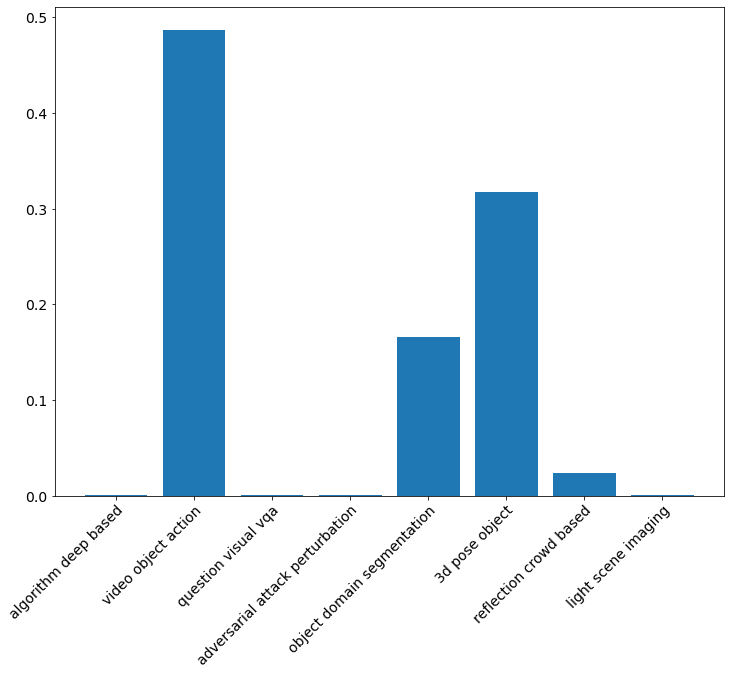

Coherent Parametric Contours for Interactive Video Object Segmentation
Interactive video segmentation systems aim at producing sub-pixel-level object boundaries for visual effect applications. Recent approaches mainly focus on using sparse user input (i.e. scribbles) for efficient segmentation, however, the quality of the final object boundaries is not satisfactory for the following reasons: (1) the boundary on each frame is often not accurate, (2) boundaries across adjacent frames wiggle around inconsistently, causing temporal flickering, and (3) there is a lack of direct user control for fine tuning. We propose Coherent Parametric Contours, a novel video segmentation propagation framework that addresses all the above issues. Our approach directly models the object boundary using a set of parametric curves, providing direct user controls for manual adjustment. A spatiotemporal optimization algorithm is employed to produce object boundaries that are spatially accurate and temporally st

In [20]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(x=top_3_words_lda, height=lda_topic_matrix[6])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()
print(title[6])
print(abstract[6])

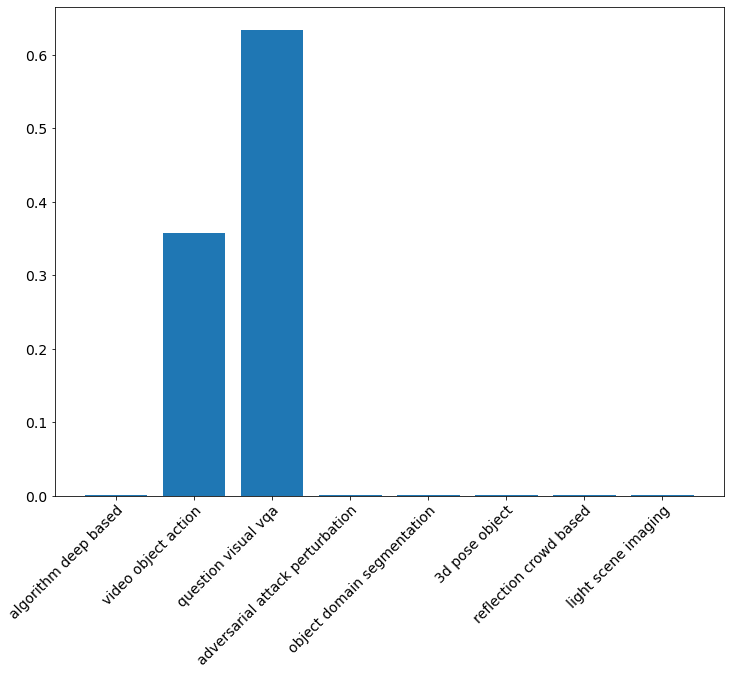

Visual7W: Grounded Question Answering in Images


In [21]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(x=top_3_words_lda, height=lda_topic_matrix[26])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()
print(title[26])

In [22]:
title_proc = []
for i in range(len(title)):
    t = title[i].strip().lower().translate(table).split()
    title_proc.append([lemm.lemmatize(w) for w in t])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tv = tfidf_vectorizer.fit_transform(title_proc)
tv_norm = normalize(tv, axis=1)

In [23]:
from scipy.spatial.distance import jensenshannon as js
def find_n_related(inp_t, inp_ab, n, alpha=0.5):
    assert isinstance(inp_t, str)
    assert isinstance(inp_ab, str)
    # preprocess
    t_proc = inp_t.strip().lower().translate(table).split()
    ab_proc = inp_ab.strip().lower().translate(table).split()
    t_proc = [lemm.lemmatize(w) for w in t_proc]
    ab_proc = [lemm.lemmatize(w) for w in ab_proc]

    t_vec = tfidf_vectorizer.transform([t_proc]).toarray()
    t_vec = normalize(t_vec, axis=1)
    # print(t_vec.shape)
    t_scores = np.matmul(tv_norm.toarray(), t_vec.T).squeeze()

    ab_vec = tf_vectorizer.transform([ab_proc]).toarray()
    logits = lda.transform(ab_vec)
    # ab_scores = np.matmul(lda_topic_matrix, logits.T).squeeze()
    ab_scores = 1 - np.array([js(v.squeeze(), logits.squeeze(), 2) for v in lda_topic_matrix])

    scores = alpha * t_scores + (1-alpha) * ab_scores
    inds = np.flip(np.argsort(scores))[:n]
    retrieved = data.loc[inds, :]
    retrieved["Score"] = scores[inds]

    return retrieved

In [24]:
# Temporal Localization of Moments in Video Collections with Natural Language (ICCV2019)
# https://arxiv.org/abs/1907.12763
test_t = "Temporal Localization of Moments in Video Collections with Natural Language"
test_abs = """In this paper, we introduce the task of retrieving relevant video moments from a large corpus of untrimmed, unsegmented videos given a natural language query.
Our task poses unique challenges as a system must efficiently identify both the relevant videos and localize the relevant moments in the videos.
This task is in contrast to prior work that localizes relevant moments in a single video or searches a large collection of already-segmented videos.
For our task, we introduce Clip Alignment with Language (CAL), a model that aligns features for a natural language query to a sequence of short video clips that compose a candidate moment in a video.
Our approach goes beyond prior work that aggregates video features over a candidate moment by allowing for finer clip alignment.
Moreover, our approach is amenable to efficient indexing of the resulting clip-level representations, which makes it suitable for moment localization in large video collections.
We evaluate our approach on three recently proposed datasets for temporal localization of moments in video with natural language extended to our video corpus moment retrieval setting: DiDeMo, Charades-STA, and ActivityNet-captions.
We show that our CAL model outperforms the recently proposed Moment Context Network (MCN) on all criteria across all datasets on our proposed task, obtaining an 8%-85% and 11%-47% boost for average recall and median rank, respectively,
and achieves 5x faster retrieval and 8x smaller index size with a 500K video corpus."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR}): {s.Score:.3f}")

MAN: Moment Alignment Network for Natural Language Moment Retrieval via Iterative Graph Adjustment (CVPR2019): 0.644
Structured Multi-Level Interaction Network for Video Moment Localization via Language Query (CVPR2021): 0.603
Person Search with Natural Language Description (CVPR2017): 0.578
Tracking by Natural Language Specification (CVPR2017): 0.573
Read and Attend: Temporal Localisation in Sign Language Videos (CVPR2021): 0.567
Temporal Action Detection Using a Statistical Language Model (CVPR2016): 0.556
Natural Language Object Retrieval (CVPR2016): 0.553
Benchmarking Representation Learning for Natural World Image Collections (CVPR2021): 0.548
Spoken Moments: Learning Joint Audio-Visual Representations from Video Descriptions (CVPR2021): 0.527
Multi-stage Aggregated Transformer Network for Temporal Language Localization in Videos (CVPR2021): 0.524


In [25]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16955 (AAAI2021)
test_t = "Adversarial Defence by Diversified Simultaneous Training of Deep Ensembles"
test_abs = """Learning-based classifiers are susceptible to adversarial examples. Existing defence methods are mostly devised on individual classifiers.
Recent studies showed that it is viable to increase adversarial robustness by promoting diversity over an ensemble of models.
In this paper, we propose adversarial defence by encouraging ensemble diversity on learning high-level feature representations and gradient dispersion in simultaneous training of deep ensemble networks.
We perform extensive evaluations under white-box and black-box attacks including transferred examples and adaptive attacks.
Our approach achieves a significant gain of up to 52% in adversarial robustness, compared with the baseline and the state-of-the-art method on image benchmarks with complex data scenes.
The proposed approach complements the defence paradigm of adversarial training, and can further boost the performance. The source code is available at https://github.com/ALIS-Lab/AAAI2021-PDD."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR}): {s.Score:.3f}")

Class-Aware Robust Adversarial Training for Object Detection (CVPR2021): 0.575
Efficient Adversarial Training With Transferable Adversarial Examples (CVPR2020): 0.530
Adversarial Robustness under Long-Tailed Distribution (CVPR2021): 0.521
On the Robustness of Semantic Segmentation Models to Adversarial Attacks (CVPR2018): 0.521
Ensemble Generative Cleaning With Feedback Loops for Defending Adversarial Attacks (CVPR2020): 0.516
Single-Step Adversarial Training With Dropout Scheduling (CVPR2020): 0.513
A Self-supervised Approach for Adversarial Robustness (CVPR2020): 0.485
Handwriting Recognition in Low-Resource Scripts Using Adversarial Learning (CVPR2019): 0.485
Generative Adversarial Perturbations (CVPR2018): 0.474
Stacked Generative Adversarial Networks (CVPR2017): 0.474


In [26]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16815 (AAAI2021)
test_t = "Learning Invariant Representations using Inverse Contrastive Loss"
test_abs = """Learning invariant representations is a critical first step in a number of machine learning tasks.
A common approach is given by the so-called information bottleneck principle in which an application dependent function of mutual information is carefully chosen and optimized.
Unfortunately, in practice, these functions are not suitable for optimization purposes since these losses are agnostic of the metric structure of the parameters of the model.
In our paper, we introduce a class of losses for learning representations that are invariant to some extraneous variable of interest by inverting the class of contrastive losses, i.e., inverse contrastive loss (ICL).
We show that if the extraneous variable is binary, then optimizing ICL is equivalent to optimizing a regularized MMD divergence.
More generally, we also show that if we are provided a metric on the sample space, our formulation of ICL can be decomposed into a sum of convex functions of the given distance metric.
Our experimental results indicate that models obtained by optimizing ICL achieve significantly better invariance to the extraneous variable for a fixed desired level of accuracy.
In a variety of experimental settings, we show applicability of ICL for learning invariant representations for both continuous and discrete protected/extraneous variables.
The project page with code is available at https://github.com/adityakumarakash/ICL"""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR}): {s.Score:.3f}")

Learning an Invariant Hilbert Space for Domain Adaptation (CVPR2017): 0.554
The Multiverse Loss for Robust Transfer Learning (CVPR2016): 0.541
A Graph Regularized Deep Neural Network for Unsupervised Image Representation Learning (CVPR2017): 0.532
Understanding the Behaviour of Contrastive Loss (CVPR2021): 0.526
Adversarial Invariant Learning (CVPR2021): 0.515
Exploring Complementary Strengths of Invariant and Equivariant Representations for Few-Shot Learning (CVPR2021): 0.512
Wasserstein Contrastive Representation Distillation (CVPR2021): 0.512
A Sufficient Condition for Convergences of Adam and RMSProp (CVPR2019): 0.490
Circle Loss: A Unified Perspective of Pair Similarity Optimization (CVPR2020): 0.490
Unsupervised Embedding Learning via Invariant and Spreading Instance Feature (CVPR2019): 0.490


In [27]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


Text(0.5, 1.0, 'Prof. N. Vasconcelos interested in')

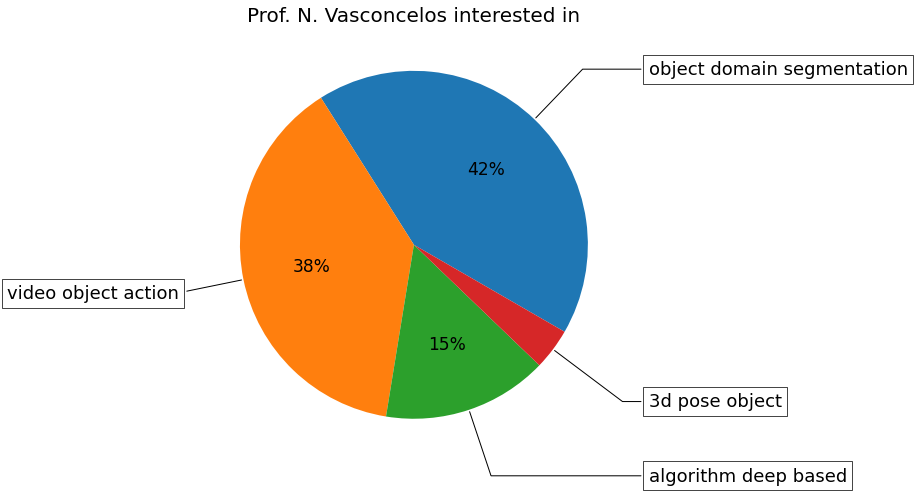

In [28]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

test_auth = 'N. Vasconcelos'
authors = list(data.Authors.values)
authors = [[a_.strip() for a_ in a.split(";")] for a in authors]
out_topics = []
for i, a in enumerate(authors):
    if test_auth in a:
        out_topics.append(top_3_words_lda[lda_keys[i]])
topic_counts = pd.Series(out_topics).value_counts()
fig, ax = plt.subplots(figsize=(8, 8))
# ax.pie(topic_counts.values, labels=topic_counts.index, textprops={'fontsize': 16}, autopct='%1.f%%', colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# ax.set_ylabel("")
# ax.set_title(f"Prof. {test_auth} interested in", fontsize=20)

wedges, texts, _ = ax.pie(topic_counts.values, wedgeprops=dict(width=1.0), startangle=-30, autopct=make_autopct(values), textprops={'fontsize': 17}, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    if i > 6:
        break
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0.3, 0.2, -0.05, -0.32][i-3] if i > 2 else 0.0
    ax.annotate(topic_counts.index[i], xy=(x, y), xytext=((1.35)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title(f"Prof. {test_auth} interested in", fontsize=20)

Text(0.5, 1.0, 'Stanford Univ. interested in')

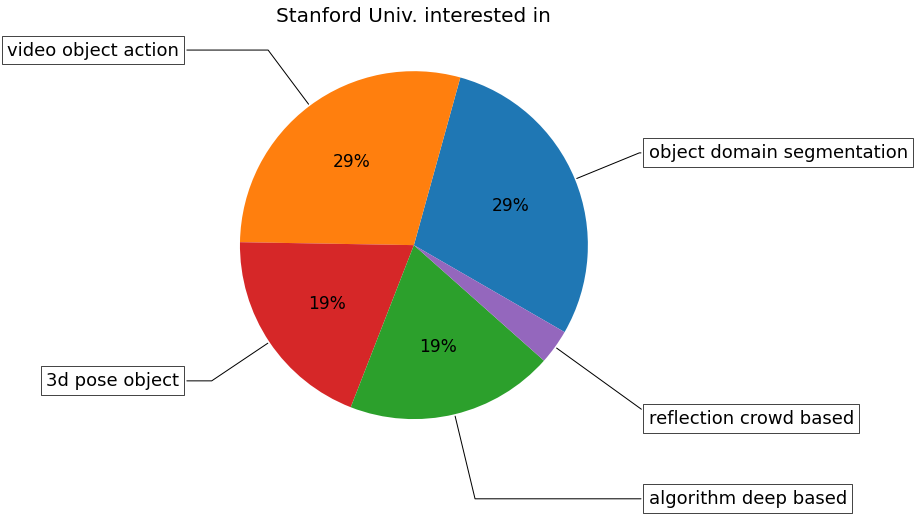

In [29]:
test_aff = 'Stanford Univ., Stanford, CA, USA'
affs = list(data.Affiliations.values)
affs = [[a_.strip() for a_ in a.split("'")] for a in affs if isinstance(a, str)]
out_topics = []
for i, a in enumerate(affs):
    if test_aff in a:
        out_topics.append(top_3_words_lda[lda_keys[i]])
topic_counts = pd.Series(out_topics).value_counts()
fig, ax = plt.subplots(figsize=(8, 8))
# ax.pie(topic_counts.values, labels=topic_counts.index, textprops={'fontsize': 16}, autopct='%1.f%%', colors=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd'])
# ax.set_ylabel("")

wedges, texts, _ = ax.pie(topic_counts.values, wedgeprops=dict(width=1.0), startangle=-30, autopct=make_autopct(values), textprops={'fontsize': 17}, colors=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    if i > 6:
        break
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0.3, 0.2, -0.05, -0.32][i-3] if i > 2 else 0.0
    ax.annotate(topic_counts.index[i], xy=(x, y), xytext=((1.35)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title(f"{test_aff.split(',')[0]} interested in", fontsize=20)

In [96]:
pd.Series(out_topics).value_counts().values

array([9, 9, 6, 6, 1])

In [30]:
import pickle
with open("./saved_models/lda_cvpr.pickle", 'wb') as f:
    pickle.dump(lda, f)

In [31]:
np.save("./saved_models/matrix_cvpr.npy", lda_topic_matrix)

{2016: 643, 2017: 784, 2018: 1004, 2019: 1302, 2020: 1469, 2021: 1667}
6869
[76.34299025 21.92458873  1.68874654]


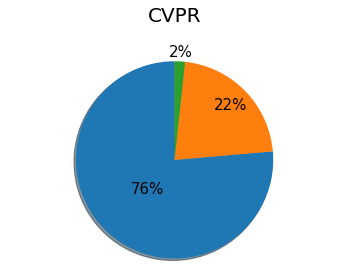

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
import pandas as pd
from matplotlib import cm
from IPython.display import display, HTML
import operator as op

df_cvpr = pd.read_csv('cvpr_data.csv')
df_cvpr_citations = pd.read_csv('cvpr_citations.csv')
years_cvpr = df_cvpr['YEAR'].unique()
pub_per_year_cvpr = dict()
for i in years_cvpr: 
    pub_per_year_cvpr.update({i:0})

for i in range(len(df_cvpr)): 
    pub_per_year_cvpr[df_cvpr['YEAR'][i]] +=1
    
sum_cvpr = 0

for keys,values in pub_per_year_cvpr.items():
    sum_cvpr = sum_cvpr + values

print (pub_per_year_cvpr)
print (sum_cvpr)
citations_cvpr = df_cvpr_citations['citations']

labels = 'less than 100', '100-1000', 'more than 1000'
new_bins = [0, 100, 1000,40000]
cvpr_modified = np.histogram(citations_cvpr,new_bins)
c2017_cvpr_normalized = cvpr_modified[0]/sum_cvpr

sizes = []
sizes = c2017_cvpr_normalized * 100
print (sizes)
explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.set_title('CVPR',fontsize=20,pad=30)
patches, texts, autotexts = ax1.pie(sizes, explode=explode, autopct='%1.0f%%',
        shadow=True, startangle=90,textprops={'fontsize': 15},labeldistance=1.2, pctdistance=1)

pctdists = [.4, 0.8, 1.1]

for t,d in zip(autotexts, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig('Citation_Distribution_2017_CVPR.png')

{2016: 568, 2017: 679, 2018: 1009, 2019: 1427, 2020: 1898, 2021: 2334}


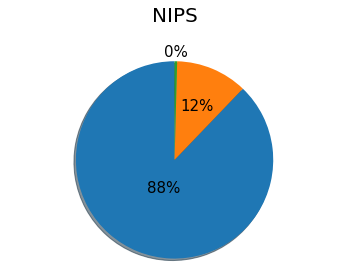

In [7]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
df_nips = pd.read_csv('nips_data.csv')
df_nips_citations = pd.read_csv('nips_citations.csv')
years_nips = df_nips['YEAR'].unique()

pub_per_year_nips = dict()
for i in years_nips: 
    pub_per_year_nips.update({i:0})

for i in range(len(df_nips)): 
    pub_per_year_nips[df_nips['YEAR'][i]] +=1
    
sum_nips = 0

for keys,values in pub_per_year_nips.items():
    sum_nips = sum_nips + values

print (pub_per_year_nips)
citations_nips = df_nips_citations['citations']
labels = '<100', '100-1000', '>1000'
new_bins = [0, 100, 1000,40000]
nips_modified = np.histogram(citations_nips,new_bins)
nips_normalized = nips_modified[0]/sum_nips

sizes = []
sizes = nips_normalized * 100
explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.set_title('NIPS',fontsize=20,pad=30)
patches, texts, autotexts = ax1.pie(sizes, explode=explode, autopct='%1.0f%%',
        shadow=True, startangle=90,textprops={'fontsize': 15},labeldistance=1.2, pctdistance=1)

pctdists = [0.3,0.6,1.1]
for t,d in zip(autotexts, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig('NIPS_2017-21.png')

{2016: 322, 2017: 434, 2018: 621, 2019: 773, 2020: 1084, 2021: 1183}


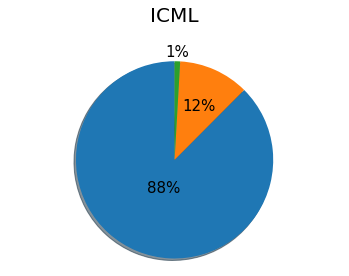

In [8]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
df_icml = pd.read_csv('icml_data.csv')
df_icml_citations = pd.read_csv('icml_citations.csv')
df_icml_whole = pd.merge(df_icml, df_icml_citations, on='TITLE')
years_icml = df_icml['YEAR'].unique()

pub_per_year_icml = dict()
for i in years_icml: 
    pub_per_year_icml.update({i:0})

for i in range(len(df_icml)): 
    pub_per_year_icml[df_icml['YEAR'][i]] +=1
    
sum_icml = 0

for keys,values in pub_per_year_icml.items():
    sum_icml = sum_icml + values

print (pub_per_year_icml)
citations_icml = df_icml_citations['citations']
labels = '<100', '100-1000', '>1000'
new_bins = [0, 100, 1000,40000]
icml_modified = np.histogram(citations_icml,new_bins)
icml_normalized = icml_modified[0]/sum_icml

sizes = []
sizes = icml_normalized * 100
explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.set_title('ICML',fontsize=20,pad=30)
patches, texts, autotexts = ax1.pie(sizes, explode=explode, autopct='%1.0f%%',
        shadow=True, startangle=90,textprops={'fontsize': 15},labeldistance=1.2, pctdistance=1)

pctdists = [0.3,0.6,1.1]
for t,d in zip(autotexts, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig('ICML_2017-21.png')

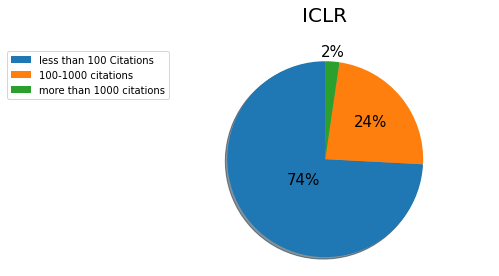

In [9]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
df_iclr = pd.read_csv('ICLR-2017-18-19-20-21.csv')
df_iclr_citations = pd.read_csv('ICLR-Citations.csv')
years_iclr = df_iclr['YEAR'].unique()

pub_per_year_iclr = dict()
for i in years_iclr: 
    pub_per_year_iclr.update({i:0})

for i in range(len(df_iclr)): 
    pub_per_year_iclr[df_iclr['YEAR'][i]] +=1
    
sum_iclr = 0

for keys,values in pub_per_year_iclr.items():
    sum_iclr = sum_iclr + values


citations_iclr = df_iclr['Citations']

labels = 'less than 100 Citations', '100-1000 citations', 'more than 1000 citations'
new_bins = [0, 100, 1000,40000]
iclr_modified = np.histogram(citations_iclr,new_bins)

iclr_normalized = iclr_modified[0]/sum_iclr

sizes = []
sizes = iclr_normalized * 100
explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.set_title('ICLR',fontsize=20,pad=30)
ax1.legend(patches, labels, bbox_to_anchor=(0.05,1.025),loc="best")
patches, texts, autotexts = ax1.pie(sizes, explode=explode, autopct='%1.0f%%',
        shadow=True, startangle=90,textprops={'fontsize': 15},labeldistance=1.2, pctdistance=1)

pctdists = [0.3,0.6,1.1]
for t,d in zip(autotexts, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig('ICLR_2017-21.png')

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('./data/nips_2016-2020.csv')
data.info()
abstract = list(data.ABSTRACT)
title = list(data.TITLE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7915 entries, 0 to 7914
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   YEAR          7915 non-null   int64 
 1   TITLE         7915 non-null   object
 2   Authors       7915 non-null   object
 3   Paper Link    7915 non-null   object
 4   ABSTRACT      7915 non-null   object
 5   Affiliations  7915 non-null   object
dtypes: int64(1), object(5)
memory usage: 371.1+ KB


In [3]:
data.head(3)

YEAR                                           TITLE  \
0  2016  Improved Dropout for Shallow and Deep Learning   
1  2016    Communication-Optimal Distributed Clustering   
2  2016              On Robustness of Kernel Clustering   

                                          Authors  \
0               Zhe Li, Boqing Gong, Tianbao Yang   
1  Jiecao Chen, He Sun, David Woodruff, Qin Zhang   
2                    Bowei Yan, Purnamrita Sarkar   

                                          Paper Link  \
0  https://nips.cc/Conferences/2016/Schedule?show...   
1  https://nips.cc/Conferences/2016/Schedule?show...   
2  https://nips.cc/Conferences/2016/Schedule?show...   

                                            ABSTRACT  \
0  Dropout has been witnessed with great success ...   
1  Clustering large datasets is a fundamental pro...   
2  Clustering is an important unsupervised learni...   

                                        Affiliations  
0  ['The University of Iowa', 'University of Cent...  
1  ['Indiana University Bloomington', 'The Univer...  
2  ['University of Texas at Austin', 'U.C. Berkel...

In [4]:
samples = data.sample(4)
for _, s in samples.iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR})")
    print(f"Abstract: {s.ABSTRACT}\n")

Memory-Efficient Approximation Algorithms for Max-k-Cut and Correlation Clustering (NeurIPS2021)
Abstract: Max-k-Cut and correlation clustering are fundamental graph partitioning problems. For a graph $G=(V,E)$ with $n$ vertices, the methods with the best approximation guarantees for Max-k-Cut and the Max-Agree variant of correlation clustering involve solving SDPs with $\mathcal{O}(n^2)$ constraints and variables. Large-scale instances of SDPs, thus, present a memory bottleneck. In this paper, we develop simple polynomial-time Gaussian sampling-based algorithms for these two problems that use $\mathcal{O}(n+|E|)$ memory and nearly achieve the best existing approximation guarantees. For dense graphs arriving in a stream, we eliminate the dependence on $|E|$ in the storage complexity at the cost of a slightly worse approximation ratio by combining our approach with sparsification.

Sanity Checks for Lottery Tickets: Does Your Winning Ticket Really Win the Jackpot? (NeurIPS2021)
Abstract

In [5]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", \
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [6]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

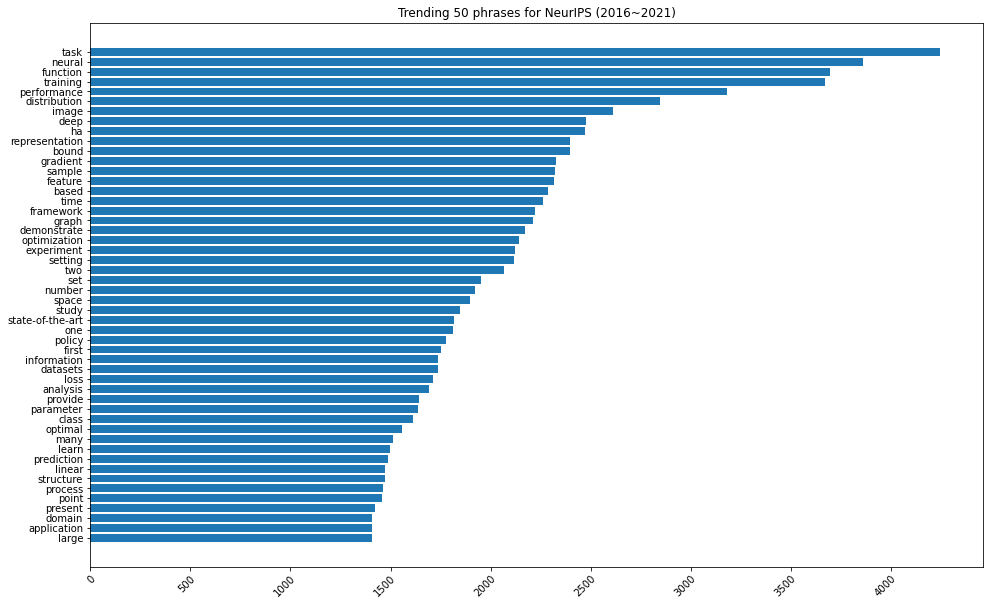

In [7]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 10))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for NeurIPS (2016~2021)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [8]:
diversity_papers = data.loc[:, ("TITLE", "YEAR")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

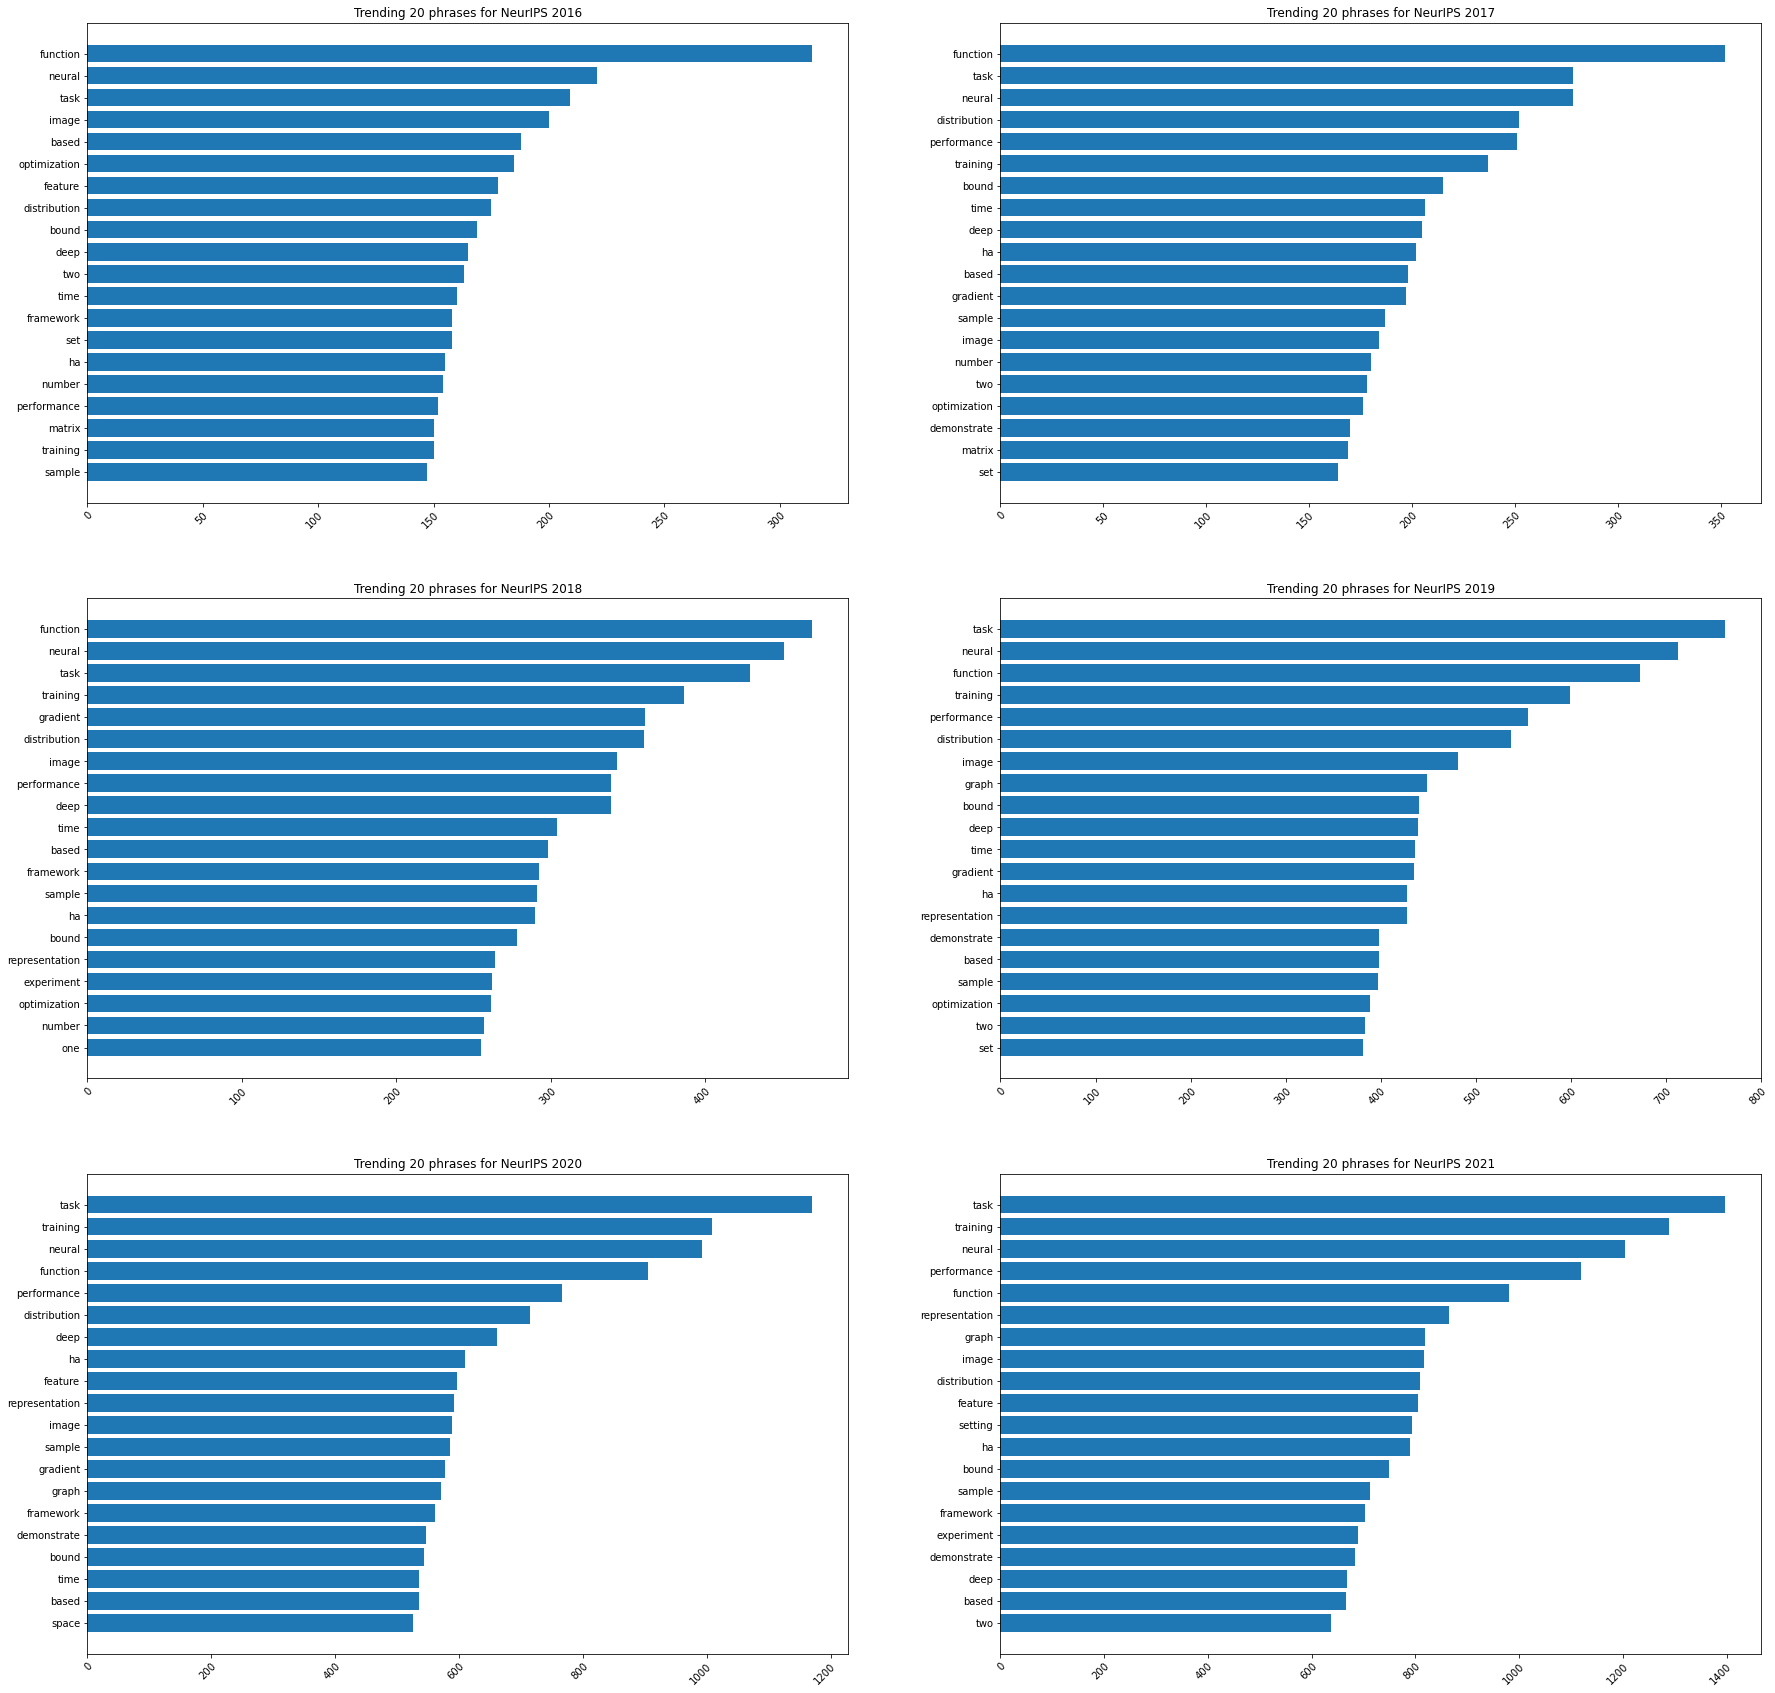

In [9]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.YEAR)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 20
fig, axes = plt.subplots(3, 2, figsize=(30, 30))
for year, ax in zip(range(2016, 2022), axes.reshape(-1)):
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} phrases for NeurIPS {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

plt.show()

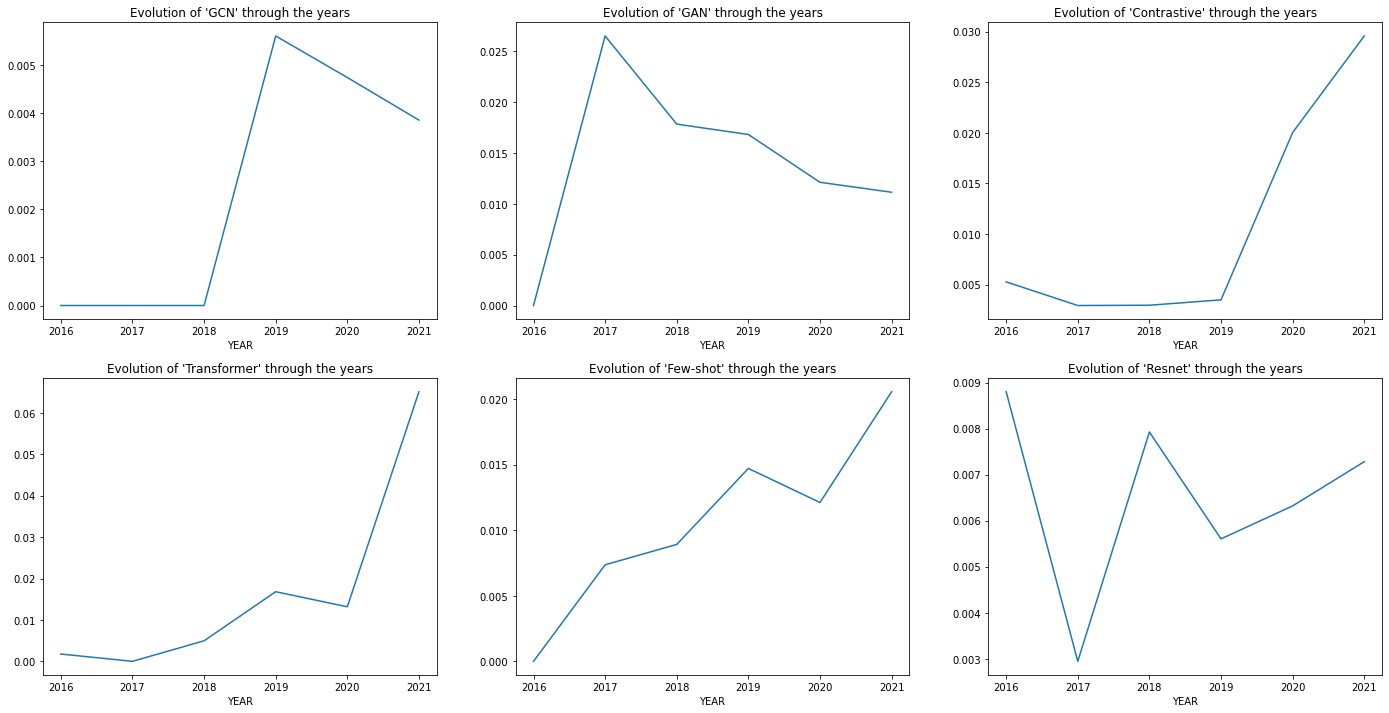

In [10]:
def trace_word_popularity(word):
    assert isinstance(word, str)
    word = word.strip().lower().translate(table)
    assert isinstance(diversity_papers, pd.DataFrame)
    is_word_in_list = np.array([feat==word for feat in tf_vectorizer.get_feature_names_out()])
    if not is_word_in_list.any():
        raise Exception("Couldn't find the word you were looking for.")
        
    if len(word.split()) > 1:
        raise Exception("Must be a 1 word long token separated by spaces.")
    
    total = diversity_papers.groupby('YEAR').count()

    word_idx = np.argwhere(is_word_in_list).item()
    count_df = (diversity_papers.groupby('YEAR').sum().n_themes
                .apply(lambda row: np.array(row))
                .apply(lambda row: row[row == word_idx].size).div(total.n_themes))
    return count_df

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
test_words = ["GCN", "GAN", "Contrastive", "Transformer", "Few-shot", "Resnet"]
for w, ax in zip(test_words, axes.reshape(-1)):
    counts = trace_word_popularity(w)
    counts.plot(ax=ax)
    ax.set_xticks(range(2016, 2022))
    ax.set_title(f"Evolution of '{w}' through the years")

In [11]:
#number of topics
n_topics=6

from sklearn.decomposition import LatentDirichletAllocation
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=123, verbose=0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [12]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [13]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if isinstance(temp_vector_sum, int):
            print(topic)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

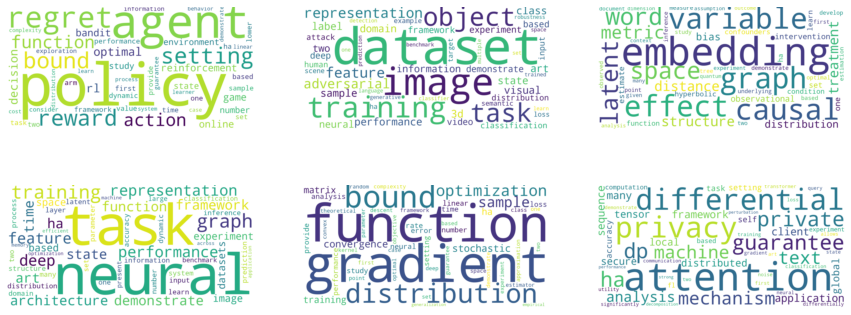

In [14]:
# Printing words from each topic
top_n_words = get_top_n_words(50, lda_keys, tf, tf_vectorizer)

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for tw, ax in zip(top_n_words, axes.reshape(-1)):
    wc = WordCloud(background_color="white", width=1600, height=800)
    wc.generate(tw)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
plt.show()

In [15]:
from sklearn.manifold import TSNE
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7915 samples in 0.003s...
[t-SNE] Computed neighbors for 7915 samples in 0.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7915
[t-SNE] Computed conditional probabilities for sample 2000 / 7915
[t-SNE] Computed conditional probabilities for sample 3000 / 7915
[t-SNE] Computed conditional probabilities for sample 4000 / 7915
[t-SNE] Computed conditional probabilities for sample 5000 / 7915
[t-SNE] Computed conditional probabilities for sample 6000 / 7915
[t-SNE] Computed conditional probabilities for sample 7000 / 7915
[t-SNE] Computed conditional probabilities for sample 7915 / 7915
[t-SNE] Mean sigma: 0.002776
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.152054
[t-SNE] KL divergence after 2000 iterations: 0.815938


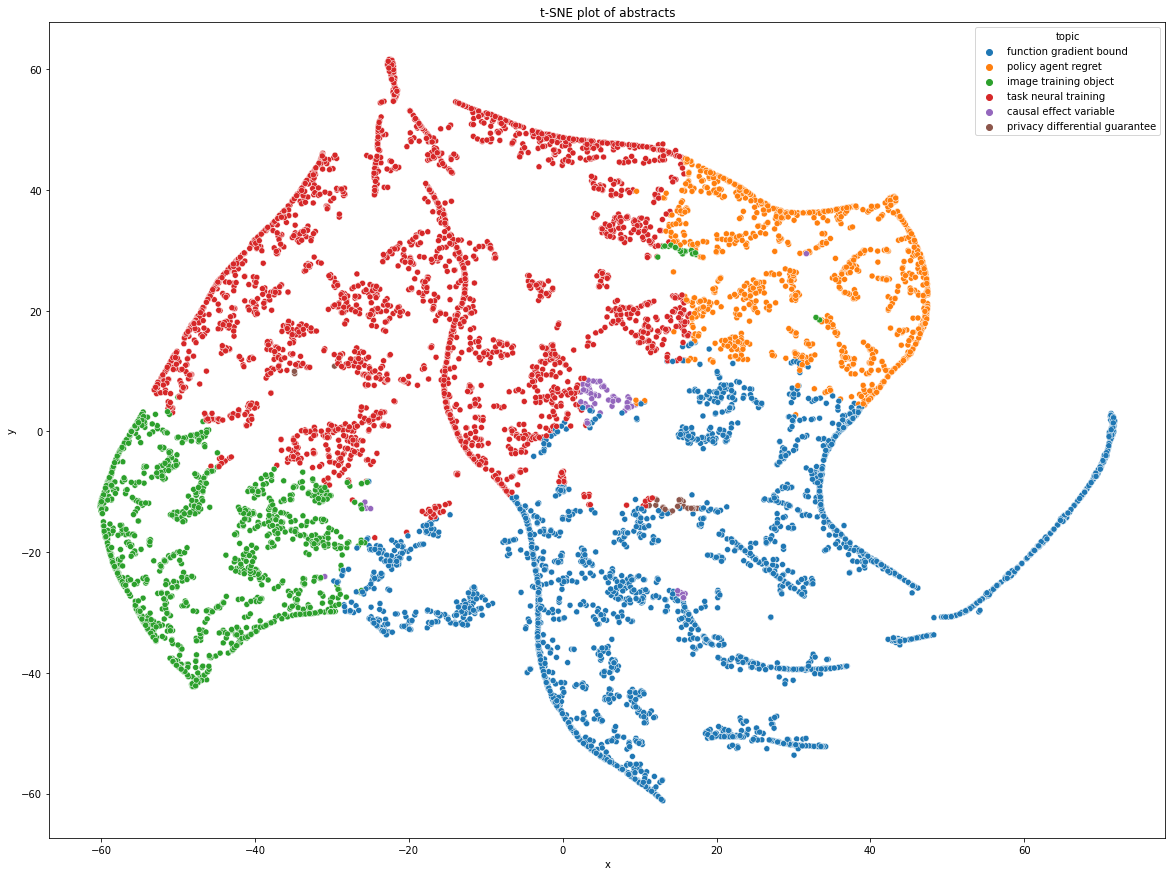

In [16]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

hue = []
for k in lda_keys:
    hue.append(top_3_words_lda[k])

disp_data = pd.DataFrame({'x': pd.Series(tsne_lda_vectors[:,0]), 'y': pd.Series(tsne_lda_vectors[:,1]), 'topic': pd.Series(hue)})
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(data=disp_data, x='x', y='y', hue='topic', ax=ax)
ax.set_title("t-SNE plot of abstracts")
plt.show()

In [17]:
for n in range(5):
    topic_most_pr = lda_topic_matrix[n].argsort()[-2:]
    print("Paper #{}: {}\n - top 2 topic: ({})+({})\n".format(n,title[n], top_3_words_lda[topic_most_pr[0]], top_3_words_lda[topic_most_pr[1]]))

Paper #0: Improved Dropout for Shallow and Deep Learning
 - top 2 topic: (task neural training)+(function gradient bound)

Paper #1: Communication-Optimal Distributed Clustering
 - top 2 topic: (privacy differential guarantee)+(policy agent regret)

Paper #2: On Robustness of Kernel Clustering
 - top 2 topic: (privacy differential guarantee)+(function gradient bound)

Paper #3: Combinatorial semi-bandit with known covariance
 - top 2 topic: (function gradient bound)+(policy agent regret)

Paper #4: A posteriori error bounds for joint matrix decomposition problems
 - top 2 topic: (causal effect variable)+(function gradient bound)



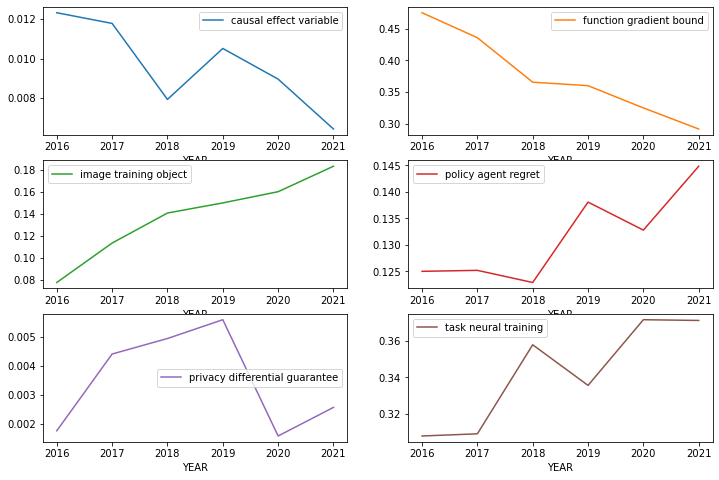

In [18]:
plt.rcParams['figure.figsize'] = (12,8)
lda_topics = [top_3_words_lda[k] for k in lda_keys]
# pd.crosstab(df_new['YEAR'], df_new['Dominant_Topic'], normalize='index').plot.bar(stacked=True)
pd.crosstab(data['YEAR'].astype(int), pd.Series(lda_topics).astype('category'), normalize='index').plot(kind='line', subplots=True, sharex=False, layout=(3, 2))
plt.show()

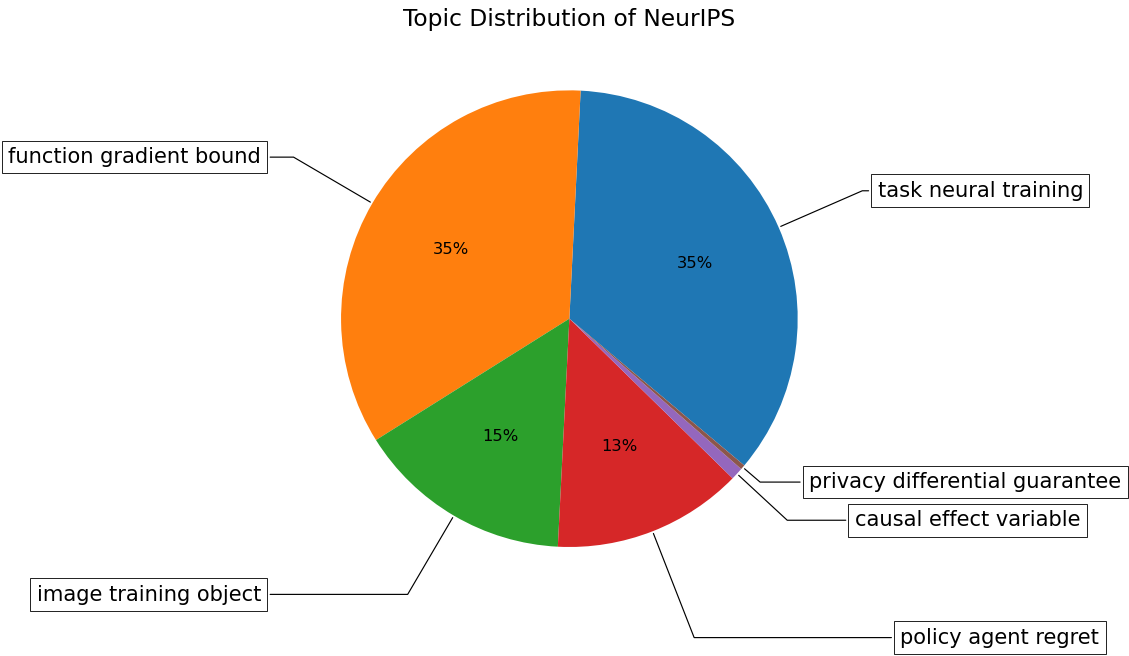

In [19]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

inds = np.flip(np.argsort(lda_counts))

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi=84)

values = np.array(lda_counts)[inds]
labels = np.array(top_3_words_lda)[lda_categories][inds]

wedges, texts, _ = ax.pie(values, wedgeprops=dict(width=1.0), startangle=-40, autopct=make_autopct(values), textprops={'fontsize': 14})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, -0.1, -0.3][i-3] if i > 2 else 0.0
    ax.annotate(labels[i], xy=(x, y), xytext=((1.35+offset)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title("Topic Distribution of NeurIPS", fontsize=20)

plt.show()

In [20]:
title_proc = []
for i in range(len(title)):
    t = title[i].strip().lower().translate(table).split()
    title_proc.append([lemm.lemmatize(w) for w in t])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tv = tfidf_vectorizer.fit_transform(title_proc)
tv_norm = normalize(tv, axis=1)

In [26]:
from scipy.spatial.distance import jensenshannon as js
def find_n_related(inp_t, inp_ab, n, alpha=0.5):
    assert isinstance(inp_t, str)
    assert isinstance(inp_ab, str)
    # preprocess
    t_proc = inp_t.strip().lower().translate(table).split()
    ab_proc = inp_ab.strip().lower().translate(table).split()
    t_proc = [lemm.lemmatize(w) for w in t_proc]
    ab_proc = [lemm.lemmatize(w) for w in ab_proc]

    t_vec = tfidf_vectorizer.transform([t_proc]).toarray()
    t_vec = normalize(t_vec, axis=1)
    # print(t_vec.shape)
    t_scores = np.matmul(tv_norm.toarray(), t_vec.T).squeeze()

    ab_vec = tf_vectorizer.transform([ab_proc]).toarray()
    logits = lda.transform(ab_vec)
    # ab_scores = np.matmul(lda_topic_matrix, logits.T).squeeze()
    ab_scores = 1 - np.array([js(v.squeeze(), logits.squeeze(), 2) for v in lda_topic_matrix])

    scores = alpha * t_scores + (1-alpha) * ab_scores
    inds = np.flip(np.argsort(scores))[:n]
    retrieved = data.loc[inds, :]
    retrieved["Score"] = scores[inds]

    return retrieved

In [27]:
# Temporal Localization of Moments in Video Collections with Natural Language (ICCV2019)
# https://arxiv.org/abs/1907.12763
test_t = "Temporal Localization of Moments in Video Collections with Natural Language"
test_abs = """In this paper, we introduce the task of retrieving relevant video moments from a large corpus of untrimmed, unsegmented videos given a natural language query.
Our task poses unique challenges as a system must efficiently identify both the relevant videos and localize the relevant moments in the videos.
This task is in contrast to prior work that localizes relevant moments in a single video or searches a large collection of already-segmented videos.
For our task, we introduce Clip Alignment with Language (CAL), a model that aligns features for a natural language query to a sequence of short video clips that compose a candidate moment in a video.
Our approach goes beyond prior work that aggregates video features over a candidate moment by allowing for finer clip alignment.
Moreover, our approach is amenable to efficient indexing of the resulting clip-level representations, which makes it suitable for moment localization in large video collections.
We evaluate our approach on three recently proposed datasets for temporal localization of moments in video with natural language extended to our video corpus moment retrieval setting: DiDeMo, Charades-STA, and ActivityNet-captions.
We show that our CAL model outperforms the recently proposed Moment Context Network (MCN) on all criteria across all datasets on our proposed task, obtaining an 8%-85% and 11%-47% boost for average recall and median rank, respectively,
and achieves 5x faster retrieval and 8x smaller index size with a 500K video corpus."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR}): {s.Score:.3f}")

Low-Fidelity Video Encoder Optimization for Temporal Action Localization (NeurIPS2021): 0.647
Detecting Moments and Highlights in Videos via Natural Language Queries (NeurIPS2021): 0.644
Localization with Sampling-Argmax (NeurIPS2021): 0.586
Learning Temporal Pose Estimation from Sparsely-Labeled Videos (NeurIPS2019): 0.571
Temporal Coherency based Criteria for Predicting Video Frames using Deep Multi-stage Generative Adversarial Networks (NeurIPS2017): 0.567
e-SNLI: Natural Language Inference with Natural Language Explanations (NeurIPS2018): 0.547
Towards Interpretable Natural Language Understanding with Explanations as Latent Variables (NeurIPS2020): 0.536
Blind Video Temporal Consistency via Deep Video Prior (NeurIPS2020): 0.526
Foreground Clustering for Joint Segmentation and Localization in Videos and Images (NeurIPS2018): 0.525
Semantic-Guided Multi-Attention Localization for Zero-Shot Learning (NeurIPS2019): 0.525


In [28]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16955 (AAAI2021)
test_t = "Adversarial Defence by Diversified Simultaneous Training of Deep Ensembles"
test_abs = """Learning-based classifiers are susceptible to adversarial examples. Existing defence methods are mostly devised on individual classifiers.
Recent studies showed that it is viable to increase adversarial robustness by promoting diversity over an ensemble of models.
In this paper, we propose adversarial defence by encouraging ensemble diversity on learning high-level feature representations and gradient dispersion in simultaneous training of deep ensemble networks.
We perform extensive evaluations under white-box and black-box attacks including transferred examples and adaptive attacks.
Our approach achieves a significant gain of up to 52% in adversarial robustness, compared with the baseline and the state-of-the-art method on image benchmarks with complex data scenes.
The proposed approach complements the defence paradigm of adversarial training, and can further boost the performance. The source code is available at https://github.com/ALIS-Lab/AAAI2021-PDD."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR}): {s.Score:.3f}")

Adversarial training for free! (CVPR2019): 0.688
On Adversarial Mixup Resynthesis (CVPR2019): 0.645
MRI Banding Removal via Adversarial Training (CVPR2020): 0.616
Gradient-Free Adversarial Training Against Image Corruption for Learning-based Steering (CVPR2021): 0.612
Deep Defense: Training DNNs with Improved Adversarial Robustness (CVPR2018): 0.611
Generating steganographic images via adversarial training (CVPR2017): 0.599
Spatial Ensemble: a Novel Model Smoothing Mechanism for Student-Teacher Framework (CVPR2021): 0.594
DM2C: Deep Mixed-Modal Clustering (CVPR2019): 0.590
Boosting Adversarial Training with Hypersphere Embedding (CVPR2020): 0.582
Knowledge Distillation by On-the-Fly Native Ensemble (CVPR2018): 0.571


In [30]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16815 (AAAI2021)
test_t = "Learning Invariant Representations using Inverse Contrastive Loss"
test_abs = """Learning invariant representations is a critical first step in a number of machine learning tasks.
A common approach is given by the so-called information bottleneck principle in which an application dependent function of mutual information is carefully chosen and optimized.
Unfortunately, in practice, these functions are not suitable for optimization purposes since these losses are agnostic of the metric structure of the parameters of the model.
In our paper, we introduce a class of losses for learning representations that are invariant to some extraneous variable of interest by inverting the class of contrastive losses, i.e., inverse contrastive loss (ICL).
We show that if the extraneous variable is binary, then optimizing ICL is equivalent to optimizing a regularized MMD divergence.
More generally, we also show that if we are provided a metric on the sample space, our formulation of ICL can be decomposed into a sum of convex functions of the given distance metric.
Our experimental results indicate that models obtained by optimizing ICL achieve significantly better invariance to the extraneous variable for a fixed desired level of accuracy.
In a variety of experimental settings, we show applicability of ICL for learning invariant representations for both continuous and discrete protected/extraneous variables.
The project page with code is available at https://github.com/adityakumarakash/ICL"""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (NeurIPS{s.YEAR}): {s.Score:.3f}")

Contrastive Learning from Pairwise Measurements (NeurIPS2018): 0.567
Adversarial Surrogate Losses for Ordinal Regression (NeurIPS2017): 0.551
Nonparametric Density Estimation under Adversarial Losses (NeurIPS2018): 0.539
Multilabel reductions: what is my loss optimising? (NeurIPS2019): 0.534
Provable Guarantees for Self-Supervised Deep Learning with Spectral Contrastive Loss (NeurIPS2021): 0.531
SNIPS: Solving Noisy Inverse Problems Stochastically (NeurIPS2021): 0.510
Max-Margin Invariant Features from Transformed Unlabelled Data (NeurIPS2017): 0.509
Inverse Problems Leveraging Pre-trained Contrastive Representations (NeurIPS2021): 0.506
Learning from Bad Data via Generation (NeurIPS2019): 0.493
Learning the optimal Tikhonov regularizer for inverse problems (NeurIPS2021): 0.489


In [34]:
import pickle
with open("./saved_models/lda_nips.pickle", 'wb') as f:
    pickle.dump(lda, f)

In [35]:
np.save("./saved_models/matrix_nips.npy", lda_topic_matrix)

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
import pandas as pd
from matplotlib import cm
from IPython.display import display, HTML
import operator as op

In [3]:
data_dir = '../data/'


In [4]:
df_nips = pd.read_csv(data_dir + 'nips_2016-2020.csv')
df_icml = pd.read_csv(data_dir + 'icml_affiliations.csv')

df_iclr1 = pd.read_csv(data_dir + 'ICLR-2017-18-19-21.csv')
df_iclr2 = pd.read_csv(data_dir + '2020_iclr_manual_data.csv')
df_iclr = pd.concat([df_iclr1, df_iclr2], sort=True)
df_iclr = df_iclr.reset_index(drop=True)
df_cvpr = pd.read_csv(data_dir + 'cvpr_16-21.csv')

df_cvpr_citations = pd.read_csv(data_dir + 'cvpr_citations.csv')

In [5]:
df_cvpr['Authors']
for i in range(len(df_cvpr['Authors'])): 
    df_cvpr['Authors'] = df_cvpr['Authors'].str.replace(';',',')
    
for i in range(len(df_iclr['Citations'])):
    try:
        df_iclr['Citations'][i] = int(df_iclr['Citations'][i])
        df_iclr['YEAR'][i] = int(df_iclr['YEAR'][i])
    except Exception as e: 
        df_iclr['Citations'][i] = 0
        df_iclr['YEAR'][i] = df_iclr['YEAR'][i-1]

<ipython-input-5-dd3570a6c6d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iclr['Citations'][i] = int(df_iclr['Citations'][i])
<ipython-input-5-dd3570a6c6d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iclr['YEAR'][i] = int(df_iclr['YEAR'][i])
<ipython-input-5-dd3570a6c6d7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iclr['Citations'][i] = 0
<ipython-input-5-dd3570a6c6d7>:11: SettingWithCopyWarning: 
A value is

In [6]:
years = df_nips['YEAR'].unique()
years

array([2016, 2017, 2018, 2019, 2020, 2021])

In [7]:
paper_per_year = {'NIPS': dict(),'ICML':dict(),'ICLR':dict(),'CVPR': dict()}
data = [df_nips, df_icml, df_iclr, df_cvpr]
num = 0
for key in paper_per_year.keys():
    print(key)
    pub_per_year = dict()

    for i in years: 
        pub_per_year.update({i:0})

    for i in range(len(data[num])):
        try:
            pub_per_year[data[num]['YEAR'][i]] +=1
        except:
            continue
    paper_per_year[key] = pub_per_year
    num+=1

NIPS
ICML
ICLR
CVPR


In [8]:
paper_per_year['CVPR']

{2016: 643, 2017: 784, 2018: 1004, 2019: 1302, 2020: 1469, 2021: 1667}

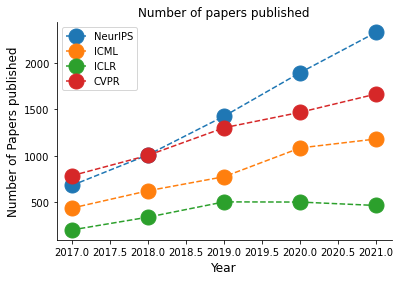

In [9]:
fig,axs = subplots(1,1) 
axs.plot(years[1:], list(paper_per_year['NIPS'].values())[1:],marker = 'o', linestyle='--', markersize = 15, label = 'NeurIPS')
axs.plot(years[1:], list(paper_per_year['ICML'].values())[1:],marker = 'o', linestyle='--', markersize = 15, label = 'ICML')
axs.plot(years[1:], list(paper_per_year['ICLR'].values())[1:],marker = 'o', linestyle='--', markersize = 15, label = 'ICLR')
axs.plot(years[1:], list(paper_per_year['CVPR'].values())[1:],marker = 'o', linestyle='--', markersize = 15, label = 'CVPR')
axs.set_xlabel('Year', fontsize = 12)
axs.set_ylabel('Number of Papers published',fontsize = 12)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_title('Number of papers published')
axs.legend()

In [10]:
df_nips_citations = pd.read_csv(data_dir + 'nips_citations.csv')
df_icml_citations = pd.read_csv(data_dir + 'icml_citations.csv')
df_iclr_citations = pd.DataFrame({'YEAR':df_iclr['YEAR'], 'citations':df_iclr['Citations']})
df_iclr_citations['citations'].astype('int64').dtypes
type(df_iclr_citations['citations'][1994])

int

In [11]:
nips_2017 = df_nips_citations[df_nips_citations['YEAR']==2017].sort_values(by='citations', ascending = False)
nips_2018 = df_nips_citations[df_nips_citations['YEAR']==2018].sort_values(by='citations', ascending = False)
nips_2019 = df_nips_citations[df_nips_citations['YEAR']==2019].sort_values(by='citations', ascending = False)
print('Neurips {}'.format(2017))
display(HTML(nips_2017[['TITLE', 'citations']].head(n=10).to_html(index=False)))
# print('Neurips {}'.format(2018))
# display(HTML(nips_2018[['TITLE', 'citations']].head(n=10).to_html(index=False)))
# print('Neurips {}'.format(2019))
# display(HTML(nips_2019[['TITLE', 'citations']].head(n=10).to_html(index=False)))

Neurips 2017


In [12]:
bins = [0,50,500,5000,50000,500000]

nips_citations_2017 = df_nips_citations[df_nips_citations['YEAR']==2017]['citations']
nips_citations_2018 = df_nips_citations[df_nips_citations['YEAR']==2018]['citations']
nips_citations_2019 = df_nips_citations[df_nips_citations['YEAR']==2019]['citations']
nips_citations_2020 = df_nips_citations[df_nips_citations['YEAR']==2020]['citations']

icml_citations_2017 = df_icml_citations[df_icml_citations['YEAR']==2017]['citations']
icml_citations_2018 = df_icml_citations[df_icml_citations['YEAR']==2018]['citations']
icml_citations_2019 = df_icml_citations[df_icml_citations['YEAR']==2019]['citations']
icml_citations_2020 = df_icml_citations[df_icml_citations['YEAR']==2020]['citations']

iclr_citations_2017 = df_iclr_citations[df_iclr_citations['YEAR']==2017]['citations']
iclr_citations_2018 = df_iclr_citations[df_iclr_citations['YEAR']==2018]['citations']
iclr_citations_2019 = df_iclr_citations[df_iclr_citations['YEAR']==2019]['citations']
iclr_citations_2020 = df_iclr_citations[df_iclr_citations['YEAR']==2020]['citations']

cvpr_citations_2017 = df_cvpr_citations[df_cvpr_citations['YEAR']==2017]['citations']
cvpr_citations_2018 = df_cvpr_citations[df_cvpr_citations['YEAR']==2018]['citations']
cvpr_citations_2019 = df_cvpr_citations[df_cvpr_citations['YEAR']==2019]['citations']
cvpr_citations_2020 = df_cvpr_citations[df_cvpr_citations['YEAR']==2020]['citations']




nips_citations = {2017:np.histogram(nips_citations_2017, bins), 2018:np.histogram(nips_citations_2018,bins),\
                  2019:np.histogram(nips_citations_2019,bins), 2020:np.histogram(nips_citations_2020,bins)}

icml_citations = {2017:np.histogram(icml_citations_2017,bins), 2018:np.histogram(icml_citations_2018,bins),\
                  2019:np.histogram(icml_citations_2019,bins), 2020:np.histogram(icml_citations_2020,bins)}

iclr_citations = {2017:np.histogram(iclr_citations_2017, bins), 2018:np.histogram(iclr_citations_2018, bins),\
                  2019:np.histogram(iclr_citations_2019, bins), 2020: np.histogram(iclr_citations_2020, bins)}

cvpr_citations = {2017:np.histogram(cvpr_citations_2017, bins),2018:np.histogram(cvpr_citations_2018, bins),\
                 2019:np.histogram(cvpr_citations_2019, bins),2020:np.histogram(cvpr_citations_2020, bins)}


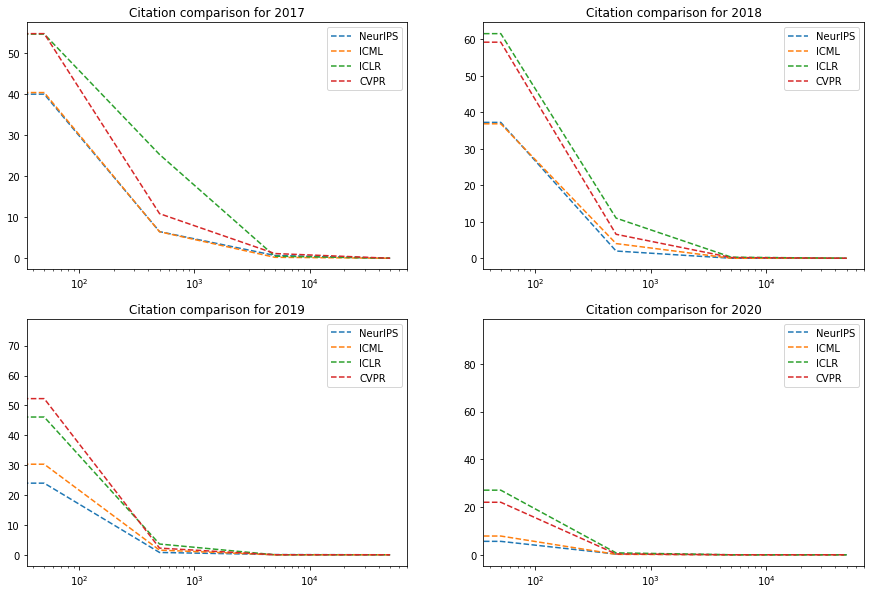

In [13]:
years = list(nips_citations.keys())
fig,axs = subplots(2,2,figsize = (15,10))
for i in range(len(years)):
    axs[i//2, i%2].plot(list(nips_citations[years[i]][1][:-1]), list(100*nips_citations[years[i]][0])/sum(list(nips_citations[years[i]][0])),label='NeurIPS', linestyle = '--')
    axs[i//2,i%2].plot(list(icml_citations[years[i]][1][:-1]), list(100*icml_citations[years[i]][0])/sum(list(icml_citations[years[i]][0])),label='ICML', linestyle = '--')
    axs[i//2,i%2].plot(list(iclr_citations[years[i]][1][:-1]), list(100*iclr_citations[years[i]][0])/sum(list(iclr_citations[years[i]][0])), label='ICLR',linestyle = '--')
    axs[i//2,i%2].plot(list(cvpr_citations[years[i]][1][:-1]), list(100*cvpr_citations[years[i]][0])/sum(list(cvpr_citations[years[i]][0])), label='CVPR',linestyle = '--')
    axs[i//2,i%2].set_title(f'Citation comparison for {years[i]}')
    axs[i//2,i%2].set_xscale('log')
    axs[i//2,i%2].legend()

In [14]:
f_whole = pd.concat([df_nips, df_icml,df_iclr,df_cvpr])

In [15]:
affiliations = np.asarray(df_whole['Affiliations'])
aff_dict = dict()

for i in range(len(affiliations)):
    
    aff = str(affiliations[i]).replace('[','').replace(']','').replace('The','').split(', ')
    for entry in aff:
        entry = entry.replace("'",'')
        if entry not in aff_dict.keys():
            aff_dict.update({entry:1})
        else:
            aff_dict[entry] +=1
   
            
affil = dict(sorted(aff_dict.items(), key = op.itemgetter(1))[::-1])

def remove_duplicates(target_key, words):
    assert target_key in list(affil.keys())
    assert isinstance(words, list) and len(words) >= 1
    for key in list(affil.keys()): 
        if any(word in key.lower() for word in words)  : 
            affil[target_key] += affil[key]
            affil[key] = 0

remove_duplicates('Google', ['google','deepmind'])
words = ['uc san diego', 'university of california san diego',\
            'university of california at san diego','university of california, san diego','university of california']
remove_duplicates('UCSD',words)
remove_duplicates('MIT', ['massachusetts'])
remove_duplicates('Stanford', ['stanford uni'])
remove_duplicates('UCLA',['los angeles', 'university of california los angeles',\
                          'university of california, los angeles', 'university of california at los angeles'])
remove_duplicates('CMU',['Carnegie Mellon'])


In [20]:
affil = dict((sorted(affil.items(), key = op.itemgetter(1))[::-1])[:20])
try:
    affil.pop('NA')
    affil.pop('')
    affil.pop('None')
except:
    pass
affil.pop('None')

506

Text(0.5, 1.0, 'Institutes most active in publications')

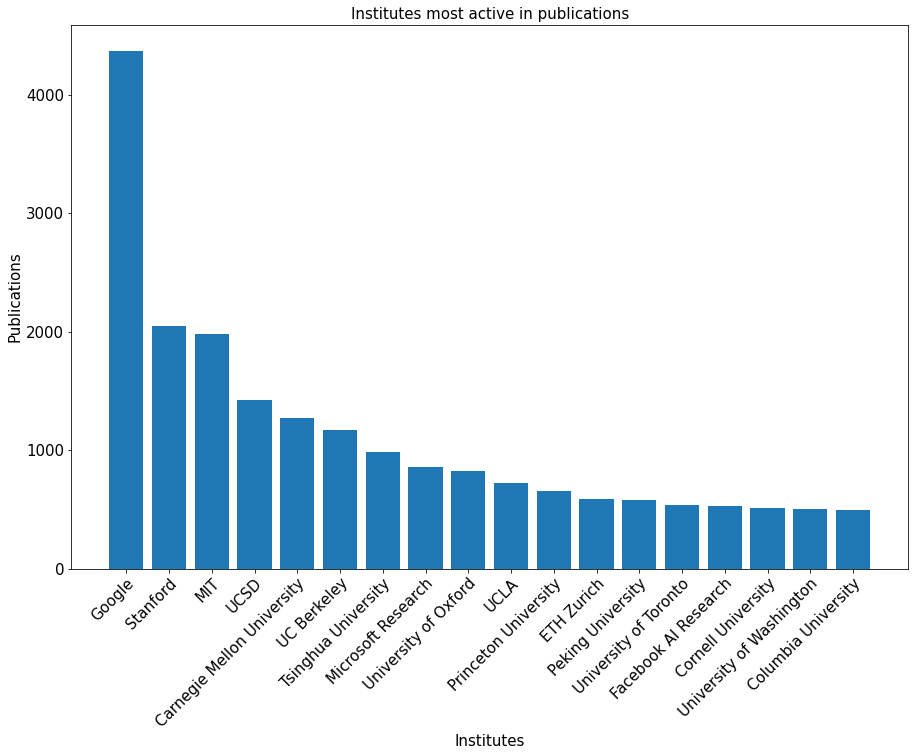

In [21]:
fig,ax = subplots(figsize=(15,10))
ax.bar(affil.keys(), affil.values())
ax.set_xlabel('Institutes', fontsize = 15)
ax.set_ylabel('Publications', fontsize = 15)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize = 15)
plt.setp(ax.get_yticklabels(),  fontsize = 15)
plt.title('Institutes most active in publications', fontsize = 15)

In [96]:
authors = np.asarray(df_whole['Authors'])

In [98]:
author_dict = dict()
for row in authors: 
    row = str(row).split(', ')
    for entry in row: 
        if entry not in author_dict.keys():
            author_dict.update({entry:1})
        else: 
            author_dict[entry]+=1

In [99]:
author_dict = sorted(author_dict.items(), key = op.itemgetter(1))[::-1]

In [100]:
author_dict = dict(author_dict[:20])

Text(0.5, 1.0, 'Authors most active in publications')

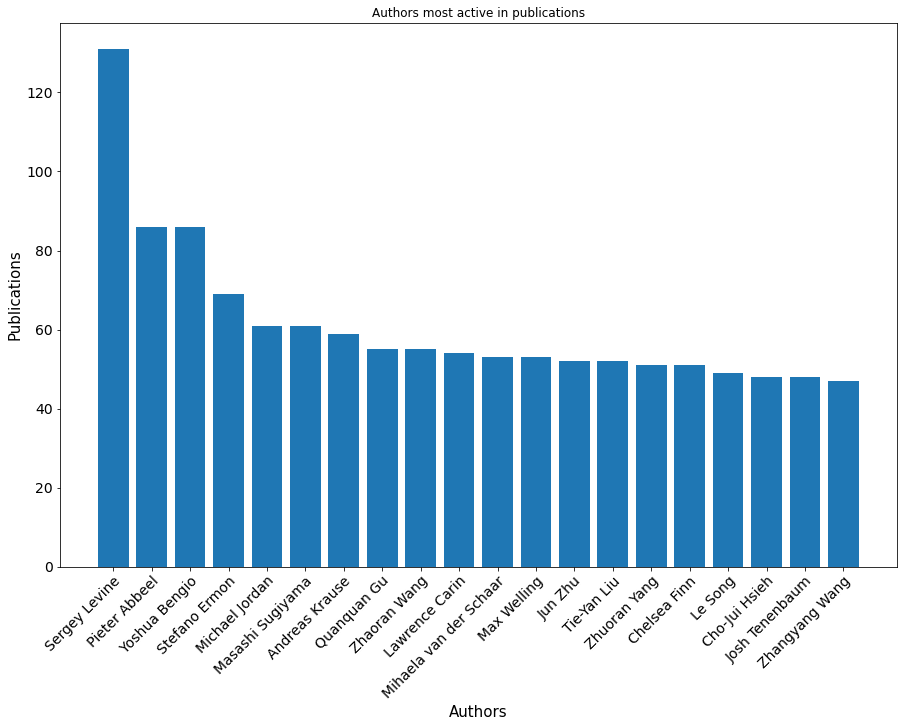

In [104]:
fig,ax = subplots(figsize = (15,10))
ax.bar(author_dict.keys(), author_dict.values())
ax.set_xlabel('Authors', fontsize = 15)
ax.set_ylabel('Publications', fontsize = 15)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor",fontsize = 14)
plt.setp(ax.get_yticklabels(), fontsize = 14)
plt.title('Authors most active in publications')

#Try horizontal bar chart

In [102]:
affil_nips_2017 = np.asarray(df_nips[df_nips['YEAR']==2017]['Affiliations'])
affil_nips_2018 = np.asarray(df_nips[df_nips['YEAR']==2018]['Affiliations'])
affil_nips_2019 = np.asarray(df_nips[df_nips['YEAR']==2019]['Affiliations'])
affil_nips_2020 = np.asarray(df_nips[df_nips['YEAR']==2020]['Affiliations'])
affil_nips_2021 = np.asarray(df_nips[df_nips['YEAR']==2021]['Affiliations'])

affil_iclr_2017 = np.asarray(df_iclr[df_iclr['YEAR']==2017]['Affiliations'])
affil_iclr_2018 = np.asarray(df_iclr[df_iclr['YEAR']==2018]['Affiliations'])
affil_iclr_2019 = np.asarray(df_iclr[df_iclr['YEAR']==2019]['Affiliations'])
affil_iclr_2020 = np.asarray(df_iclr[df_iclr['YEAR']==2020]['Affiliations'])
affil_iclr_2021 = np.asarray(df_iclr[df_iclr['YEAR']==2021]['Affiliations'])

affil_icml_2017 = np.asarray(df_icml[df_icml['YEAR']==2017]['Affiliations'])
affil_icml_2018 = np.asarray(df_icml[df_icml['YEAR']==2018]['Affiliations'])
affil_icml_2019 = np.asarray(df_icml[df_icml['YEAR']==2019]['Affiliations'])
affil_icml_2020 = np.asarray(df_icml[df_icml['YEAR']==2020]['Affiliations'])
affil_icml_2021 = np.asarray(df_icml[df_icml['YEAR']==2021]['Affiliations'])

affil_cvpr_2017 = np.asarray(df_cvpr[df_cvpr['YEAR']==2017]['Affiliations'])
affil_cvpr_2018 = np.asarray(df_cvpr[df_cvpr['YEAR']==2018]['Affiliations'])
affil_cvpr_2019 = np.asarray(df_cvpr[df_cvpr['YEAR']==2019]['Affiliations'])
affil_cvpr_2020 = np.asarray(df_cvpr[df_cvpr['YEAR']==2020]['Affiliations'])
affil_cvpr_2021 = np.asarray(df_cvpr[df_cvpr['YEAR']==2021]['Affiliations'])


In [23]:
nips = {2017:[], 2018:[], 2019:[], 2020:[], 2021:[]}
icml = {2017:[], 2018:[], 2019:[], 2020:[], 2021:[]}
iclr = {2017:[], 2018:[], 2019:[], 2020:[], 2021:[]}
cvpr = {2017:[], 2018:[], 2019:[], 2020:[], 2021:[]}

affil_nips = {2017: affil_nips_2017, 2018: affil_nips_2018, 2019: affil_nips_2019, 2020: affil_nips_2020, 2021: affil_nips_2021}
affil_icml = {2017: affil_icml_2017, 2018: affil_icml_2018, 2019: affil_icml_2019, 2020: affil_icml_2020, 2021: affil_icml_2021}
affil_iclr = {2017: affil_iclr_2017, 2018: affil_iclr_2018, 2019: affil_iclr_2019, 2020: affil_iclr_2020,2021: affil_iclr_2021}
affil_cvpr = {2017: affil_cvpr_2017, 2018: affil_cvpr_2018, 2019: affil_cvpr_2019, 2020: affil_cvpr_2020, 2021: affil_cvpr_2021 }

affil = [affil_nips, affil_icml, affil_iclr, affil_cvpr]


data = [nips, icml, iclr, cvpr]
years = range(2017,2022)

for i in range(len(data)): 
    for year in years:
        for k in range(len(affil[i][year])):
            row = str(affil[i][year][k]).replace('[','').replace(']','').replace('\n',',').split(', ')
            for entry in row:
                data[i][year].append(entry.lower().replace("'",'').replace("'",'').replace('"',''))
        


In [24]:
uni_keywords = ['uni','tech','uc','mit','ui','eth','epfl','inst','college']
industry_kewords = ['google','microsoft','adobe','amazon','deepmind','ai','research','systems','nvidia','amd']

In [25]:
nips_university = {2017:0, 2018:0,2019:0,2020:0,2021:0}
nips_industry = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(nips_university.keys())
names = [nips[2017],nips[2018],nips[2019],nips[2020],nips[2021]]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords): 
            nips_university[year] +=1
        else: 
            nips_industry[year]+=1
            

            
icml_university = {2017:0, 2018:0,2019:0,2020:0,2021:0}
icml_industry = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(icml_university.keys())
names = [icml[2017],icml[2018],icml[2019],icml[2020],icml[2021]]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords): 
            icml_university[year] +=1
        else:
            icml_industry[year]+=1
            

iclr_university = {2017:0, 2018:0,2019:0,2020:0,2021:0}
iclr_industry = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(iclr_university.keys())
names = [iclr[2017],iclr[2018],iclr[2019],iclr[2020],iclr[2021]]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords): 
            iclr_university[year] +=1
        else:
            iclr_industry[year]+=1

cvpr_university = {2017:0, 2018:0,2019:0,2020:0,2021:0}
cvpr_industry = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(cvpr_university.keys())
names = [cvpr[2017],cvpr[2018],cvpr[2019],cvpr[2020],cvpr[2021]]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords): 
            cvpr_university[year] +=1
        else:
            cvpr_industry[year]+=1


In [34]:
total_university = dict()
total_industry = dict()
for key in list(cvpr_industry.keys()):
    total_university[key] = nips_university[key] + icml_university[key] + iclr_university[key] + cvpr_university[key]
    total_industry[key] = nips_industry[key] + icml_industry[key] + iclr_industry[key] + cvpr_industry[key]
 

Text(0.5, 1.0, 'Total Publications by university and industry for each year')

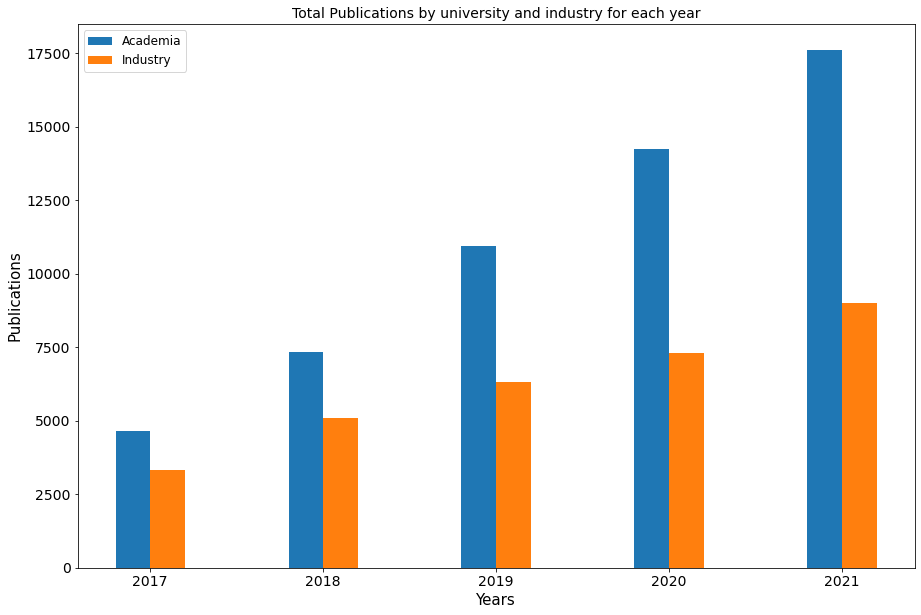

In [109]:
fig,axs = subplots(figsize = (15,10))
years = np.asarray(list(total_university.keys()))
bar_width = 0.2
axs.bar(years, total_university.values(), width=bar_width, label = 'Academia')
axs.bar(years + bar_width, total_industry.values(), width = bar_width, label = 'Industry')
axs.set_xlabel('Years', fontsize = 15)
axs.set_ylabel('Publications', fontsize = 15)
axs.set_xticks(years + bar_width/2)
axs.set_xticklabels(years)
plt.setp(axs.get_yticklabels(),fontsize = 14)
plt.setp(axs.get_xticklabels(),fontsize = 14)
axs.set_xticklabels(years)
axs.legend(fontsize = 12)
axs.set_title('Total Publications by university and industry for each year', fontsize = 14)

Text(0.5, 1.0, 'Publications by university and industry in NeurIPS')

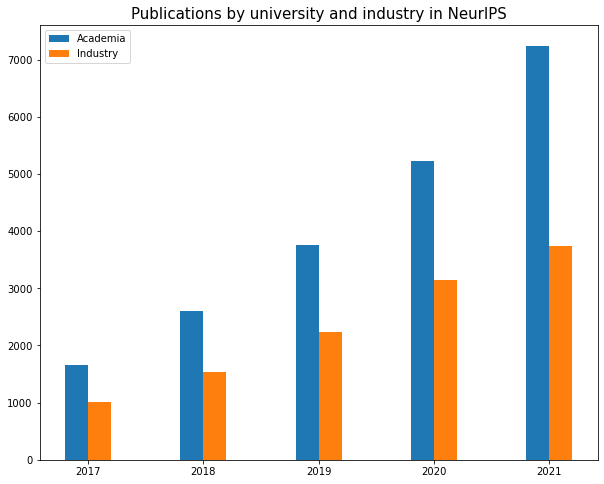

In [37]:
fig,axs = subplots(figsize = (10,8))
years = np.asarray(list(nips_university.keys()))
bar_width = 0.2
axs.bar(years, nips_university.values(), width=bar_width, label = 'Academia')
axs.bar(years + bar_width, nips_industry.values(), width = bar_width, label = 'Industry')
axs.set_xticks(years + bar_width/2)
axs.set_xticklabels(years)
axs.legend(fontsize = 10)
axs.set_title('Publications by university and industry in NeurIPS', fontsize = 15)

Text(0.5, 1.0, 'Publications by university and industry in ICML')

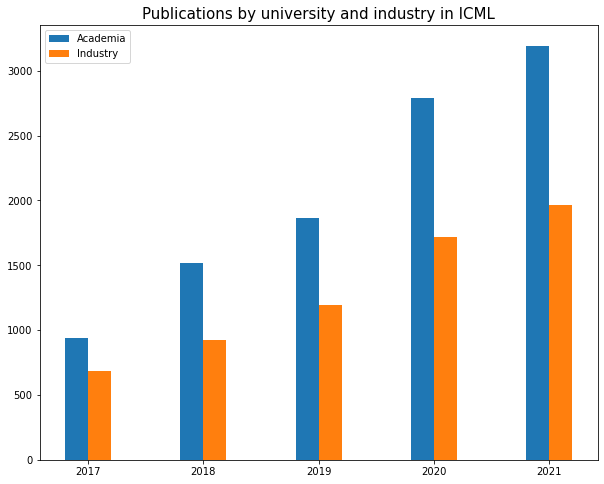

In [38]:
fig,axs = subplots(figsize = (10,8))
years = np.asarray(list(icml_university.keys()))
bar_width = 0.2
axs.bar(years, icml_university.values(), width=bar_width, label = 'Academia')
axs.bar(years + bar_width, icml_industry.values(), width = bar_width, label = 'Industry')
axs.set_xticks(years + bar_width/2)
axs.set_xticklabels(years)
axs.legend(fontsize = 10)
axs.set_title('Publications by university and industry in ICML', fontsize = 15)

Text(0.5, 1.0, 'Publications by university and industry in ICLR')

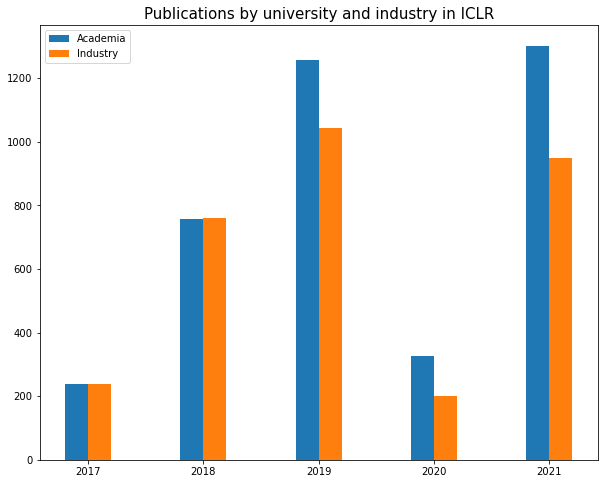

In [39]:
fig,axs = subplots(figsize = (10,8))
years = np.asarray(list(iclr_university.keys()))
bar_width = 0.2
axs.bar(years, iclr_university.values(), width=bar_width, label = 'Academia')
axs.bar(years + bar_width, iclr_industry.values(), width = bar_width, label = 'Industry')
axs.set_xticks(years + bar_width/2)
axs.set_xticklabels(years)
axs.legend(fontsize = 10)
axs.set_title('Publications by university and industry in ICLR', fontsize = 15)

Text(0.5, 1.0, 'Publications by university and industry in CVPR')

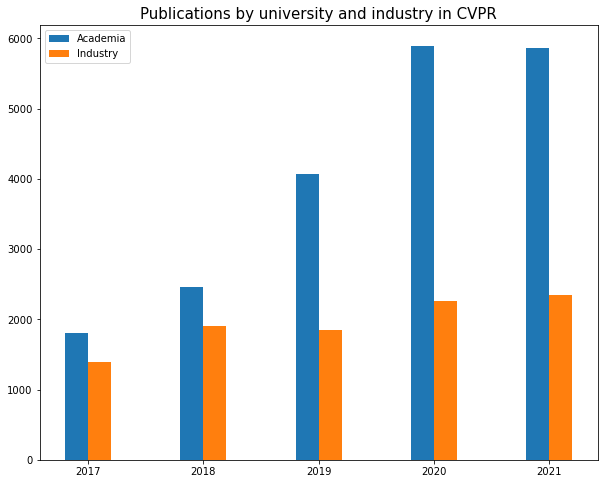

In [40]:
fig,axs = subplots(figsize = (10,8))
years = np.asarray(list(cvpr_university.keys()))
bar_width = 0.2
axs.bar(years, cvpr_university.values(), width=bar_width, label = 'Academia')
axs.bar(years + bar_width, cvpr_industry.values(), width = bar_width, label = 'Industry')
axs.set_xticks(years + bar_width/2)
axs.set_xticklabels(years)
axs.legend(fontsize = 10)
axs.set_title('Publications by university and industry in CVPR', fontsize = 15)

In [41]:
industry_kewords = ['google','microsoft','adobe','amazon','deepmind','ai','research','systems','nvidia','amd']

In [42]:
industry = pd.DataFrame(columns=['keywords'])
industry['keywords'] = industry_kewords

In [43]:
industry

keywords
0     google
1  microsoft
2      adobe
3     amazon
4   deepmind
5         ai
6   research
7    systems
8     nvidia
9        amd

In [44]:
industry.to_csv(data_dir + 'industry_keywords.csv')

# Collaboration of UCSD with industry 

In [45]:
def get_affiliations(aff): 
    for i in range(len(aff)): 
        aff[i] = str(aff[i]).replace("'",'').replace("'",'').replace('"','').replace('"','').replace('[','').replace(']','').lower()
        

In [46]:
get_affiliations(affil_nips_2017)
get_affiliations(affil_nips_2018)
get_affiliations(affil_nips_2019)
get_affiliations(affil_nips_2020)
get_affiliations(affil_nips_2021)

get_affiliations(affil_icml_2017)
get_affiliations(affil_icml_2018)
get_affiliations(affil_icml_2019)
get_affiliations(affil_icml_2020)
get_affiliations(affil_icml_2021)

get_affiliations(affil_iclr_2017)
get_affiliations(affil_iclr_2018)
get_affiliations(affil_iclr_2019)
get_affiliations(affil_iclr_2020)
get_affiliations(affil_iclr_2021)

get_affiliations(affil_cvpr_2017)
get_affiliations(affil_cvpr_2018)
get_affiliations(affil_cvpr_2019)
get_affiliations(affil_cvpr_2020)
get_affiliations(affil_cvpr_2021)


In [48]:
nips_collab = {2017:0, 2018:0,2019:0,2020:0,2021:0}
years = list(nips_collab.keys())
names = [affil_nips_2017,affil_nips_2018,affil_nips_2019,affil_nips_2020,affil_nips_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords) and any(key in temp[j] for key in industry_kewords): 
            nips_collab[year]+=1

In [49]:
icml_collab = {2017:0, 2018:0,2019:0,2020:0, 2021:0}
years = list(icml_collab.keys())
names = [affil_icml_2017,affil_icml_2018,affil_icml_2019,affil_icml_2020,affil_icml_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords) and any(key in temp[j] for key in industry_kewords): 
            icml_collab[year]+=1

In [61]:
iclr_collab = {2017:0, 2018:0,2019:0,2020:0, 2021:0}
years = list(iclr_collab.keys())
names = [affil_iclr_2017,affil_iclr_2018,affil_iclr_2019,affil_iclr_2020,affil_iclr_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords) and any(key in temp[j] for key in industry_kewords): 
            iclr_collab[year]+=1

In [62]:
cvpr_collab = {2017:0, 2018:0,2019:0,2020:0,2021:0}
years = list(cvpr_collab.keys())
names = [affil_cvpr_2017,affil_cvpr_2018,affil_cvpr_2019,affil_cvpr_2020,affil_cvpr_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in uni_keywords) and any(key in temp[j] for key in industry_kewords): 
            cvpr_collab[year]+=1

Text(0.5, 1.0, 'Collaborations between university and industry in each year')

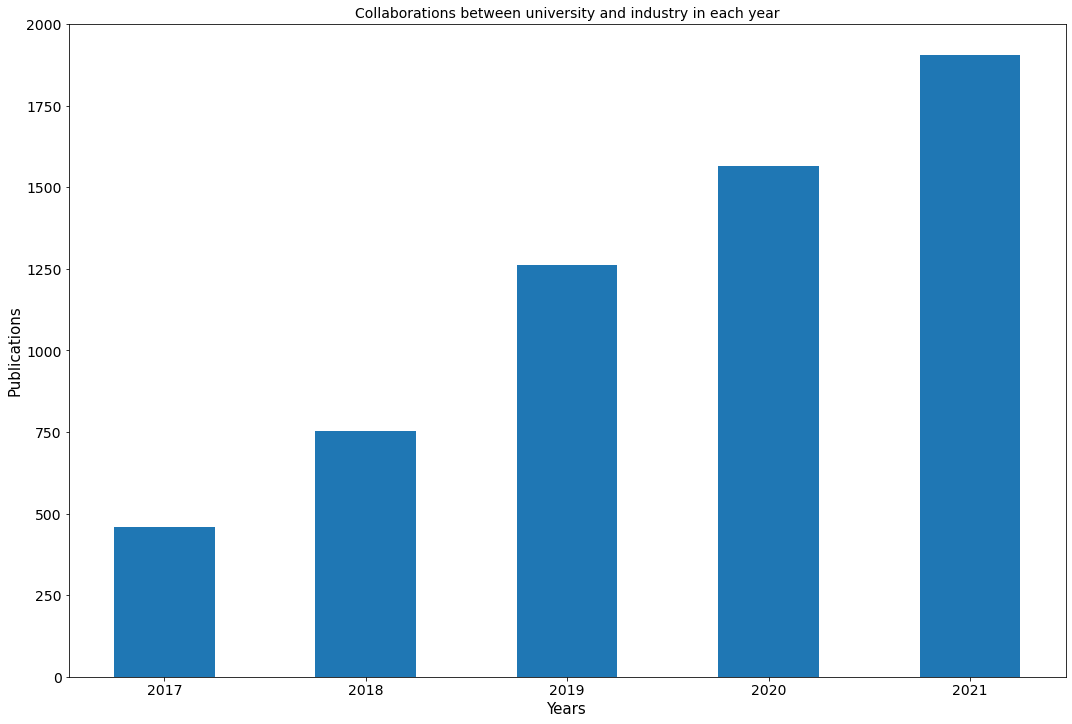

In [126]:
total_collab = dict()
for key in list(nips_collab.keys()):
    total_collab[key] = nips_collab[key] + icml_collab[key] + iclr_collab[key] + cvpr_collab[key]

fig,axs = subplots(figsize = (15,10))
years = np.asarray(list(total_collab.keys()))
bar_width = 0.5
axs.bar(years, total_collab.values(),linewidth = 0, width=bar_width, label = 'Collaboration')
axs.set_xticks(years)
axs.set_xticklabels(years)
axs.set_xlabel('Years', fontsize = 15)
axs.set_ylabel('Publications', fontsize = 15)
plt.setp(axs.get_yticklabels(),fontsize = 14)
plt.setp(axs.get_xticklabels(),fontsize = 14)
plt.tight_layout()
axs.set_title('Collaborations between university and industry in each year', fontsize = 14)    
    

Text(0.5, 1.0, 'Collaborations between university and industry in NeurIPS')

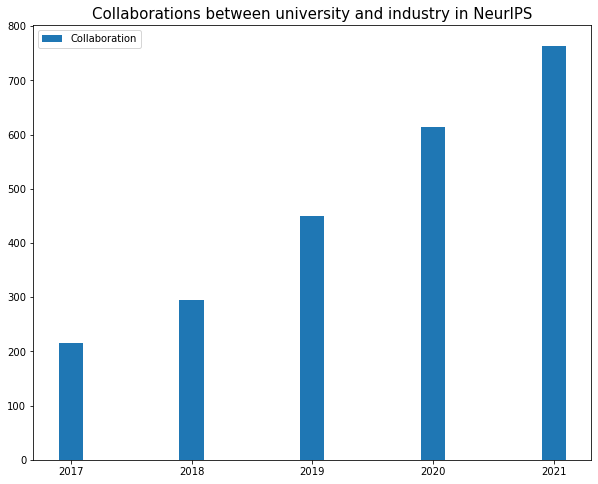

In [121]:
fig,axs = subplots(figsize = (10,8))
years = np.asarray(list(nips_collab.keys()))
bar_width = 0.2
axs.bar(years, nips_collab.values(), width=bar_width, label = 'Collaboration')
axs.set_xticks(years)
axs.set_xticklabels(years)
plt.setp(axs.get_yticklabels(),fontsize = 14)
plt.setp(axs.get_xticklabels(),fontsize = 14)

axs.legend(fontsize = 10)
axs.set_title('Collaborations between university and industry in NeurIPS', fontsize = 15)

Text(0.5, 1.0, 'Collaborations between university and industry in ICML')

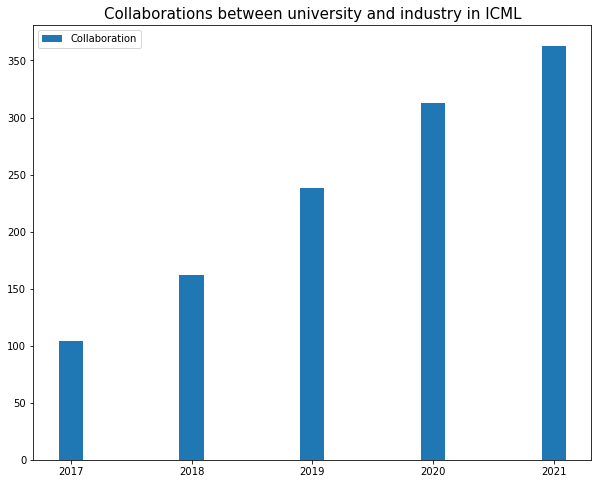

In [69]:
fig,axs = subplots(figsize = (10,8))
years = np.asarray(list(icml_collab.keys()))
bar_width = 0.2
axs.bar(years, icml_collab.values(), width=bar_width, label = 'Collaboration')
axs.set_xticks(years)
axs.set_xticklabels(years)
axs.legend(fontsize = 10)
axs.set_title('Collaborations between university and industry in ICML', fontsize = 15)

Text(0.5, 1.0, 'Collaborations between university and industry in ICLR')

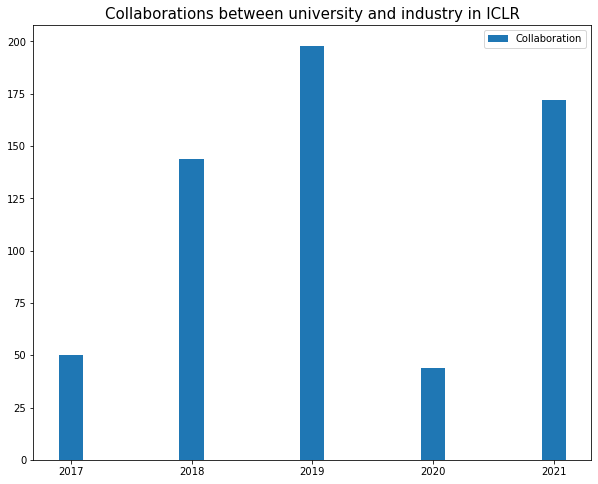

In [70]:
fig,axs = subplots(figsize = (10,8))
years = np.asarray(list(iclr_collab.keys()))
bar_width = 0.2
axs.bar(years, iclr_collab.values(), width=bar_width, label = 'Collaboration')
axs.set_xticks(years)
axs.set_xticklabels(years)
axs.legend(fontsize = 10)
axs.set_title('Collaborations between university and industry in ICLR', fontsize = 15)

In [71]:
ucsd_nips_collab = {2017:0, 2018:0,2019:0,2020:0}
ucsd_key = ['ucsd', 'uc san diego', 'university of california san diego',\
            'university of california at san diego','university of california, san diego','university of california']
years = list(ucsd_nips_collab.keys())
names = [affil_nips_2017,affil_nips_2018,affil_nips_2019,affil_nips_2020]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in ucsd_key) and any(key in temp[j] for key in industry_kewords): 
            ucsd_nips_collab[year]+=1

In [73]:
ucsd_key = ['ucsd', 'uc san diego', 'univerisity of california san diego',\
            'univerisity of california, san diego','univerisity of california']

In [74]:
ucsd_nips = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(ucsd_nips.keys())
names = [affil_nips_2017,affil_nips_2018,affil_nips_2019,affil_nips_2020,affil_nips_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in ucsd_key) and any(key in temp[j] for key in industry_kewords) : 
            ucsd_nips[year]+=1

ucsd_icml = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(ucsd_icml.keys())
names = [affil_icml_2017,affil_icml_2018,affil_icml_2019,affil_icml_2020,affil_icml_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in ucsd_key) and any(key in temp[j] for key in industry_kewords) : 
            ucsd_icml[year]+=1
            
ucsd_iclr = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(ucsd_iclr.keys())
names = [affil_iclr_2017,affil_iclr_2018,affil_iclr_2019,affil_iclr_2020,affil_iclr_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in ucsd_key) and any(key in temp[j] for key in industry_kewords) : 
            ucsd_iclr[year]+=1

ucsd_cvpr = {2017:0, 2018:0,2019:0,2020:0,2021:0}

years = list(ucsd_cvpr.keys())
names = [affil_cvpr_2017,affil_cvpr_2018,affil_cvpr_2019,affil_cvpr_2020,affil_cvpr_2021]
for i in range(len(names)):
    year = years[i]
    temp = names[i]
    for j in range(len(temp)):
        if any(key in temp[j] for key in ucsd_key) and any(key in temp[j] for key in industry_kewords) : 
            ucsd_cvpr[year]+=1
 


In [84]:
ucsd_collab = {2017:0, 2018:0,2019:0,2020:0,2021:0}
years = list(ucsd_collab.keys())
for year in (years): 
    ucsd_collab[year] = ucsd_nips[year] + ucsd_icml[year] + ucsd_iclr[year] + ucsd_cvpr[year]

Text(0.5, 1.0, 'Collaborations between UCSD and Industries')

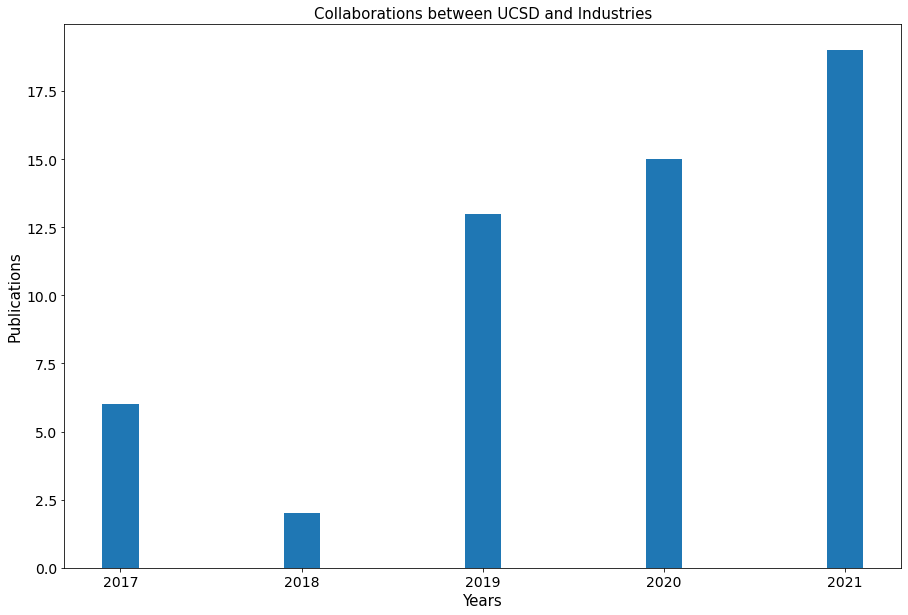

In [128]:
fig,axs = subplots(figsize = (15,10))
years = np.asarray(list(ucsd_collab.keys()))
bar_width = 0.2
axs.bar(years, ucsd_collab.values(), width=bar_width, label = 'Collaboration')
axs.set_xticks(years)
axs.set_xticklabels(years)
axs.set_xlabel('Years', fontsize = 15)
axs.set_ylabel('Publications', fontsize = 15)

plt.setp(axs.get_yticklabels(),fontsize = 14)
plt.setp(axs.get_xticklabels(),fontsize = 14)
axs.set_title('Collaborations between UCSD and Industries', fontsize = 15)

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('./data/icml.csv')
data.info()
abstract = list(data.ABSTRACT)
title = list(data.TITLE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   YEAR        4417 non-null   int64 
 1   TITLE       4417 non-null   object
 2   AUTHORS     4417 non-null   object
 3   PAPER LINK  4417 non-null   object
 4   ABSTRACT    4417 non-null   object
dtypes: int64(1), object(4)
memory usage: 172.7+ KB


In [3]:
data.head(4)

YEAR                                              TITLE  \
0  2016  No Oops, You Won’t Do It Again: Mechanisms for...   
1  2016  Stochastically Transitive Models for Pairwise ...   
2  2016           Uprooting and Rerooting Graphical Models   
3  2016  A Deep Learning Approach to Unsupervised Ensem...   

                                             AUTHORS  \
0                          Nihar Shah, Dengyong Zhou   
1  Nihar Shah, Sivaraman Balakrishnan, Aditya Gun...   
2                                      Adrian Weller   
3  Uri Shaham, Xiuyuan Cheng, Omer Dror, Ariel Ja...   

                                        PAPER LINK  \
0   https://proceedings.mlr.press/v48/shaha16.html   
1   https://proceedings.mlr.press/v48/shahb16.html   
2  https://proceedings.mlr.press/v48/weller16.html   
3  https://proceedings.mlr.press/v48/shaham16.html   

                                            ABSTRACT  
0  Crowdsourcing is a very popular means of obtai...  
1  There are various parametric models for analyz...  
2  We show how any binary pairwise model may be “...  
3  We show how deep learning methods can be appli...

In [4]:
samples = data.sample(4)
for _, s in samples.iterrows():
    print(f"{s.TITLE} (ICML{s.YEAR})")
    print(f"Abstract: {s.ABSTRACT}\n")

Stochastic Latent Residual Video Prediction (ICML2020)
Abstract: Designing video prediction models that account for the inherent uncertainty of the future is challenging. Most works in the literature are based on stochastic image-autoregressive recurrent networks, which raises several performance and applicability issues. An alternative is to use fully latent temporal models which untie frame synthesis and temporal dynamics. However, no such model for stochastic video prediction has been proposed in the literature yet, due to design and training difficulties. In this paper, we overcome these difficulties by introducing a novel stochastic temporal model whose dynamics are governed in a latent space by a residual update rule. This first-order scheme is motivated by discretization schemes of differential equations. It naturally models video dynamics as it allows our simpler, more interpretable, latent model to outperform prior state-of-the-art methods on challenging datasets.

State Space

In [5]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", \
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [6]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

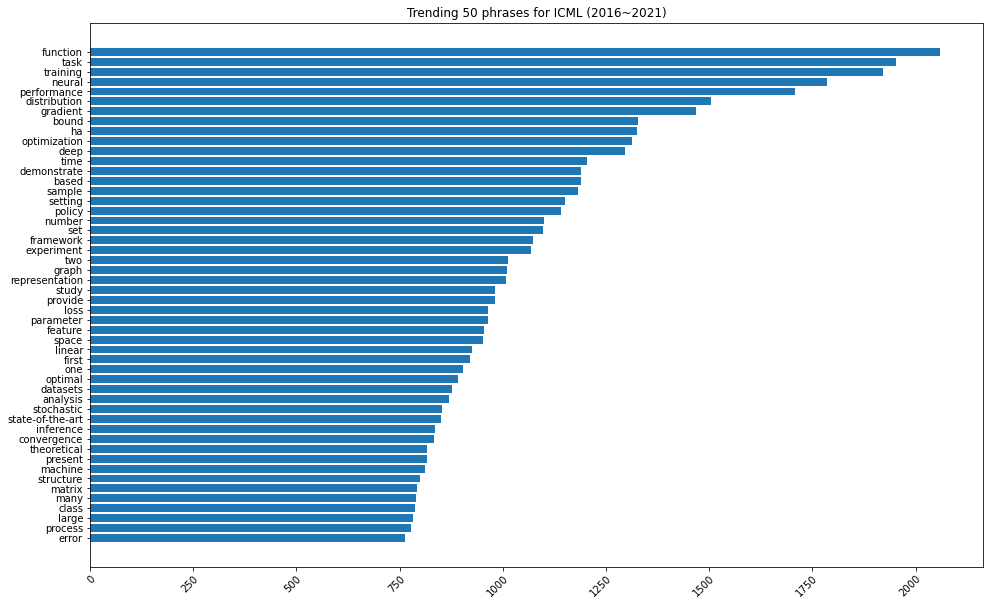

In [7]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 10))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for ICML (2016~2021)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [8]:
diversity_papers = data.loc[:, ("TITLE", "YEAR")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

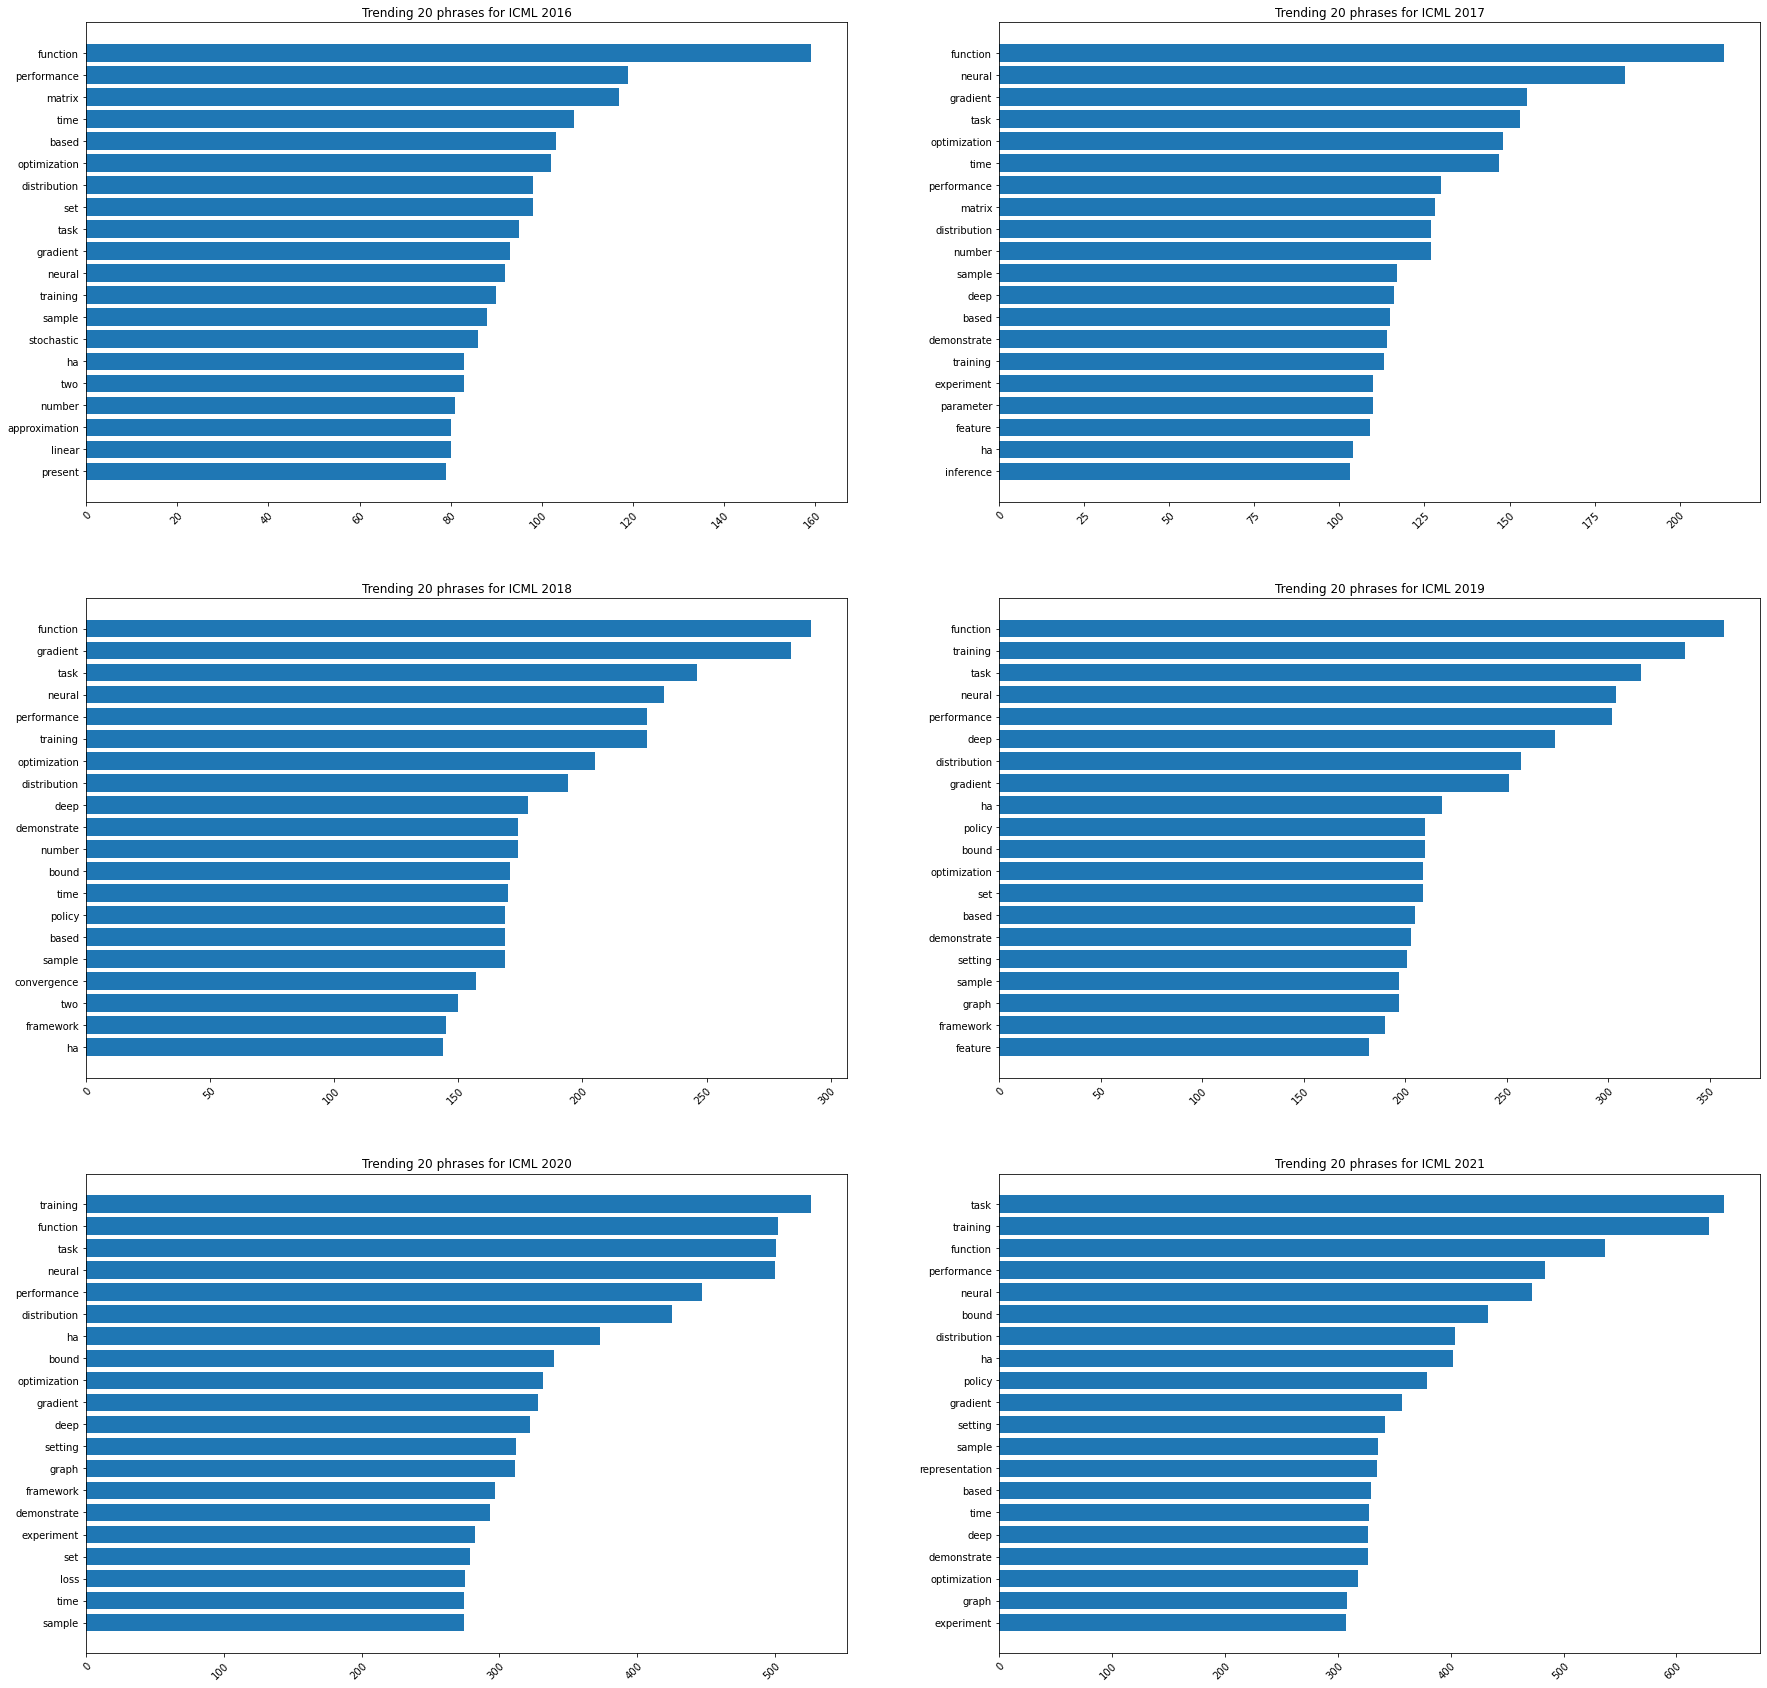

In [9]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.YEAR)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 20
fig, axes = plt.subplots(3, 2, figsize=(30, 30))
for year, ax in zip(range(2016, 2022), axes.reshape(-1)):
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} phrases for ICML {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

plt.show()

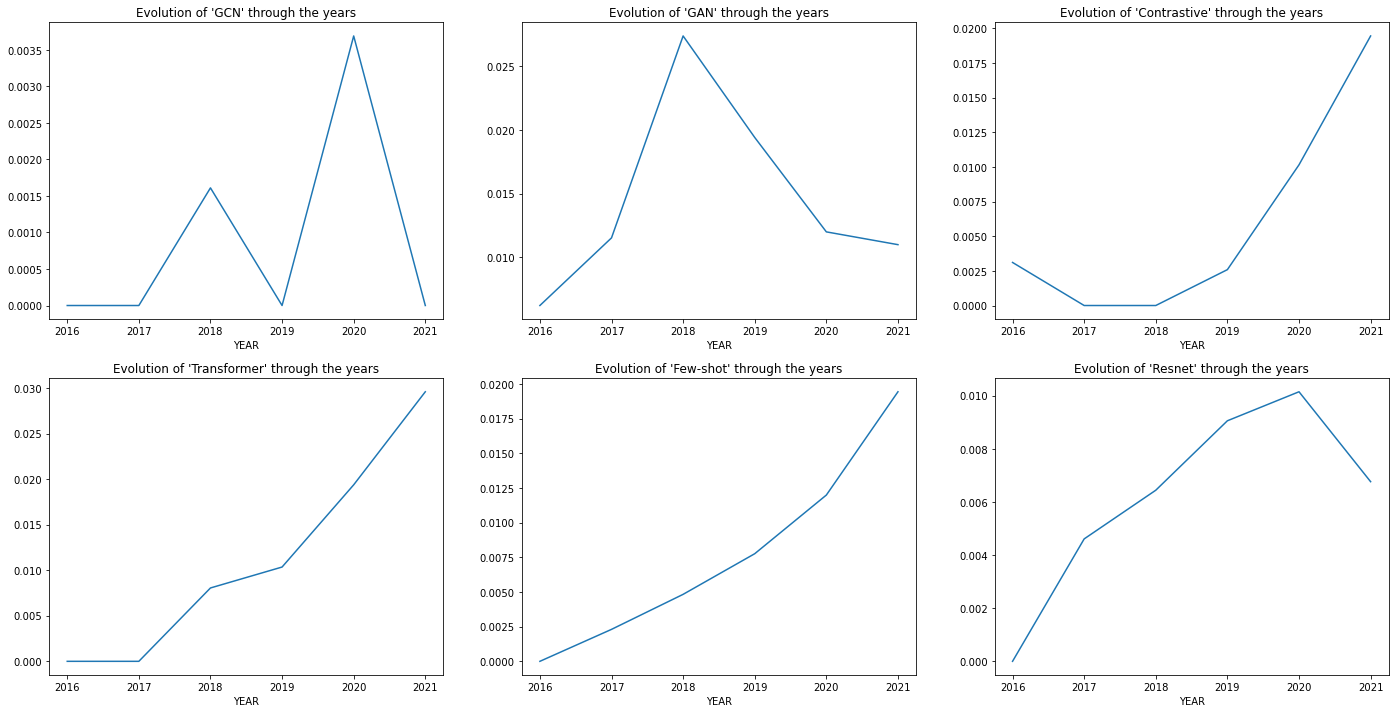

In [10]:
def trace_word_popularity(word):
    assert isinstance(word, str)
    word = word.strip().lower().translate(table)
    assert isinstance(diversity_papers, pd.DataFrame)
    is_word_in_list = np.array([feat==word for feat in tf_vectorizer.get_feature_names_out()])
    if not is_word_in_list.any():
        raise Exception("Couldn't find the word you were looking for.")
        
    if len(word.split()) > 1:
        raise Exception("Must be a 1 word long token separated by spaces.")
    
    total = diversity_papers.groupby('YEAR').count()

    word_idx = np.argwhere(is_word_in_list).item()
    count_df = (diversity_papers.groupby('YEAR').sum().n_themes
                .apply(lambda row: np.array(row))
                .apply(lambda row: row[row == word_idx].size).div(total.n_themes))
    return count_df

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
test_words = ["GCN", "GAN", "Contrastive", "Transformer", "Few-shot", "Resnet"]
for w, ax in zip(test_words, axes.reshape(-1)):
    counts = trace_word_popularity(w)
    counts.plot(ax=ax)
    ax.set_xticks(range(2016, 2022))
    ax.set_title(f"Evolution of '{w}' through the years")

In [11]:
#number of topics
n_topics=6

from sklearn.decomposition import LatentDirichletAllocation
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=321, verbose=0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [12]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [13]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if isinstance(temp_vector_sum, int):
            print(topic)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(" ".join(topic_words))         
    return top_words

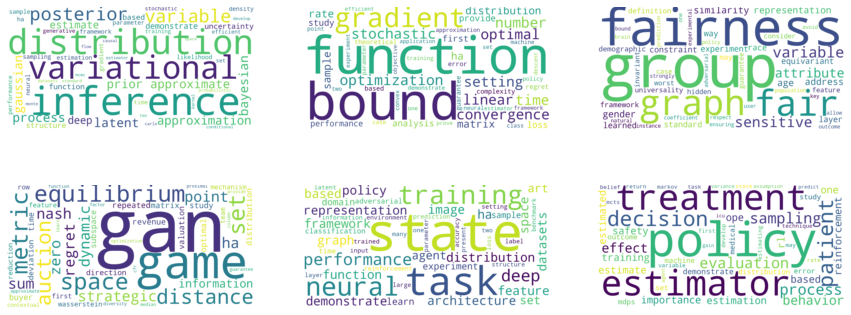

In [14]:
# Printing words from each topic
top_n_words = get_top_n_words(50, lda_keys, tf, tf_vectorizer)

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for tw, ax in zip(top_n_words, axes.reshape(-1)):
    wc = WordCloud(background_color="white", width=1600, height=800)
    wc.generate(tw)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
plt.show()

In [15]:
from sklearn.manifold import TSNE
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4417 samples in 0.002s...
[t-SNE] Computed neighbors for 4417 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4417
[t-SNE] Computed conditional probabilities for sample 2000 / 4417
[t-SNE] Computed conditional probabilities for sample 3000 / 4417
[t-SNE] Computed conditional probabilities for sample 4000 / 4417
[t-SNE] Computed conditional probabilities for sample 4417 / 4417
[t-SNE] Mean sigma: 0.001610
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.959099
[t-SNE] KL divergence after 2000 iterations: 0.627018


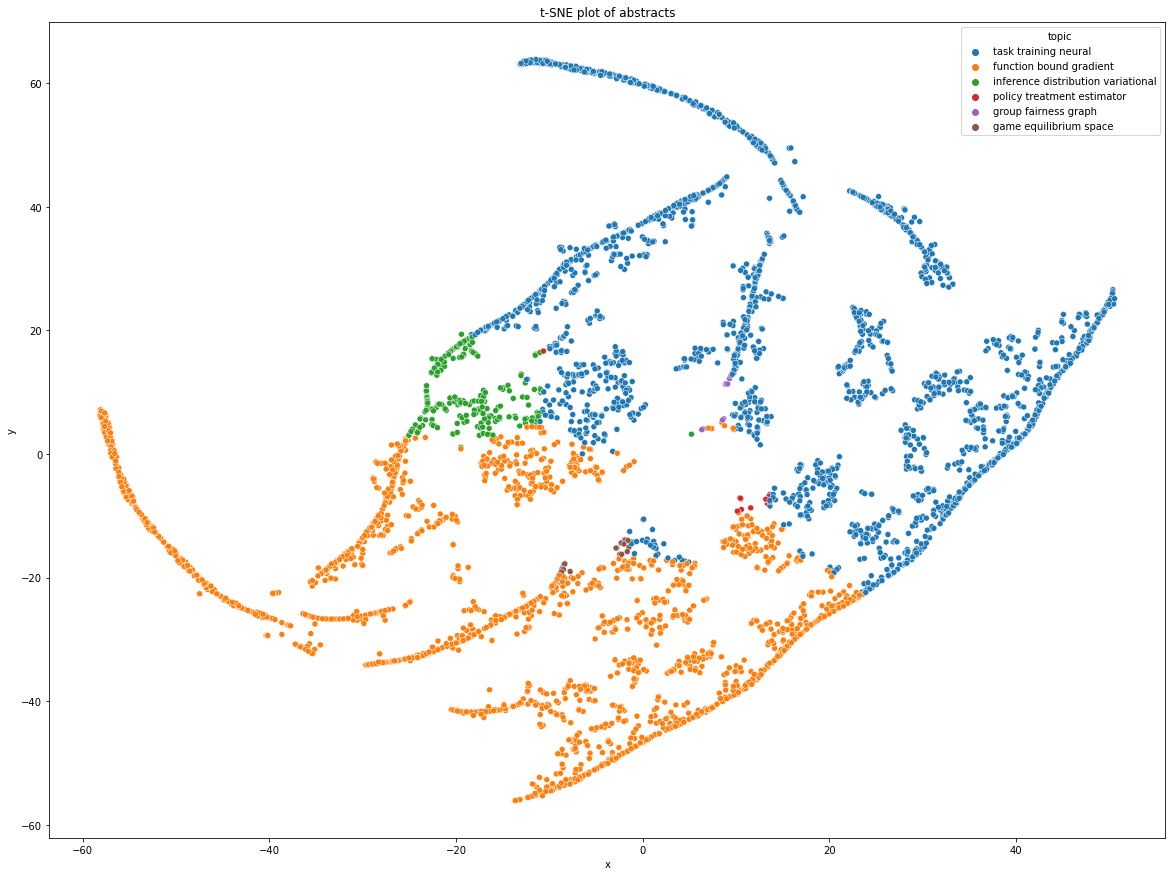

In [16]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

hue = []
for k in lda_keys:
    hue.append(top_3_words_lda[k])

disp_data = pd.DataFrame({'x': pd.Series(tsne_lda_vectors[:,0]), 'y': pd.Series(tsne_lda_vectors[:,1]), 'topic': pd.Series(hue)})
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(data=disp_data, x='x', y='y', hue='topic', ax=ax)
ax.set_title("t-SNE plot of abstracts")
plt.show()

In [17]:
for n in range(5):
    topic_most_pr = lda_topic_matrix[n].argsort()[-2:]
    print("Paper #{}: {}\n - top 2 topic: ({})+({})\n".format(n,title[n], top_3_words_lda[topic_most_pr[0]], top_3_words_lda[topic_most_pr[1]]))

Paper #0: No Oops, You Won’t Do It Again: Mechanisms for Self-correction in Crowdsourcing
 - top 2 topic: (function bound gradient)+(task training neural)

Paper #1: Stochastically Transitive Models for Pairwise Comparisons: Statistical and Computational Issues
 - top 2 topic: (inference distribution variational)+(function bound gradient)

Paper #2: Uprooting and Rerooting Graphical Models
 - top 2 topic: (inference distribution variational)+(function bound gradient)

Paper #3: A Deep Learning Approach to Unsupervised Ensemble Learning
 - top 2 topic: (inference distribution variational)+(task training neural)

Paper #4: Revisiting Semi-Supervised Learning with Graph Embeddings
 - top 2 topic: (group fairness graph)+(task training neural)



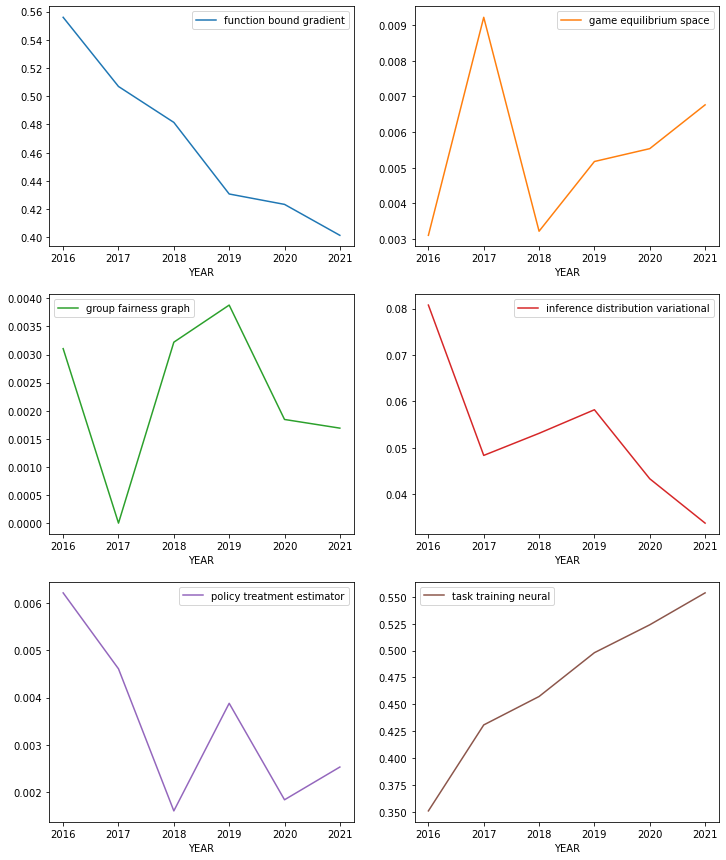

In [18]:
plt.rcParams['figure.figsize'] = (12,15)
lda_topics = [top_3_words_lda[k] for k in lda_keys]
# pd.crosstab(df_new['YEAR'], df_new['Dominant_Topic'], normalize='index').plot.bar(stacked=True)
pd.crosstab(data['YEAR'].astype(int), pd.Series(lda_topics).astype('category'), normalize='index').plot(kind='line', subplots=True, sharex=False, layout=(3, 2))
plt.show()

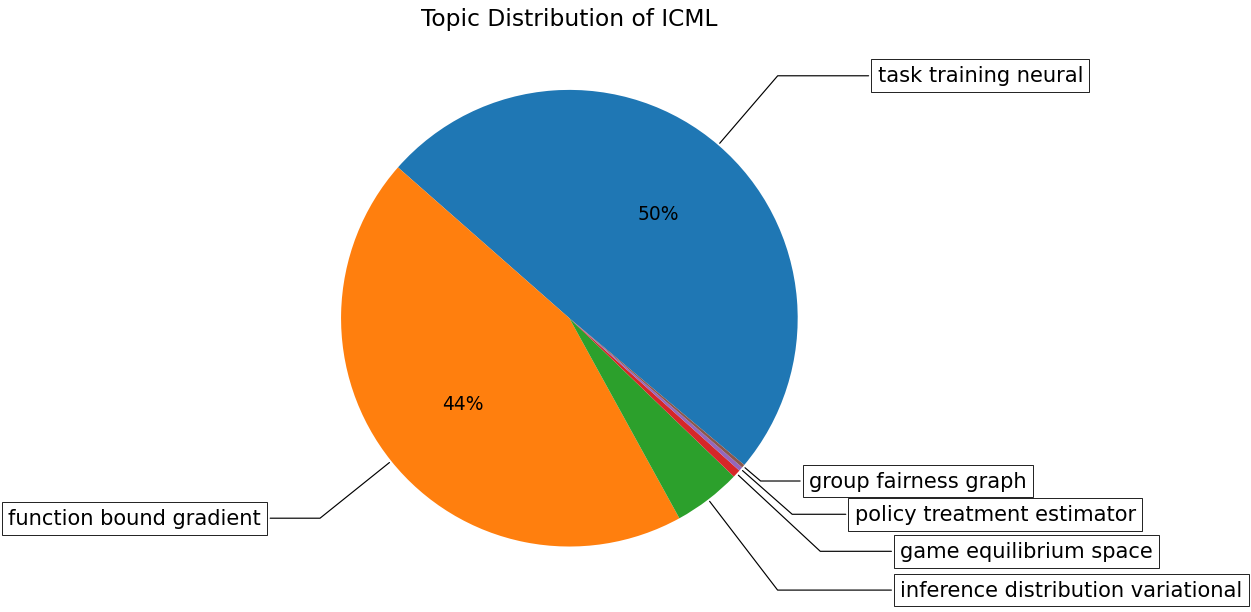

In [19]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

inds = np.flip(np.argsort(lda_counts))

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi=84)

# labels = np.array(top_3_words_lda)[lda_categories]
values = np.array(lda_counts)[inds]
labels = np.array(top_3_words_lda)[lda_categories][inds]

wedges, texts, _ = ax.pie(values, wedgeprops=dict(width=1.0), startangle=-40, autopct=make_autopct(values), textprops={'fontsize': 16})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0.1, -0.1, -0.3][i-2] if i > 1 else 0.0
    ax.annotate(labels[i], xy=(x, y), xytext=((1.35+offset)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title("Topic Distribution of ICML", fontsize=20)

plt.show()

In [20]:
title_proc = []
for i in range(len(title)):
    t = title[i].strip().lower().translate(table).split()
    title_proc.append([lemm.lemmatize(w) for w in t])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tv = tfidf_vectorizer.fit_transform(title_proc)
tv_norm = normalize(tv, axis=1)

In [21]:
from scipy.spatial.distance import jensenshannon as js
def find_n_related(inp_t, inp_ab, n, alpha=0.5):
    assert isinstance(inp_t, str)
    assert isinstance(inp_ab, str)
    # preprocess
    t_proc = inp_t.strip().lower().translate(table).split()
    ab_proc = inp_ab.strip().lower().translate(table).split()
    t_proc = [lemm.lemmatize(w) for w in t_proc]
    ab_proc = [lemm.lemmatize(w) for w in ab_proc]

    t_vec = tfidf_vectorizer.transform([t_proc]).toarray()
    t_vec = normalize(t_vec, axis=1)
    # print(t_vec.shape)
    t_scores = np.matmul(tv_norm.toarray(), t_vec.T).squeeze()

    ab_vec = tf_vectorizer.transform([ab_proc]).toarray()
    logits = lda.transform(ab_vec)
    # ab_scores = np.matmul(lda_topic_matrix, logits.T).squeeze()
    ab_scores = 1 - np.array([js(v.squeeze(), logits.squeeze(), 2) for v in lda_topic_matrix])

    scores = alpha * t_scores + (1-alpha) * ab_scores
    inds = np.flip(np.argsort(scores))[:n]
    retrieved = data.loc[inds, :]
    retrieved["Score"] = scores[inds]

    return retrieved

In [22]:
# Temporal Localization of Moments in Video Collections with Natural Language (ICCV2019)
# https://arxiv.org/abs/1907.12763
test_t = "Temporal Localization of Moments in Video Collections with Natural Language"
test_abs = """In this paper, we introduce the task of retrieving relevant video moments from a large corpus of untrimmed, unsegmented videos given a natural language query.
Our task poses unique challenges as a system must efficiently identify both the relevant videos and localize the relevant moments in the videos.
This task is in contrast to prior work that localizes relevant moments in a single video or searches a large collection of already-segmented videos.
For our task, we introduce Clip Alignment with Language (CAL), a model that aligns features for a natural language query to a sequence of short video clips that compose a candidate moment in a video.
Our approach goes beyond prior work that aggregates video features over a candidate moment by allowing for finer clip alignment.
Moreover, our approach is amenable to efficient indexing of the resulting clip-level representations, which makes it suitable for moment localization in large video collections.
We evaluate our approach on three recently proposed datasets for temporal localization of moments in video with natural language extended to our video corpus moment retrieval setting: DiDeMo, Charades-STA, and ActivityNet-captions.
We show that our CAL model outperforms the recently proposed Moment Context Network (MCN) on all criteria across all datasets on our proposed task, obtaining an 8%-85% and 11%-47% boost for average recall and median rank, respectively,
and achieves 5x faster retrieval and 8x smaller index size with a 500K video corpus."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICML{s.YEAR}): {s.Score:.3f}")

Coupling Distributed and Symbolic Execution for Natural Language Queries (ICML2017): 0.643
Weakly-Supervised Temporal Localization via Occurrence Count Learning (ICML2019): 0.643
Grey-box Extraction of Natural Language Models (ICML2021): 0.622
Entropy Minimization In Emergent Languages (ICML2020): 0.615
The Natural Language of Actions (ICML2019): 0.595
A Statistical Investigation of Long Memory in Language and Music (ICML2019): 0.590
Video Prediction via Example Guidance (ICML2020): 0.582
Learning Implicit Generative Models with the Method of Learned Moments (ICML2018): 0.553
TeraPipe: Token-Level Pipeline Parallelism for Training Large-Scale Language Models (ICML2021): 0.550
Stochastic Latent Residual Video Prediction (ICML2020): 0.549


In [23]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16955 (AAAI2021)
test_t = "Adversarial Defence by Diversified Simultaneous Training of Deep Ensembles"
test_abs = """Learning-based classifiers are susceptible to adversarial examples. Existing defence methods are mostly devised on individual classifiers.
Recent studies showed that it is viable to increase adversarial robustness by promoting diversity over an ensemble of models.
In this paper, we propose adversarial defence by encouraging ensemble diversity on learning high-level feature representations and gradient dispersion in simultaneous training of deep ensemble networks.
We perform extensive evaluations under white-box and black-box attacks including transferred examples and adaptive attacks.
Our approach achieves a significant gain of up to 52% in adversarial robustness, compared with the baseline and the state-of-the-art method on image benchmarks with complex data scenes.
The proposed approach complements the defence paradigm of adversarial training, and can further boost the performance. The source code is available at https://github.com/ALIS-Lab/AAAI2021-PDD."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICML{s.YEAR}): {s.Score:.3f}")

Simultaneous Similarity-based Self-Distillation for Deep Metric Learning (ICML2021): 0.698
Confidence-Calibrated Adversarial Training: Generalizing to Unseen Attacks (ICML2020): 0.600
Memory-Efficient Pipeline-Parallel DNN Training (ICML2021): 0.582
Improving Adversarial Robustness via Promoting Ensemble Diversity (ICML2019): 0.578
Improved OOD Generalization via Adversarial Training and Pretraing (ICML2021): 0.560
Reinforcing Adversarial Robustness using Model Confidence Induced by Adversarial Training (ICML2018): 0.559
Robust Adversarial Reinforcement Learning (ICML2017): 0.553
Tempered Adversarial Networks (ICML2018): 0.547
Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks (ICML2020): 0.545
Concise Explanations of Neural Networks using Adversarial Training (ICML2020): 0.537


In [24]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16815 (AAAI2021)
test_t = "Learning Invariant Representations using Inverse Contrastive Loss"
test_abs = """Learning invariant representations is a critical first step in a number of machine learning tasks.
A common approach is given by the so-called information bottleneck principle in which an application dependent function of mutual information is carefully chosen and optimized.
Unfortunately, in practice, these functions are not suitable for optimization purposes since these losses are agnostic of the metric structure of the parameters of the model.
In our paper, we introduce a class of losses for learning representations that are invariant to some extraneous variable of interest by inverting the class of contrastive losses, i.e., inverse contrastive loss (ICL).
We show that if the extraneous variable is binary, then optimizing ICL is equivalent to optimizing a regularized MMD divergence.
More generally, we also show that if we are provided a metric on the sample space, our formulation of ICL can be decomposed into a sum of convex functions of the given distance metric.
Our experimental results indicate that models obtained by optimizing ICL achieve significantly better invariance to the extraneous variable for a fixed desired level of accuracy.
In a variety of experimental settings, we show applicability of ICL for learning invariant representations for both continuous and discrete protected/extraneous variables.
The project page with code is available at https://github.com/adityakumarakash/ICL"""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICML{s.YEAR}): {s.Score:.3f}")

A Free-Energy Principle for Representation Learning (ICML2020): 0.553
Soft-DTW: a Differentiable Loss Function for Time-Series (ICML2017): 0.540
Invariant Risk Minimization Games (ICML2020): 0.531
Factor-analytic inverse regression for high-dimension, small-sample dimensionality reduction (ICML2021): 0.524
The Earth Mover’s Pinball Loss: Quantiles for Histogram-Valued Regression (ICML2021): 0.517
Supervised learning: no loss no cry (ICML2020): 0.514
Dissecting Supervised Contrastive Learning (ICML2021): 0.513
Understanding Contrastive Representation Learning through Alignment and Uniformity on the Hypersphere (ICML2020): 0.510
Decomposed Mutual Information Estimation for Contrastive Representation Learning (ICML2021): 0.507
Minimizing the Maximal Loss: How and Why (ICML2016): 0.500


In [25]:
import pickle
with open("./saved_models/lda_icml.pickle", 'wb') as f:
    pickle.dump(lda, f)

In [26]:
np.save("./saved_models/matrix_icml.npy", lda_topic_matrix)

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import bar_chart_race as bcr
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
nips_data = pd.read_csv('./data/nips_2016-2020.csv')
cvpr_data = pd.read_csv('./data/cvpr_16-21.csv')
icml_data = pd.read_csv('./data/icml.csv')
iclr_data = pd.read_csv('./data/ICLR-2017-18-19-21.csv')
icml_aff = pd.read_csv('./data/icml_affiliations.csv')

In [3]:
nips_data = nips_data.rename(columns={old_name: old_name.lower() for old_name in nips_data.columns})
cvpr_data = cvpr_data.rename(columns={old_name: old_name.lower() for old_name in cvpr_data.columns})
icml_data = icml_data.rename(columns={old_name: old_name.lower() for old_name in icml_data.columns})
iclr_data = iclr_data.rename(columns={old_name: old_name.lower() for old_name in iclr_data.columns})
icml_aff = icml_aff.rename(columns={old_name: old_name.lower() for old_name in icml_aff.columns})

In [4]:
nips_data.drop(columns=['paper link'], inplace=True)
cvpr_data.drop(columns=['unnamed: 0', 'citations'], inplace=True)
icml_data.drop(columns=['paper link'], inplace=True)
iclr_data.drop(columns=['paper link', 'citations', 'unnamed: 7'], inplace=True)
icml_aff.drop(columns=['paper link'], inplace=True)

In [5]:
nips_data['conference'] = ['nips']*nips_data.shape[0]
cvpr_data['conference'] = ['cvpr']*cvpr_data.shape[0]
icml_data['conference'] = ['icml']*icml_data.shape[0]
iclr_data['conference'] = ['iclr']*iclr_data.shape[0]

In [6]:
icml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        4417 non-null   int64 
 1   title       4417 non-null   object
 2   authors     4417 non-null   object
 3   abstract    4417 non-null   object
 4   conference  4417 non-null   object
dtypes: int64(1), object(4)
memory usage: 172.7+ KB


In [7]:
aff = icml_aff.affiliations.tolist()
aff_title = icml_aff.title.tolist()
aff_new = []
for i, row in icml_data.iterrows():
    if row.title in aff_title:
        aff_new.append(aff[aff_title.index(row.title)])
    else:
        aff_new.append(np.nan)
icml_data['affiliations'] = aff_new

In [8]:
icml_data.head()

year                                              title  \
0  2016  No Oops, You Won’t Do It Again: Mechanisms for...   
1  2016  Stochastically Transitive Models for Pairwise ...   
2  2016           Uprooting and Rerooting Graphical Models   
3  2016  A Deep Learning Approach to Unsupervised Ensem...   
4  2016  Revisiting Semi-Supervised Learning with Graph...   

                                             authors  \
0                          Nihar Shah, Dengyong Zhou   
1  Nihar Shah, Sivaraman Balakrishnan, Aditya Gun...   
2                                      Adrian Weller   
3  Uri Shaham, Xiuyuan Cheng, Omer Dror, Ariel Ja...   
4    Zhilin Yang, William Cohen, Ruslan Salakhudinov   

                                            abstract conference affiliations  
0  Crowdsourcing is a very popular means of obtai...       icml          NaN  
1  There are various parametric models for analyz...       icml          NaN  
2  We show how any binary pairwise model may be “...       icml          NaN  
3  We show how deep learning methods can be appli...       icml          NaN  
4  We present a semi-supervised learning framewor...       icml          NaN

In [9]:
data = pd.concat([nips_data, cvpr_data, icml_data, iclr_data])
abstract = data.abstract.tolist()
title = data.abstract.tolist()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20698 entries, 0 to 1496
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          20698 non-null  int64 
 1   title         20698 non-null  object
 2   authors       20698 non-null  object
 3   abstract      20698 non-null  object
 4   affiliations  20197 non-null  object
 5   conference    20698 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


In [10]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", "based", "two","one","state-of-the-art","many", "first", "present", "provide","demonstrate","ha",\
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [11]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-'] not in stop_words.
  warnings.warn(


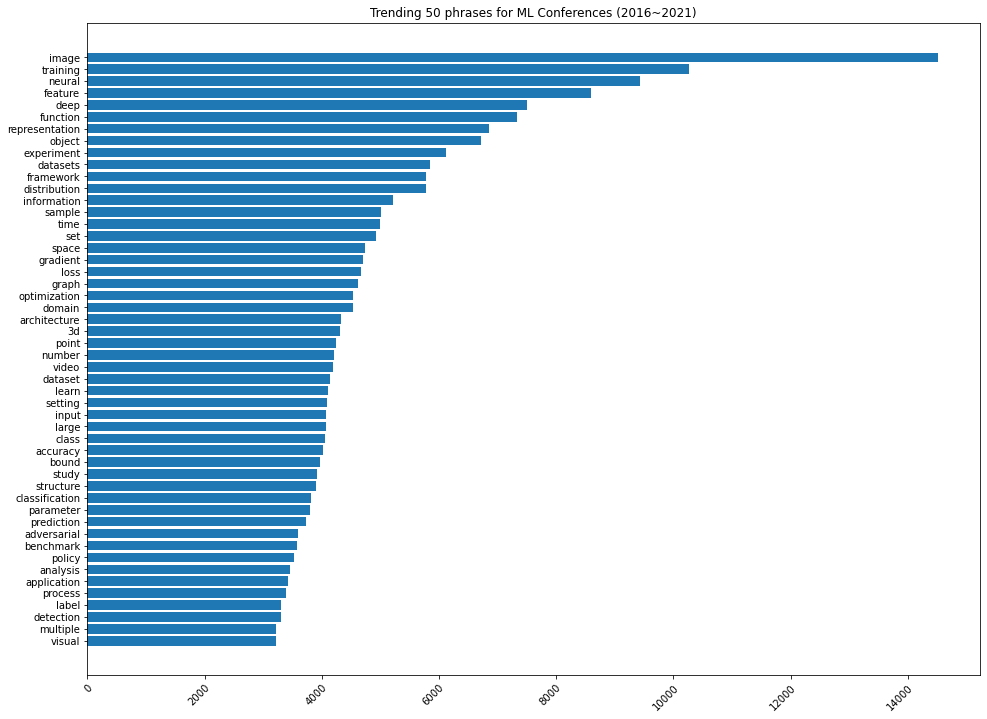

In [12]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 12))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for ML Conferences (2016~2021)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [14]:
diversity_papers = data.loc[:, ("title", "year")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

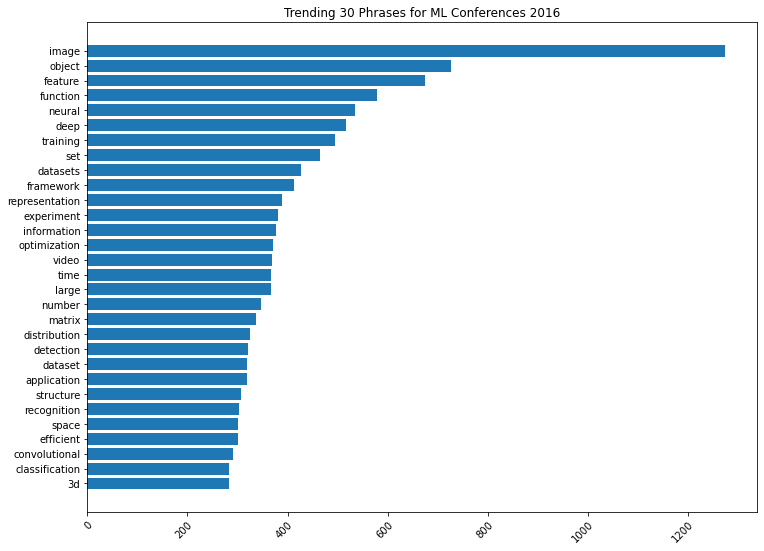

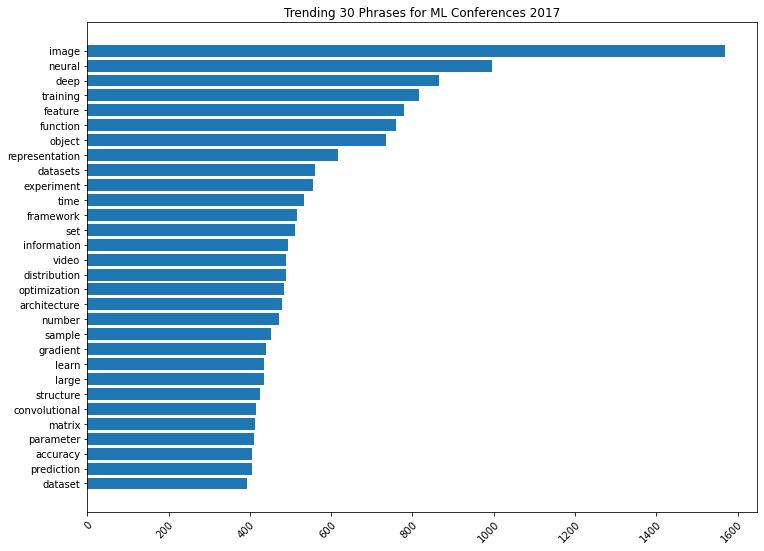

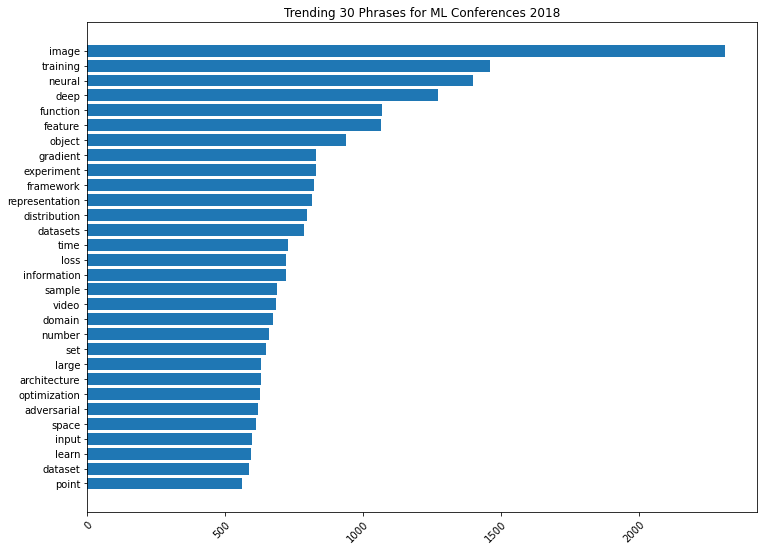

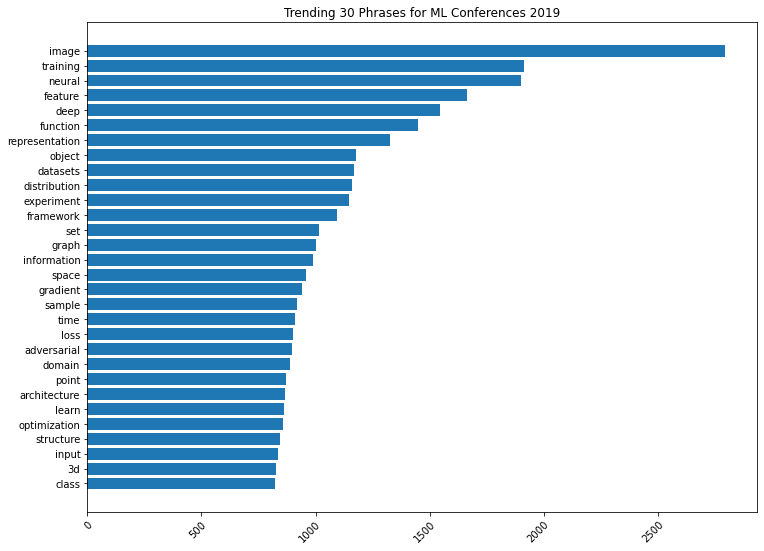

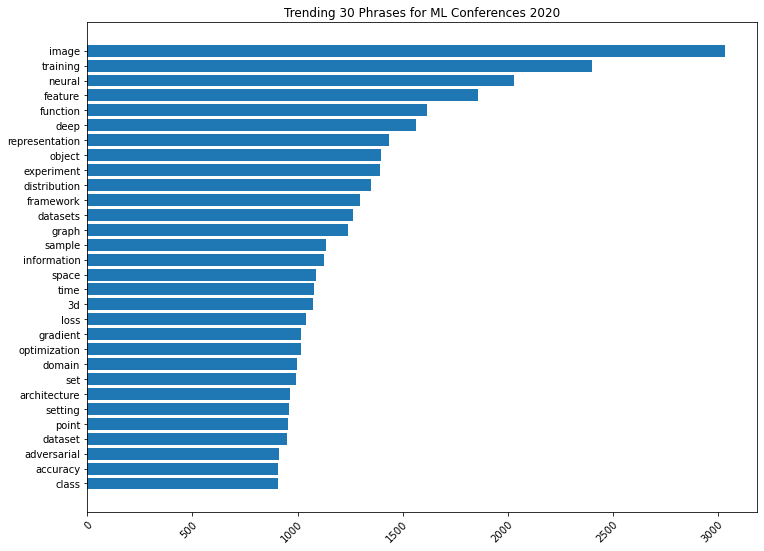

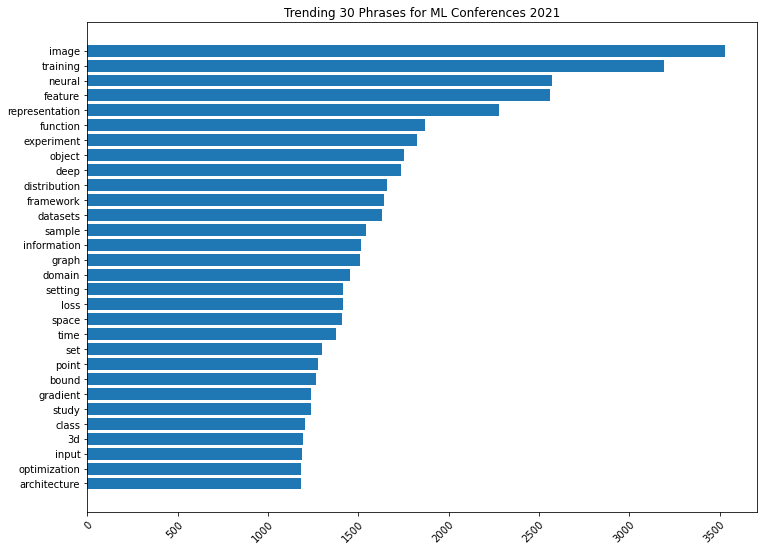

In [14]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.year)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 30
# fig, axes = plt.subplots(2, 3, figsize=(50, 30))
for year in range(2016, 2022):
    fig, ax = plt.subplots(figsize=(12, 9))
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} Phrases for ML Conferences {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

In [12]:
freq_year = []
for year in range(2016,2022):
    freq_year.append(tf.toarray()[np.where(np.array(data.year)==year)[0], :].sum(0))
df_freq = pd.DataFrame(freq_year, columns=tf_vectorizer.get_feature_names_out(), index=['2016','2017','2018','2019','2020','2021'])

/opt/anaconda3/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


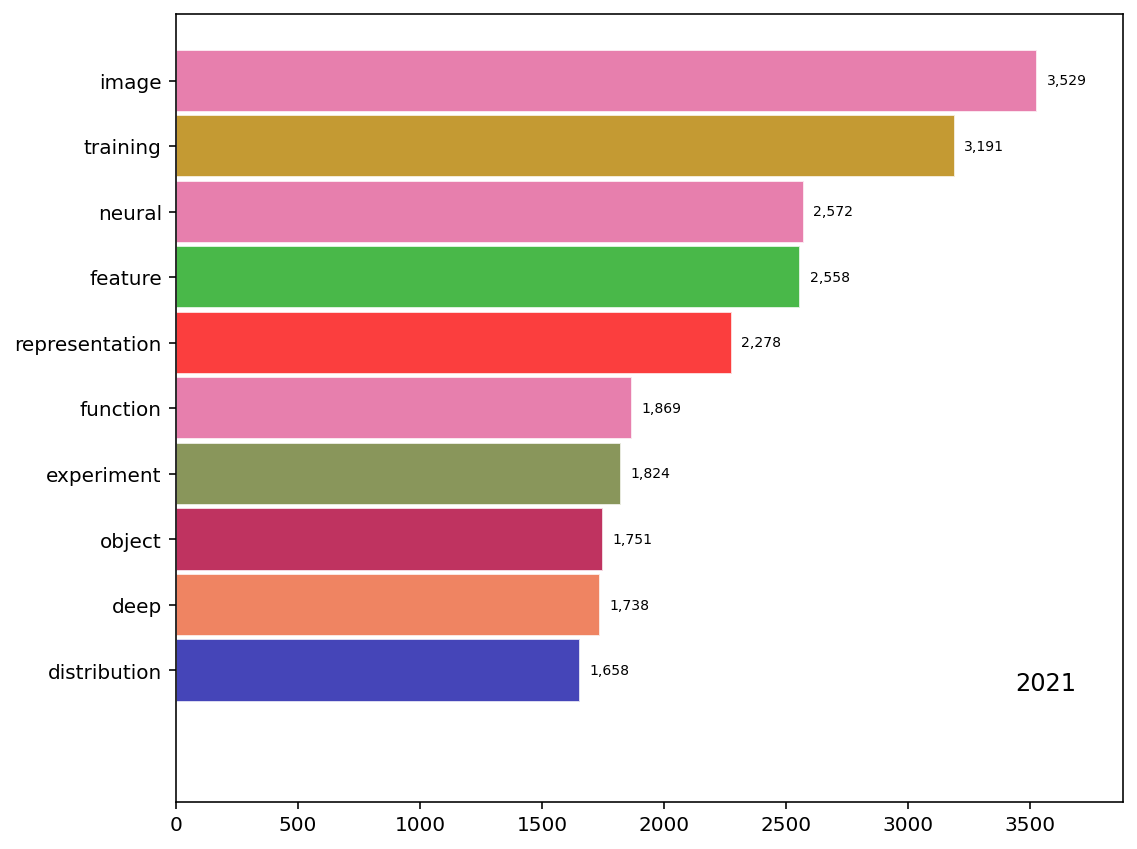

In [16]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=144, tight_layout=True)
bcr.bar_chart_race(df_freq, './trend.mp4', n_bars=10, fig=fig, figsize=(8, 6), period_length=5000, steps_per_period=50, period_fmt="{x}", tick_label_size=12)

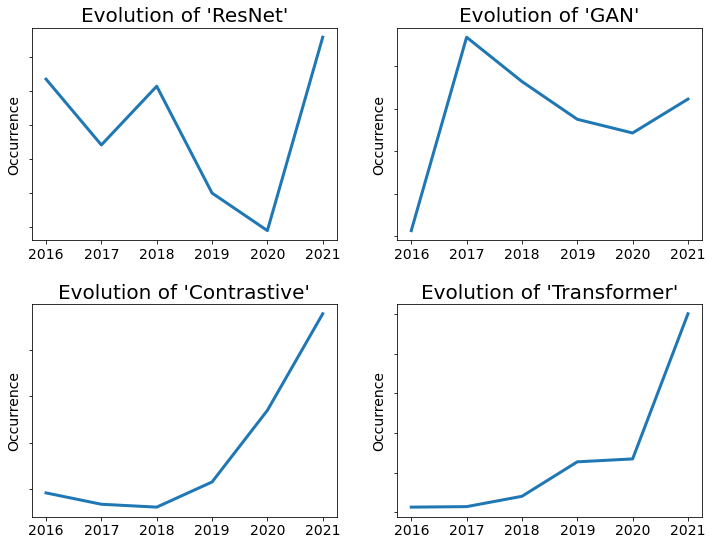

In [16]:
def trace_word_popularity(word):
    assert isinstance(word, str)
    word = word.strip().lower().translate(table)
    assert isinstance(diversity_papers, pd.DataFrame)
    is_word_in_list = np.array([feat==word for feat in tf_vectorizer.get_feature_names_out()])
    if not is_word_in_list.any():
        raise Exception("Couldn't find the word you were looking for.")
        
    if len(word.split()) > 1:
        raise Exception("Must be a 1 word long token separated by spaces.")
    
    total = diversity_papers.groupby('year').count()

    word_idx = np.argwhere(is_word_in_list).item()
    count_df = (diversity_papers.groupby('year').sum().n_themes
                .apply(lambda row: np.array(row))
                .apply(lambda row: row[row == word_idx].size).div(total.n_themes))
    return count_df

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
test_words = ["ResNet", "GAN", "Contrastive", "Transformer"]
for w, ax in zip(test_words, axes.reshape(-1)):
    counts = trace_word_popularity(w)
    counts.plot(ax=ax, linewidth=3)
    ax.set_xticks(range(2016, 2022))
    ax.tick_params(axis='x', labelsize=14)
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("Occurrence", fontsize=14)
    ax.set_title(f"Evolution of '{w}'", fontsize=20)
plt.subplots_adjust(hspace=0.3)